# Importing Libraries

In [1]:
import pandas as pd
from pickle import TRUE
import sys, os, time
import numpy as np
import numpy.matlib
import json
from joblib import dump, load
from pathlib import Path
import io

from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor 
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, Input
from keras.utils import np_utils
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from statistics import mean
from sklearn.ensemble import IsolationForest
from scipy.ndimage import gaussian_filter1d
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn import linear_model
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score 
import keras_tuner
import tensorflow as tf
from tensorflow import keras
import time


# Must run

This part contains necessary information. moving_average for preprocessing is defined here. In master thesis 2nd validation choice(which most similar RSSI compared to test set is chosen here.) 

In [2]:
st = time.time()

data=pd.read_csv("labeled_data.csv")
frequencies = [8e7,30e7,99e7]
es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)

def l2_dist(p1, p2):
    x1,y1 = p1
    x2,y2 = p2
    x1, y1 = np.array(x1), np.array(y1)
    x2, y2 = np.array(x2), np.array(y2)
    dx = x1 - x2
    dy = y1 - y2
    dx = dx ** 2
    dy = dy ** 2
    dists = dx + dy
    dists=dists.astype("float")
    dists = np.sqrt(dists)
    return np.mean(dists)

def moving_average(x, w):
    y=np.pad(x, (w//2, w-1-w//2), mode='edge')
    y_smooth = np.convolve(y, np.ones((w,))/w, mode='valid') 
    return y_smooth

# Code below calculated for validation choice
groups_in_file = data.groupby(['position_x','position_y'])

dicts2={}
for f in frequencies:
    dicts={}
    for k,group in enumerate(groups_in_file.groups):        
        temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])
        temp_train = data.loc[temp_filter].loc[data['frequency'] == f].iloc[:,4:]
        dicts[group]=np.mean(temp_train["receiver_1"]),np.mean(temp_train["receiver_2"]),np.mean(temp_train["receiver_3"]),np.mean(temp_train["receiver_4"])
    dicts2[f]=dicts
    
groups_in_file = data.groupby(['position_x','position_y'])
realdicc={}
for L,groups in enumerate(groups_in_file.groups):
    realdic={}
    for f in frequencies:
        temp_filter = (data['position_x'] == groups[0])&(data['position_y'] == groups[1])
        temp_test = data.loc[temp_filter].loc[data['frequency'] == f].iloc[:,4:]
        disct={}
        for k,group in enumerate(groups_in_file.groups):
            a=dicts2[f][group]-np.mean(temp_test)
            disct[group]=np.abs(a[0])+np.abs(a[1])+np.abs(a[2])+np.abs(a[3])
        realdic[f]=sorted(disct.items(), key=lambda item: item[1])[1]
    realdicc[groups]=realdic
et = time.time()
print(et-st)

C:\Users\ayber\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


204.16158080101013


Most similar RSSI compared to test set is shown here for each location. Algorithms from this dictionary takes their values.

In [3]:
realdicc

{(3.5, 3.0): {80000000.0: ((4.0, 8.0), 10.829864441984085),
  300000000.0: ((4.0, 8.0), 6.935164967166283),
  990000000.0: ((4.0, 8.0), 16.175355321559323)},
 (3.5, 12.0): {80000000.0: ((8.25, 2.0), 9.981357611110639),
  300000000.0: ((8.25, 2.0), 25.834766494551083),
  990000000.0: ((11.0, 9.0), 22.204042599607263)},
 (4.0, 8.0): {80000000.0: ((3.5, 3.0), 10.829864441984085),
  300000000.0: ((3.5, 3.0), 6.935164967166283),
  990000000.0: ((3.5, 3.0), 16.175355321559323)},
 (4.0, 18.0): {80000000.0: ((8.25, 2.0), 8.747699677579789),
  300000000.0: ((11.0, 9.0), 28.96508512538592),
  990000000.0: ((21.0, 14.0), 16.50005358733467)},
 (8.25, 2.0): {80000000.0: ((4.0, 18.0), 8.747699677579789),
  300000000.0: ((11.5, 3.0), 10.865298558530853),
  990000000.0: ((4.0, 8.0), 19.30454935132157)},
 (9.0, 21.0): {80000000.0: ((3.5, 12.0), 16.8116930899141),
  300000000.0: ((11.0, 9.0), 22.50555464732073),
  990000000.0: ((4.0, 18.0), 19.318395213164607)},
 (11.0, 9.0): {80000000.0: ((15.33, 2.0),

In [4]:
groups_in_file = data.groupby(['position_x','position_y'])
for k,group in enumerate(groups_in_file.groups):
    print(k,group)

0 (3.5, 3.0)
1 (3.5, 12.0)
2 (4.0, 8.0)
3 (4.0, 18.0)
4 (8.25, 2.0)
5 (9.0, 21.0)
6 (11.0, 9.0)
7 (11.5, 3.0)
8 (12.0, 30.0)
9 (12.0, 33.0)
10 (12.0, 37.0)
11 (14.0, 14.0)
12 (15.33, 2.0)
13 (16.0, 27.0)
14 (17.0, 38.0)
15 (18.0, 23.0)
16 (19.0, 3.0)
17 (19.0, 37.0)
18 (21.0, 14.0)
19 (21.0, 19.0)
20 (21.0, 21.0)
21 (21.0, 23.0)
22 (21.0, 31.0)
23 (23.0, 3.0)
24 (23.0, 37.0)
25 (24.0, 23.0)
26 (24.0, 26.0)
27 (25.0, 1.0)
28 (26.0, 26.0)
29 (26.0, 38.0)
30 (29.0, 19.0)
31 (29.0, 23.0)
32 (30.0, 8.0)
33 (30.0, 12.0)
34 (30.0, 15.0)
35 (30.0, 26.0)
36 (30.0, 30.0)
37 (30.0, 33.0)
38 (30.0, 37.0)


To see the distribution of received PSD values in specific location. 


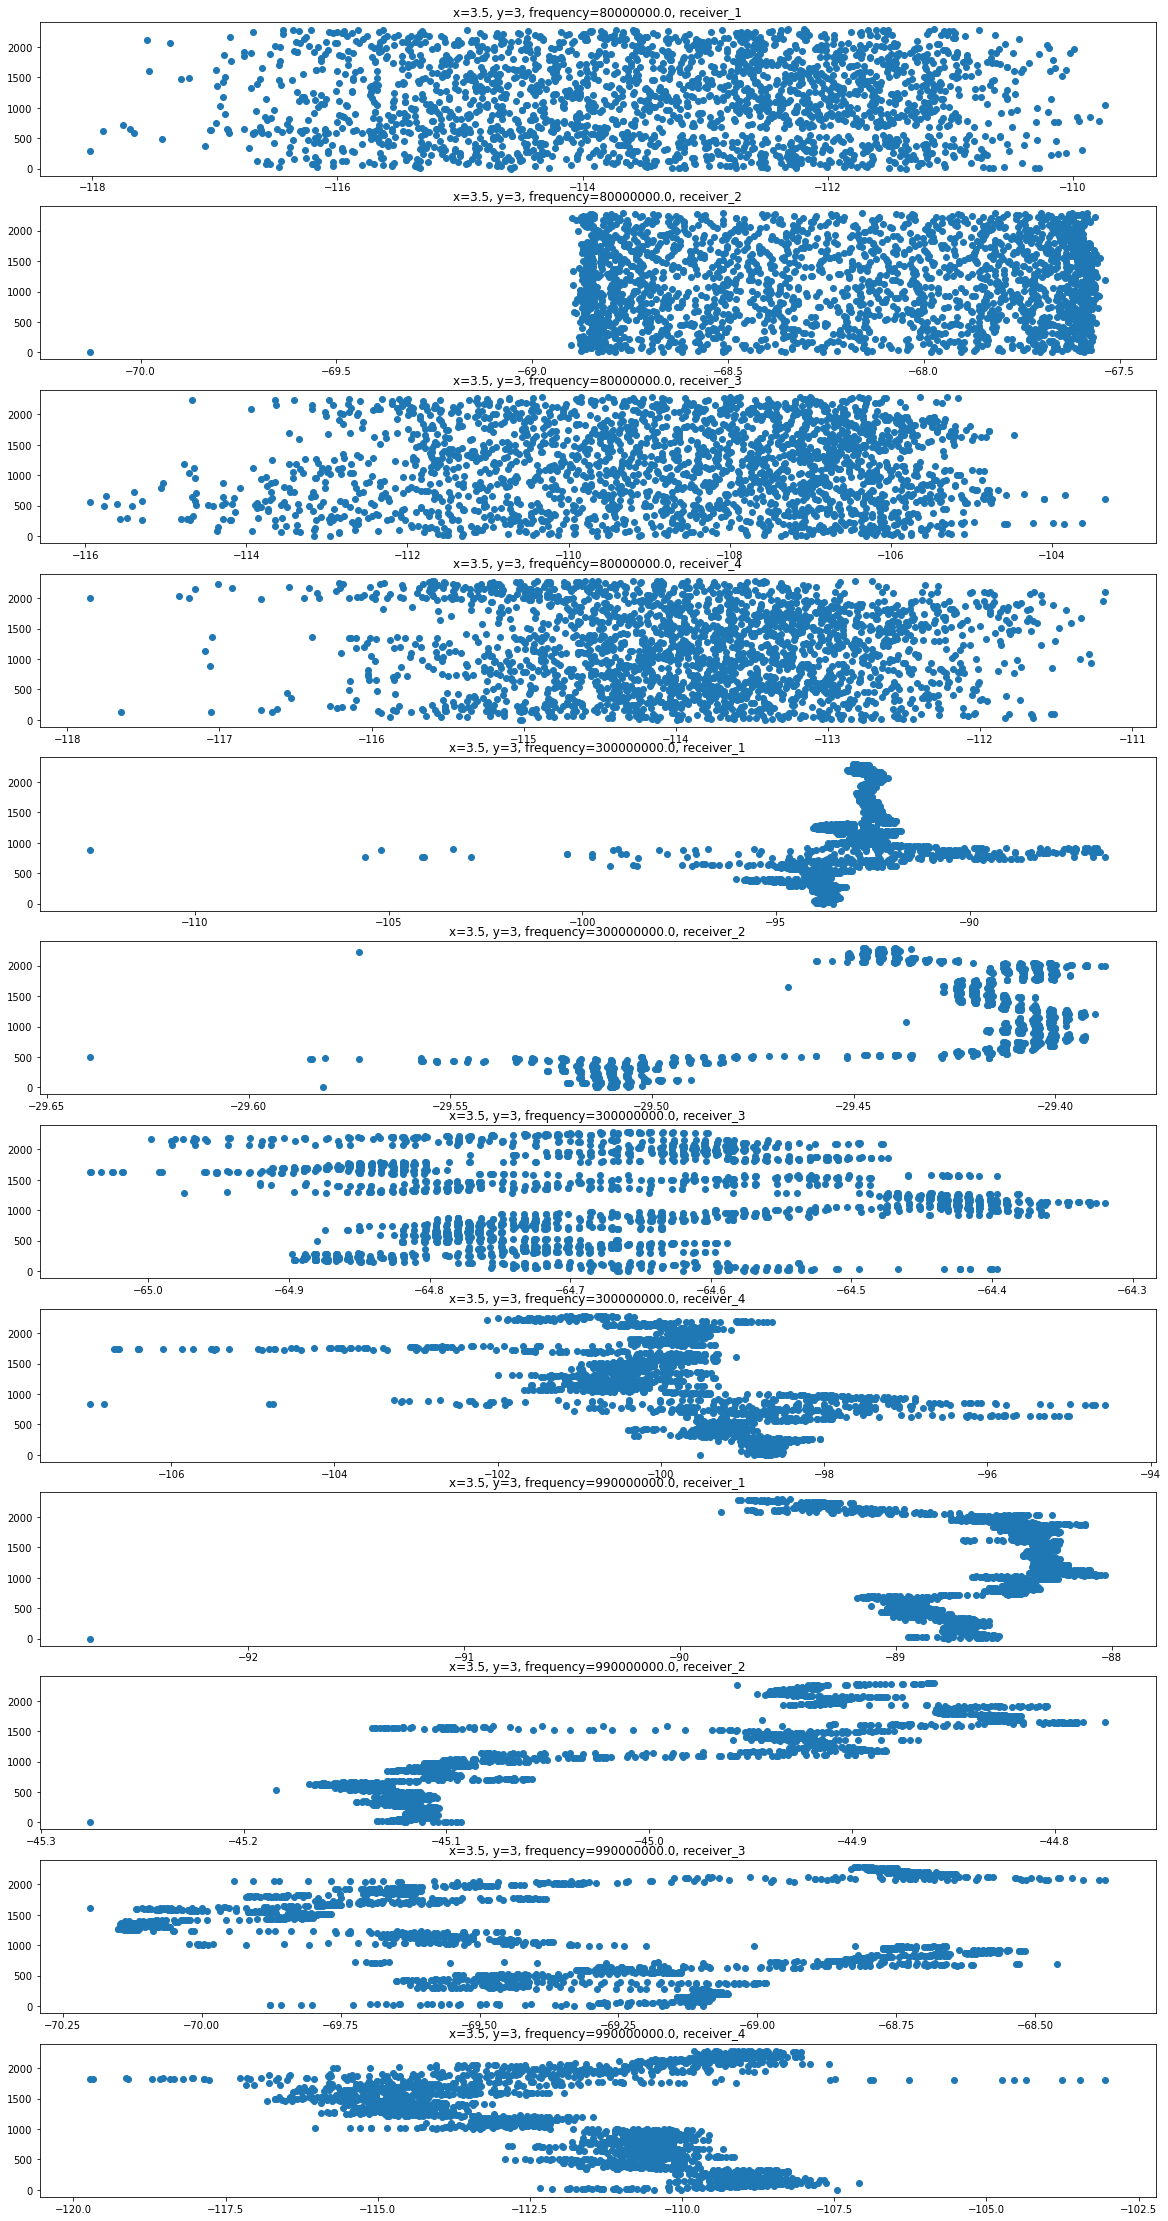

In [5]:
fig, axs = plt.subplots(12,1, figsize=(20,40))
frequencies = [8e7,30e7,99e7]
x=0
for f in frequencies:         
    for i in range(4):
        datasize=np.arange(0,data[(data["position_x"]==3.5) & (data["position_y"]==3) & (data["frequency"]==f)].iloc[:,i+4].values.size)
        axs[x].scatter(data[(data["position_x"]==3.5) & (data["position_y"]==3) & (data["frequency"]==f)].iloc[:,i+4],datasize)
        axs[x].set_title('x=3.5, y=3, frequency='+str(f)+', receiver_'+str(i+1))
        x+=1

### Normality tests

x=4 and y=8 distributions are shown.

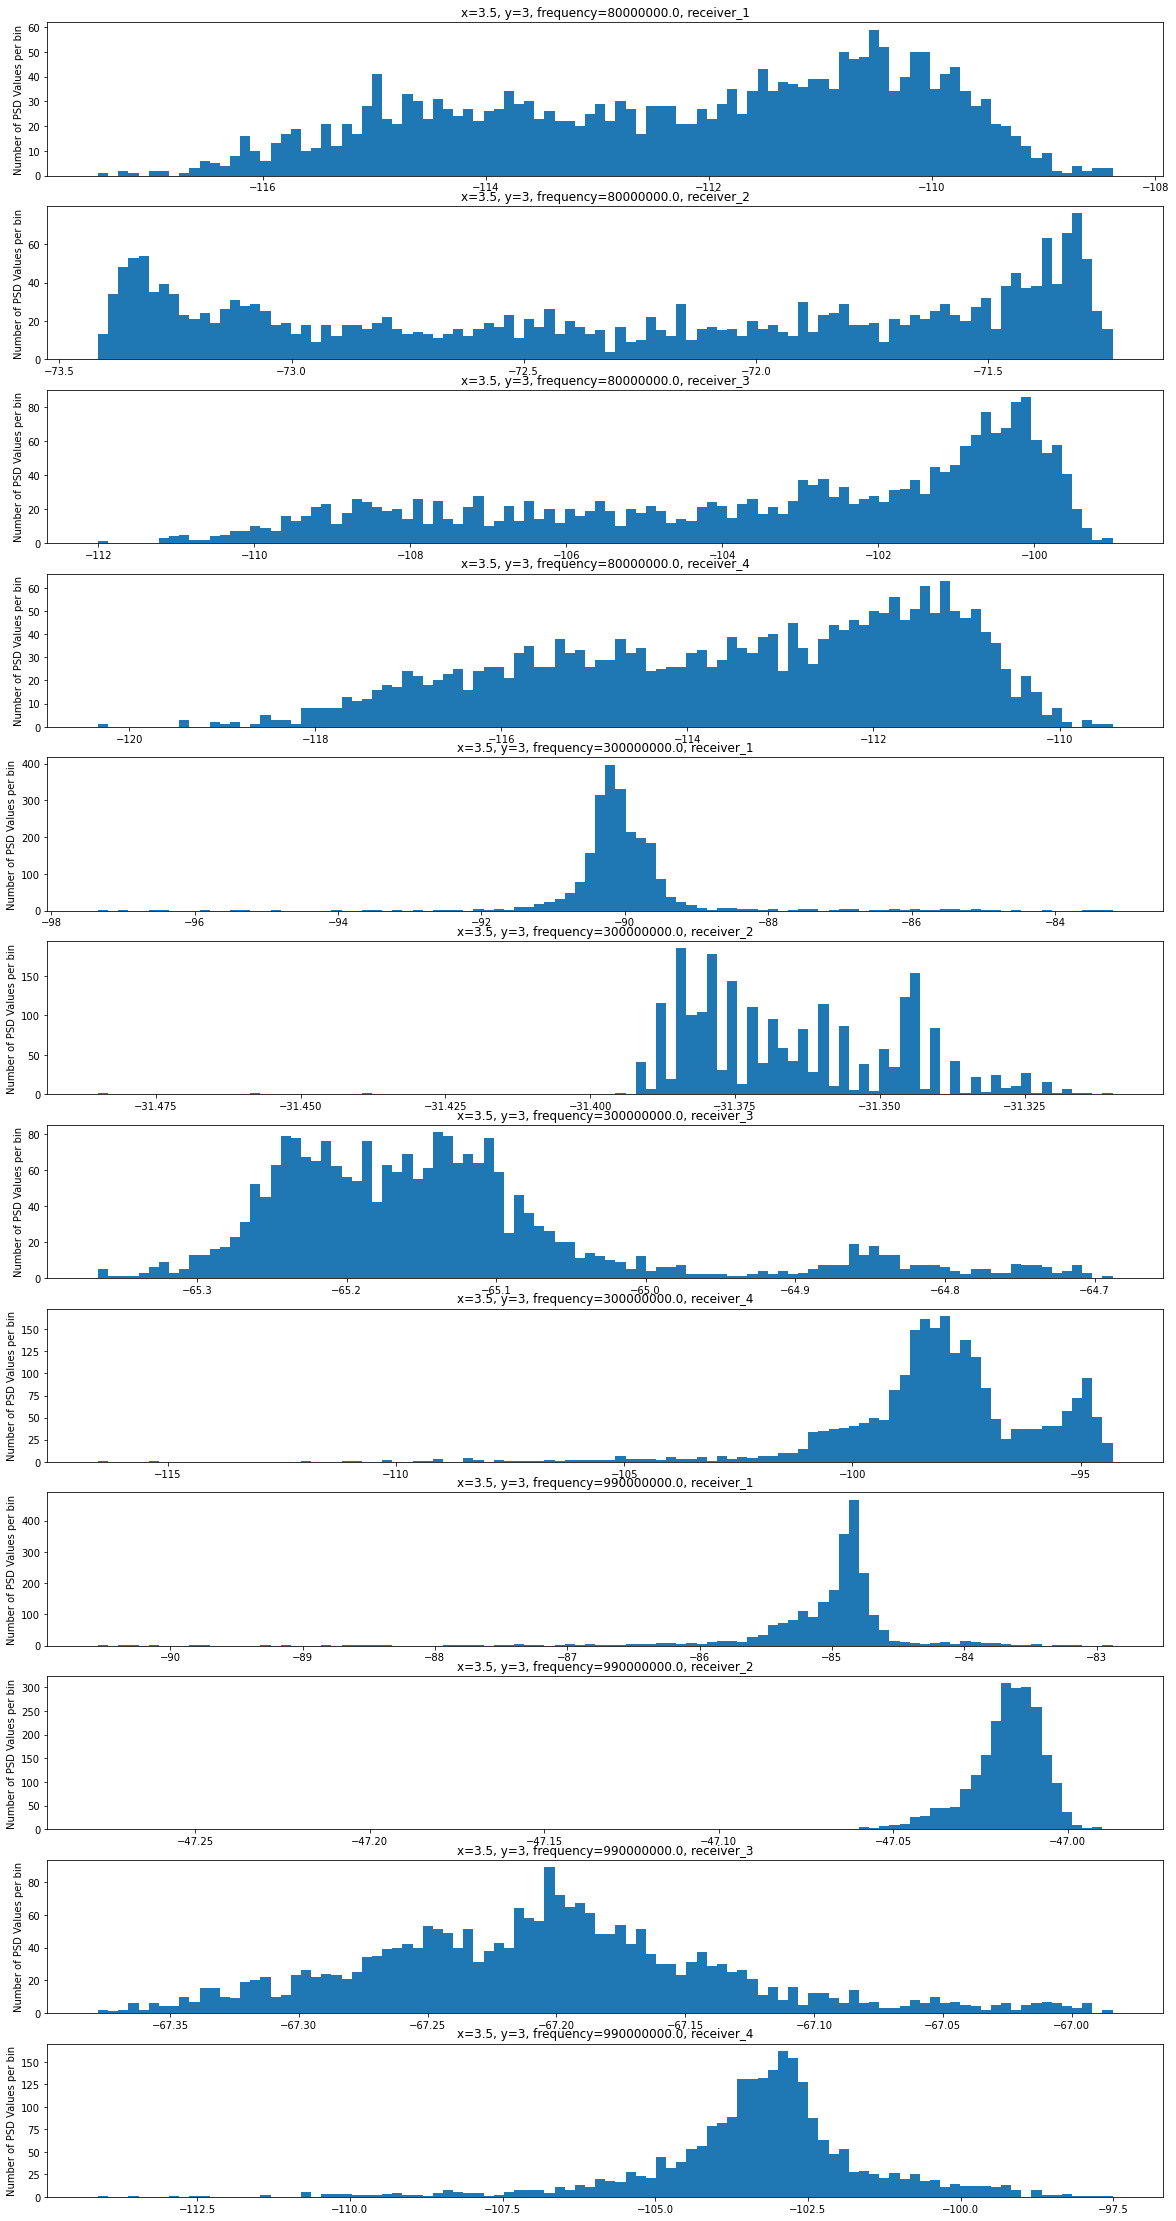

In [6]:
fig, axs = plt.subplots(12,1, figsize=(20,40))
frequencies = [8e7,30e7,99e7]
x=0
for f in frequencies:         
    for i in range(4):
        axs[x].hist(data[(data["position_x"]==4) & (data["position_y"]==8) & (data["frequency"]==f)].iloc[:,i+4],bins=100)
        axs[x].set_ylabel('Number of PSD Values per bin')
        axs[x].set_title('x=3.5, y=3, frequency='+str(f)+', receiver_'+str(i+1))
        x+=1

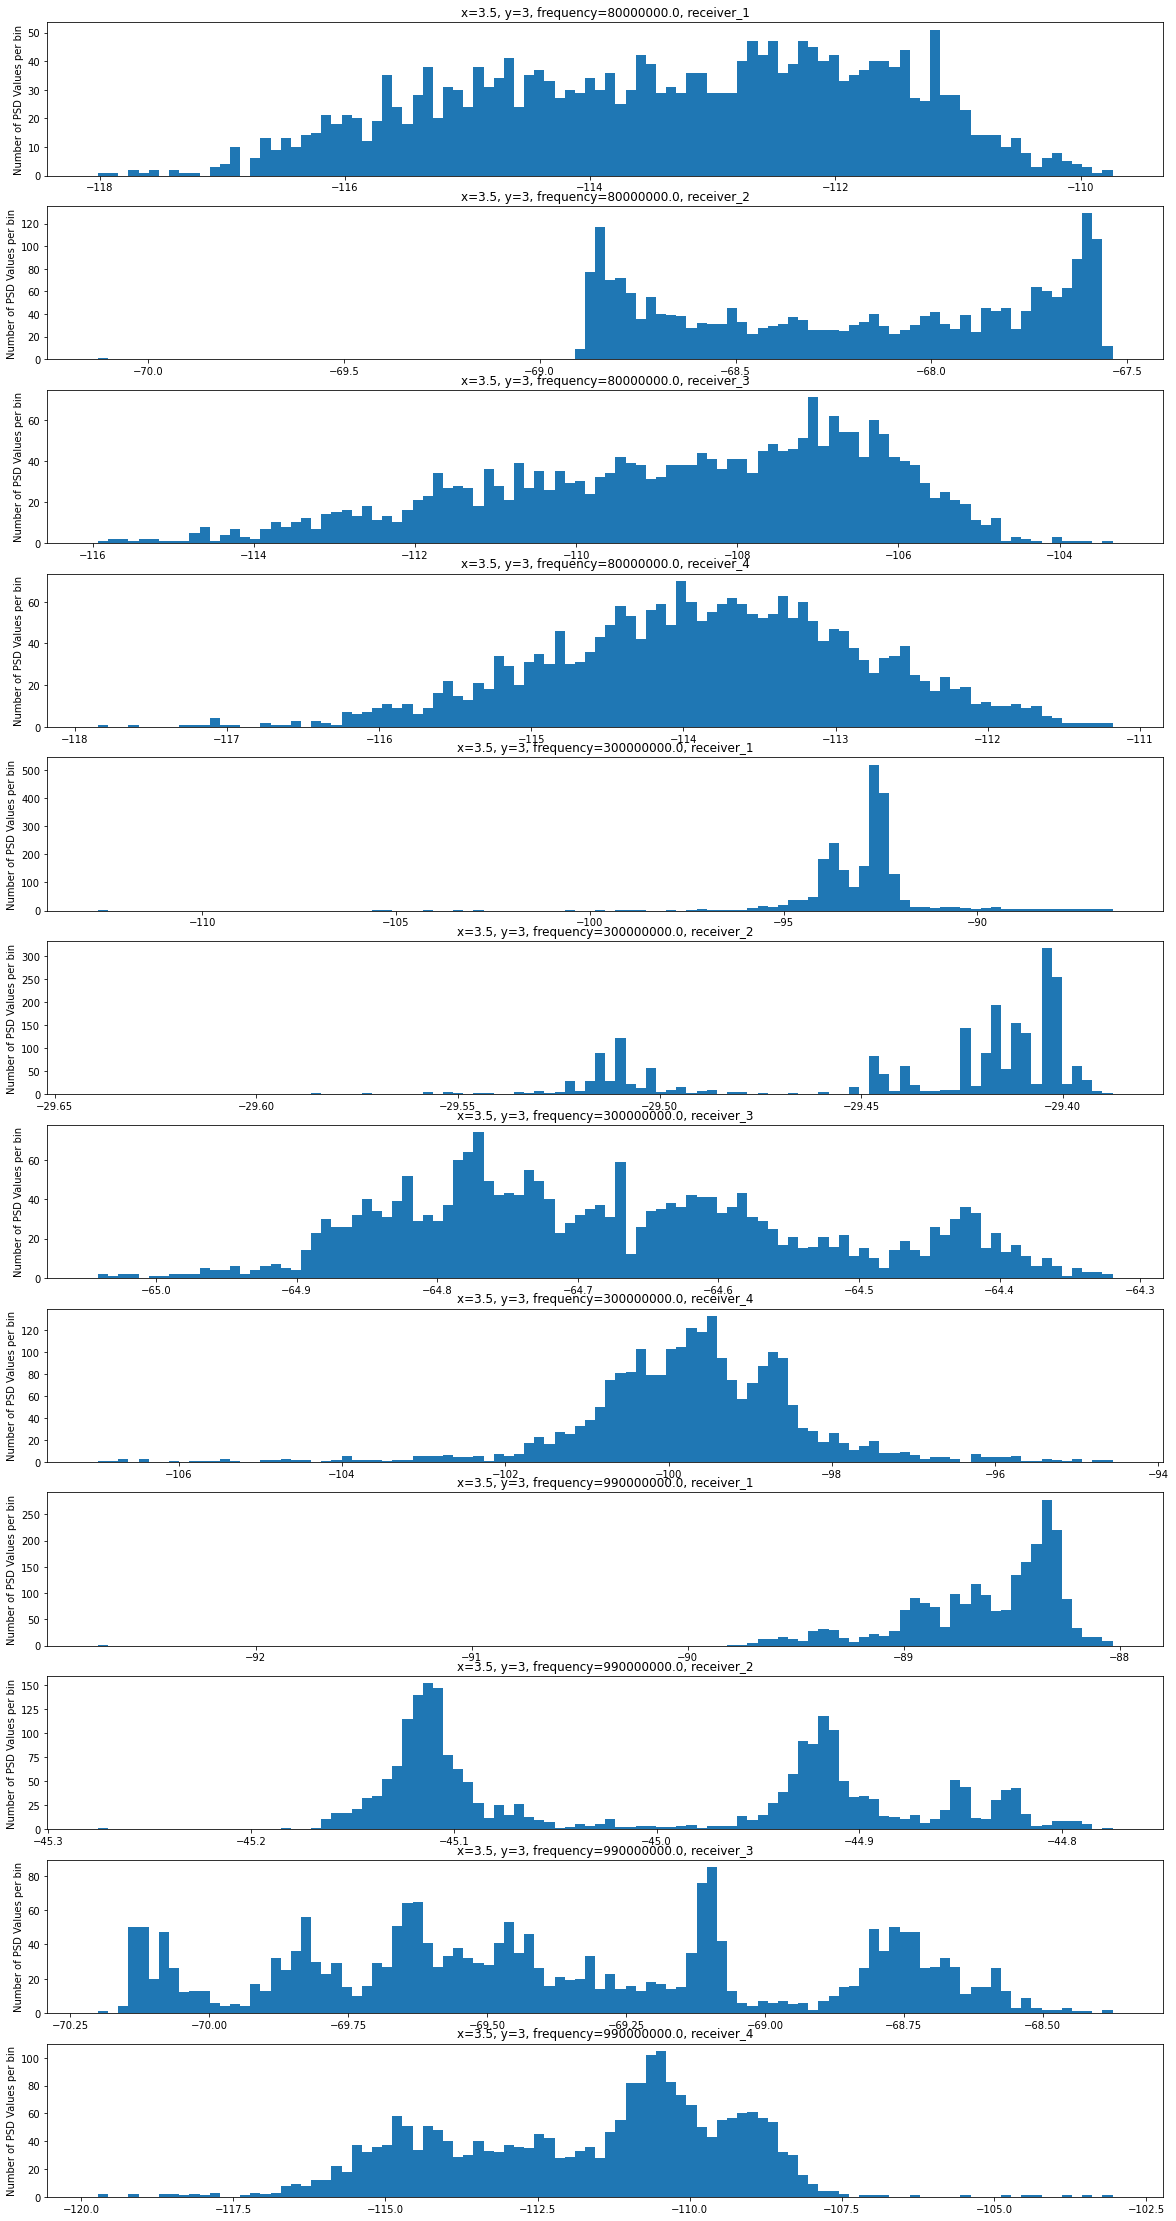

In [7]:
fig, axs = plt.subplots(12,1, figsize=(20,40))
frequencies = [8e7,30e7,99e7]
x=0
for f in frequencies:         
    for i in range(4):
        axs[x].hist(data[(data["position_x"]==3.5) & (data["position_y"]==3) & (data["frequency"]==f)].iloc[:,i+4],bins=100)
        axs[x].set_ylabel('Number of PSD Values per bin')
        axs[x].set_title('x=3.5, y=3, frequency='+str(f)+', receiver_'+str(i+1))
        x+=1

qqplot is another way to show how the distribution is related with Gaussian distribution.

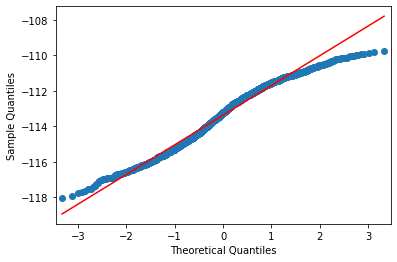

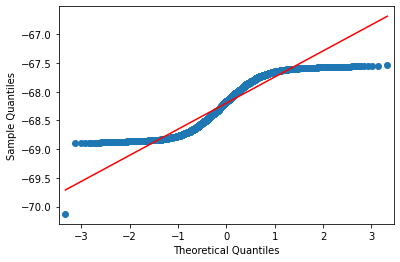

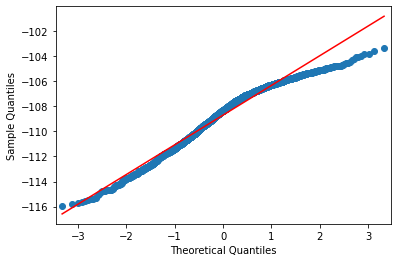

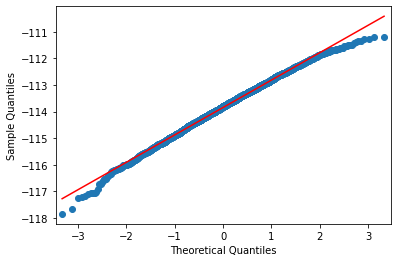

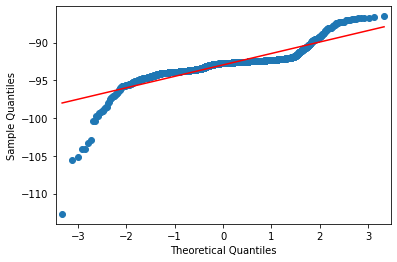

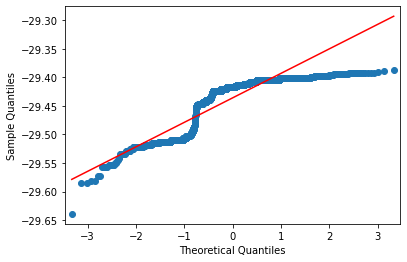

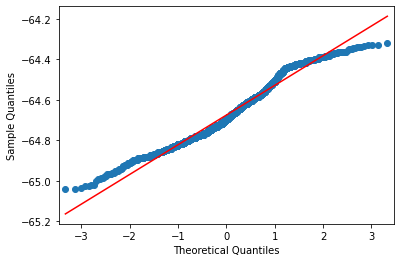

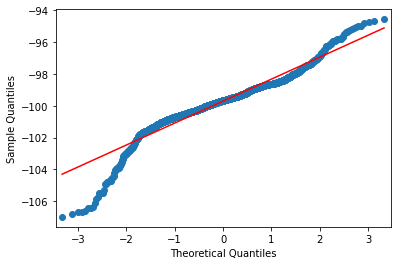

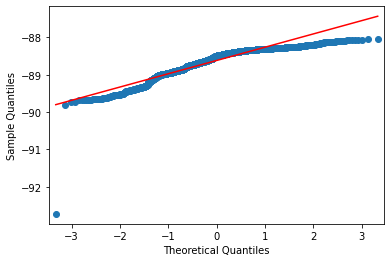

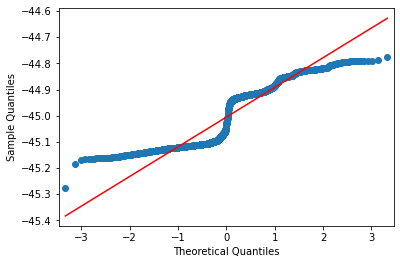

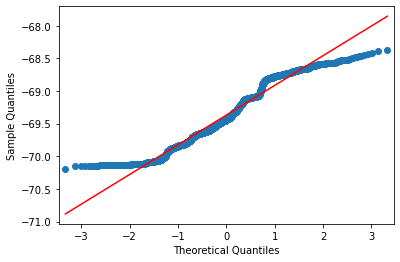

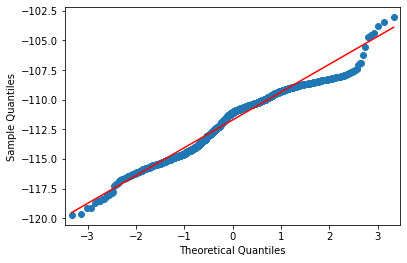

In [8]:
for f in frequencies:        
    for i in range(4):
        qqplot(data[(data["position_x"]==3.5) & (data["position_y"]==3) & (data["frequency"]==f)].iloc[:,i+4], line='s')

In [9]:
for f in frequencies:         
    for i in range(4):
        print(shapiro(data[(data["position_x"]==3.5) & (data["position_y"]==3) & (data["frequency"]==f)].iloc[:,i+4]))

ShapiroResult(statistic=0.9779629707336426, pvalue=2.433823235686971e-18)
ShapiroResult(statistic=0.9048156142234802, pvalue=1.3652768519146215e-35)
ShapiroResult(statistic=0.9671626687049866, pvalue=1.9071765039709887e-22)
ShapiroResult(statistic=0.9962984323501587, pvalue=2.100545316352509e-05)
ShapiroResult(statistic=0.7600904107093811, pvalue=0.0)
ShapiroResult(statistic=0.7736412882804871, pvalue=0.0)
ShapiroResult(statistic=0.9719952344894409, pvalue=9.391346617006783e-21)
ShapiroResult(statistic=0.9319307208061218, pvalue=4.175787105448647e-31)
ShapiroResult(statistic=0.8776126503944397, pvalue=3.6676731213174524e-39)
ShapiroResult(statistic=0.8620590567588806, pvalue=6.343538018152014e-41)
ShapiroResult(statistic=0.9587752819061279, pvalue=5.477918165107781e-25)
ShapiroResult(statistic=0.9638516902923584, pvalue=1.6777045659246314e-23)


Since the p-value is less than .05, we reject the null hypothesis of the Shapiro-Wilk test. Data is most likely nongaussian

Most of the received values are Gaussian but sometimes the distribution like above position x=3.5 and y=3 on receiver 2 can be nongaussian. 

This data will be used for all the models

In [10]:
data

,Unnamed: 0,frequency,position_x,position_y,receiver_1,receiver_2,receiver_3,receiver_4
0,0,80000000.0,3.5,3.0,-114.579575,-70.127907,-107.050392,-112.772629
1,1,80000000.0,3.5,3.0,-111.364632,-68.144577,-109.648026,-115.011749
2,2,80000000.0,3.5,3.0,-110.275764,-68.512436,-112.961052,-115.024254
3,3,80000000.0,3.5,3.0,-110.312576,-68.787834,-113.154762,-114.123688
4,4,80000000.0,3.5,3.0,-112.499069,-68.832184,-111.322098,-113.994385
...,...,...,...,...,...,...,...,...
267925,267925,990000000.0,16.0,27.0,-57.256004,-93.571815,-75.603081,-69.626663
267926,267926,990000000.0,16.0,27.0,-57.196037,-93.618988,-75.584007,-69.693550
267927,267927,990000000.0,16.0,27.0,-57.111420,-93.666595,-75.626625,-69.746071
267928,267928,990000000.0,16.0,27.0,-56.964897,-93.652969,-75.625092,-69.705360


Substracted data is shown here

In [11]:
data["r12"]=data["receiver_1"]-data["receiver_2"]
data["r13"]=data["receiver_1"]-data["receiver_3"]
data["r14"]=data["receiver_1"]-data["receiver_4"]
data.drop(columns=['receiver_1','receiver_2','receiver_3','receiver_4'],inplace=True)
PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(data.iloc[:])
temp_train=PredictorScalerFit.transform(temp_train)
temp_val=PredictorScalerFit.transform(temp_val)


In [5]:
data

,position_x,position_y,frequency,r12,r13,r14
0,3.5,3.0,80000000.0,-44.451668,-7.529182,-1.806946
1,3.5,3.0,80000000.0,-43.220055,-1.716606,3.647118
2,3.5,3.0,80000000.0,-41.763329,2.685287,4.748489
3,3.5,3.0,80000000.0,-41.524742,2.842186,3.811111
4,3.5,3.0,80000000.0,-43.666885,-1.176971,1.495316
...,...,...,...,...,...,...
267925,16.0,27.0,990000000.0,36.315811,18.347076,12.370659
267926,16.0,27.0,990000000.0,36.422951,18.387970,12.497513
267927,16.0,27.0,990000000.0,36.555176,18.515205,12.634651
267928,16.0,27.0,990000000.0,36.688072,18.660194,12.740463


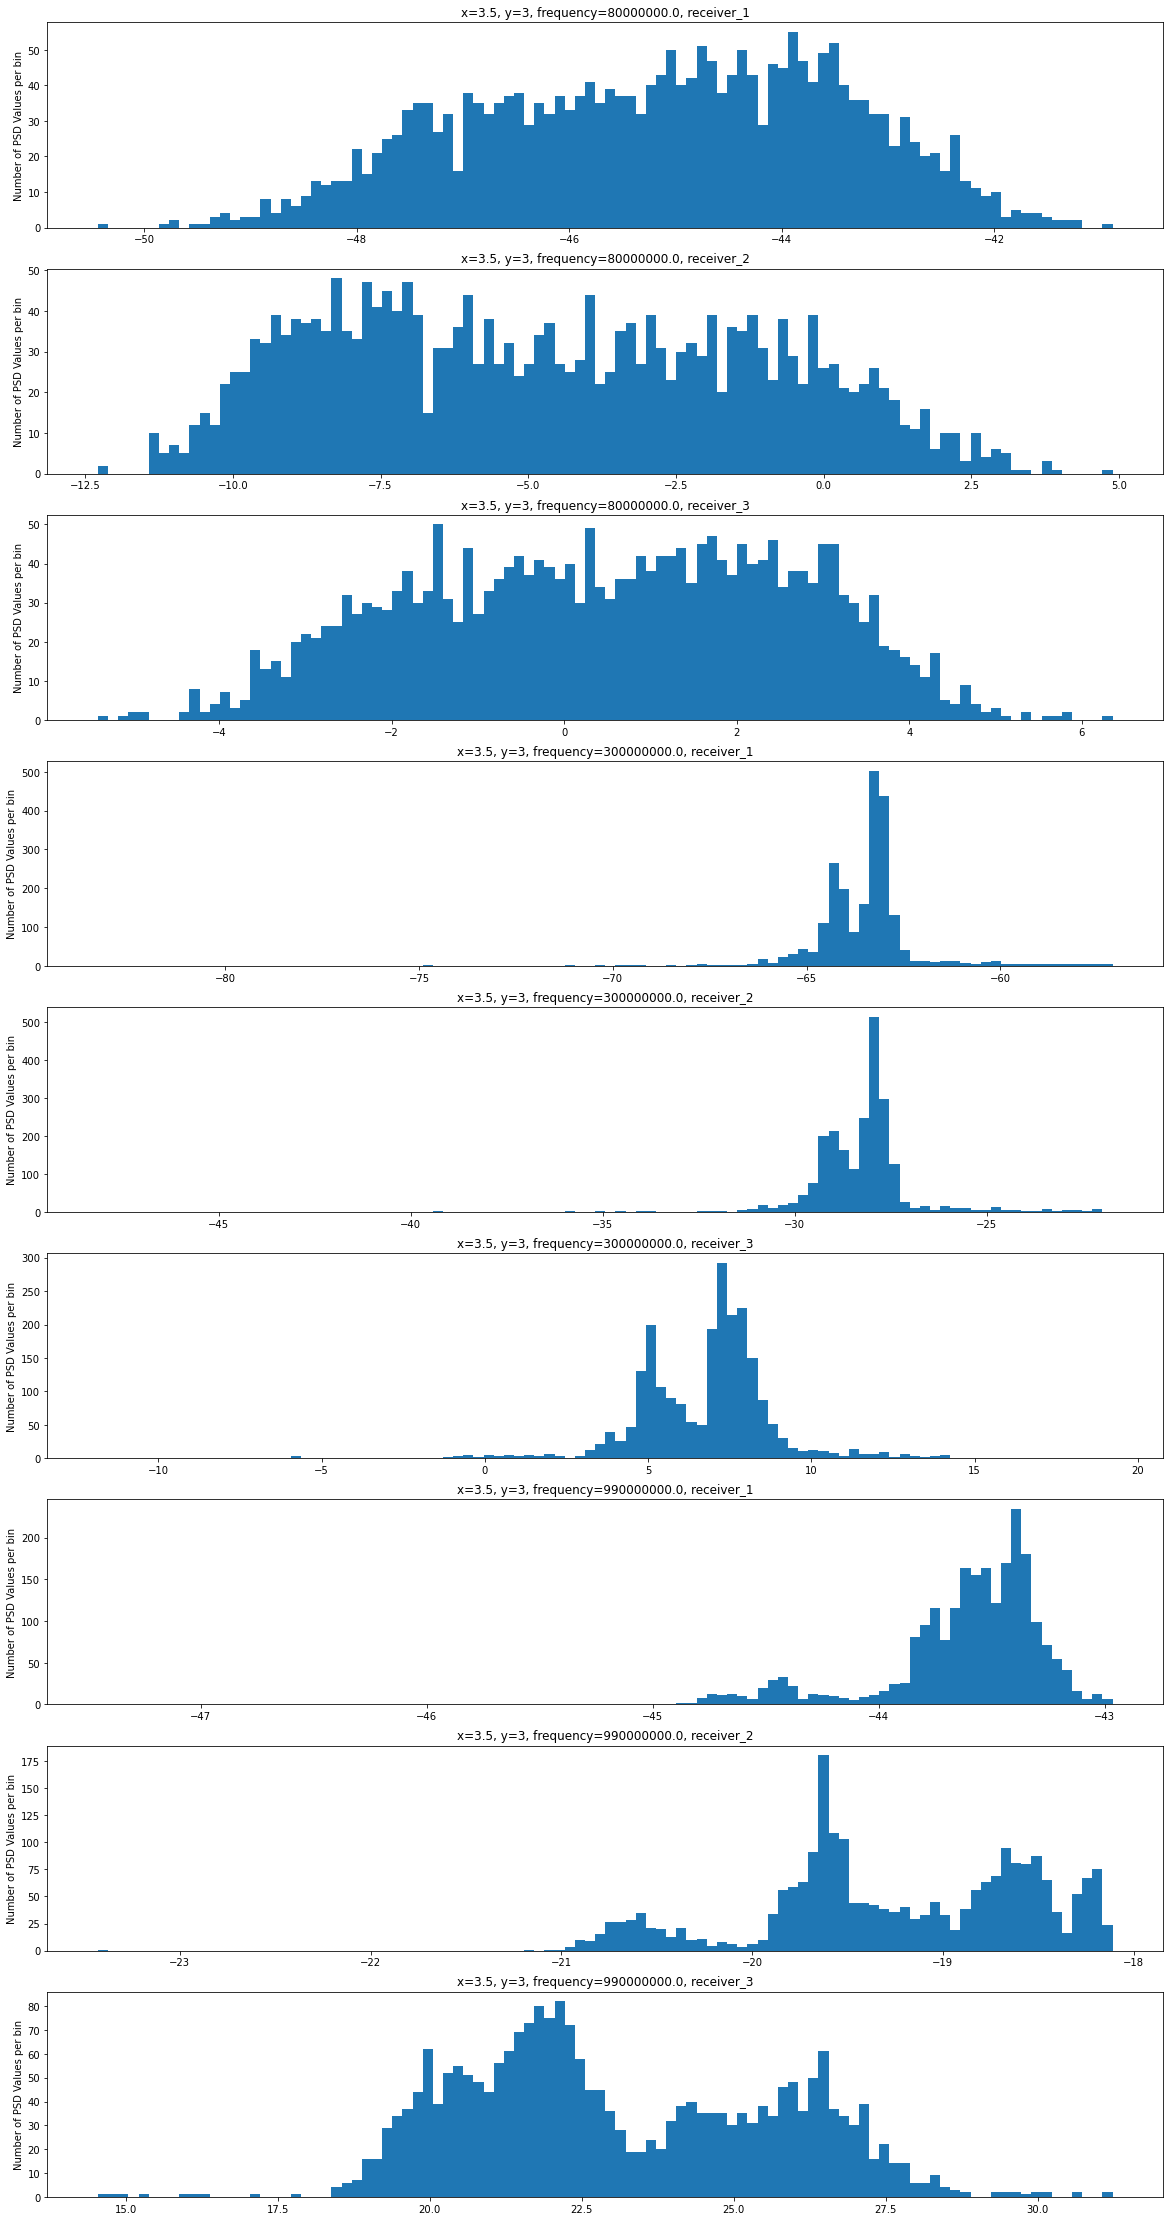

In [13]:
fig, axs = plt.subplots(9,1, figsize=(20,40))
frequencies = [8e7,30e7,99e7]
x=0
for f in frequencies:         
    for i in range(3):
        axs[x].hist(data[(data["position_x"]==3.5) & (data["position_y"]==3) & (data["frequency"]==f)].iloc[:,i+4],bins=100)
        axs[x].set_ylabel('Number of PSD Values per bin')
        axs[x].set_title('x=3.5, y=3, frequency='+str(f)+', receiver_'+str(i+1))
        x+=1

In [14]:
for f in frequencies:         
    for i in range(3):
        print(shapiro(data[(data["position_x"]==3.5) & (data["position_y"]==3) & (data["frequency"]==f)].iloc[:,i+4]))

ShapiroResult(statistic=0.9853293895721436, pvalue=1.3048325712018e-14)
ShapiroResult(statistic=0.9694420695304871, pvalue=1.1324227793853826e-21)
ShapiroResult(statistic=0.9832610487937927, pvalue=9.066696783342786e-16)
ShapiroResult(statistic=0.7497147917747498, pvalue=0.0)
ShapiroResult(statistic=0.7618526220321655, pvalue=0.0)
ShapiroResult(statistic=0.8996824026107788, pvalue=2.5340776506304155e-36)
ShapiroResult(statistic=0.8508607745170593, pvalue=4.275361614655017e-42)
ShapiroResult(statistic=0.9511348009109497, pvalue=5.5422832677021476e-27)
ShapiroResult(statistic=0.9655793309211731, pvalue=5.836350804131654e-23)


A test from validation choice.

72/72 [==============================] - 0s 972us/step
Prediced Locations
[[0.8560479 0.       ]
 [0.        0.       ]
 [0.        0.       ]
 ...
 [0.        0.       ]
 [0.        0.       ]
 [0.        0.       ]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 80000000.0 4.493447956301926
72/72 [==============================] - 0s 972us/step
Prediced Locations
[[8.364591  8.207861 ]
 [8.5865555 8.715502 ]
 [8.607993  8.607382 ]
 ...
 [8.010286  7.5927763]
 [8.071913  7.7721553]
 [8.116058  8.011744 ]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 300000000.0 7.250228122418749
72/72 [==============================] - 0s 972us/step
Prediced Locations
[[8.277023  2.5679317]
 [6.904008  6.5316267]
 [6.9390354 6.314358 ]
 ...
 [7.3941107 5.185783 ]
 [7.3575907 5.3332286]
 [7.4312267 5.034473 ]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]


72/72 [==============================] - 0s 972us/step
Prediced Locations
[[ 5.044352  19.977903 ]
 [11.647337  13.94438  ]
 [11.681856  13.914091 ]
 ...
 [11.917151  15.208511 ]
 [11.757179  15.1364155]
 [11.6574    15.0742035]]
Real Locations
[[ 9. 21.]
 [ 9. 21.]
 [ 9. 21.]
 ...
 [ 9. 21.]
 [ 9. 21.]
 [ 9. 21.]]
5 (9.0, 21.0) 990000000.0 7.269871669045225
72/72 [==============================] - 0s 971us/step
Prediced Locations
[[11.921815   9.2488365]
 [16.596031  11.445648 ]
 [18.570354  12.191832 ]
 ...
 [16.85397   10.920006 ]
 [15.898595   9.475193 ]
 [15.517434   8.553204 ]]
Real Locations
[[11.  9.]
 [11.  9.]
 [11.  9.]
 ...
 [11.  9.]
 [11.  9.]
 [11.  9.]]
6 (11.0, 9.0) 80000000.0 6.863805090786231
72/72 [==============================] - 0s 972us/step
Prediced Locations
[[ 2.7834904 15.415119 ]
 [ 2.5308473 15.870174 ]
 [ 2.5575788 15.8633995]
 ...
 [ 3.536351  16.180225 ]
 [ 3.4927723 16.118483 ]
 [ 3.5080853 15.994917 ]]
Real Locations
[[11.  9.]
 [11.  9.]
 [11.  9.]
 

72/72 [==============================] - 0s 752us/step
Prediced Locations
[[15.780442 21.67522 ]
 [15.740163 21.50091 ]
 [15.741834 21.499983]
 ...
 [15.630728 21.530462]
 [15.62647  21.534277]
 [15.62963  21.53635 ]]
Real Locations
[[14. 14.]
 [14. 14.]
 [14. 14.]
 ...
 [14. 14.]
 [14. 14.]
 [14. 14.]]
11 (14.0, 14.0) 300000000.0 7.761772703824862
72/72 [==============================] - 0s 881us/step
Prediced Locations
[[20.18612  11.084307]
 [19.303904 11.120544]
 [19.333448 11.12027 ]
 ...
 [18.35096  10.951792]
 [18.320456 10.976908]
 [18.321438 11.003767]]
Real Locations
[[14. 14.]
 [14. 14.]
 [14. 14.]
 ...
 [14. 14.]
 [14. 14.]
 [14. 14.]]
11 (14.0, 14.0) 990000000.0 6.228169961338483
72/72 [==============================] - 0s 943us/step
Prediced Locations
[[18.046545   5.0222654]
 [16.141006   6.8345904]
 [16.621117   7.902005 ]
 ...
 [18.560593   7.6002593]
 [17.866106   7.0238786]
 [18.265547   7.753264 ]]
Real Locations
[[15.33  2.  ]
 [15.33  2.  ]
 [15.33  2.  ]
 ...
 [1

72/72 [==============================] - 0s 972us/step
Prediced Locations
[[13.881075 31.586514]
 [17.144358 26.957512]
 [17.158575 27.154308]
 ...
 [17.713642 30.062067]
 [17.382948 28.999805]
 [16.852749 27.734688]]
Real Locations
[[19. 37.]
 [19. 37.]
 [19. 37.]
 ...
 [19. 37.]
 [19. 37.]
 [19. 37.]]
17 (19.0, 37.0) 80000000.0 7.8617987081745415
72/72 [==============================] - 0s 1ms/step
Prediced Locations
[[15.917278  34.89351  ]
 [15.7962675 35.07914  ]
 [15.795088  35.088024 ]
 ...
 [15.414735  35.298187 ]
 [15.41153   35.32222  ]
 [15.383144  35.317482 ]]
Real Locations
[[19. 37.]
 [19. 37.]
 [19. 37.]
 ...
 [19. 37.]
 [19. 37.]
 [19. 37.]]
17 (19.0, 37.0) 300000000.0 3.7272189743008552
72/72 [==============================] - 0s 880us/step
Prediced Locations
[[28.64974  21.350252]
 [23.729141 35.823803]
 [23.74509  35.808548]
 ...
 [24.193275 35.787636]
 [24.176777 35.81974 ]
 [24.151707 35.850037]]
Real Locations
[[19. 37.]
 [19. 37.]
 [19. 37.]
 ...
 [19. 37.]
 [19.

72/72 [==============================] - 0s 880us/step
Prediced Locations
[[28.68665  19.102201]
 [27.971794 19.1838  ]
 [27.99595  19.251793]
 ...
 [25.210947 21.718725]
 [25.158745 21.66613 ]
 [25.255283 21.681974]]
Real Locations
[[26. 26.]
 [26. 26.]
 [26. 26.]
 ...
 [26. 26.]
 [26. 26.]
 [26. 26.]]
28 (26.0, 26.0) 300000000.0 7.018714492484033
72/72 [==============================] - 0s 880us/step
Prediced Locations
[[43.60185  26.681763]
 [36.579765 22.528603]
 [36.55946  22.513039]
 ...
 [33.898365 21.353584]
 [33.978622 21.404676]
 [33.98921  21.375502]]
Real Locations
[[26. 26.]
 [26. 26.]
 [26. 26.]
 ...
 [26. 26.]
 [26. 26.]
 [26. 26.]]
28 (26.0, 26.0) 990000000.0 9.635971790812532
72/72 [==============================] - 0s 972us/step
Prediced Locations
[[ 0.       40.137623]
 [ 0.       37.880928]
 [ 0.       37.65481 ]
 ...
 [ 0.       37.981346]
 [ 0.       37.58526 ]
 [ 0.       37.549343]]
Real Locations
[[26. 38.]
 [26. 38.]
 [26. 38.]
 ...
 [26. 38.]
 [26. 38.]
 [26.

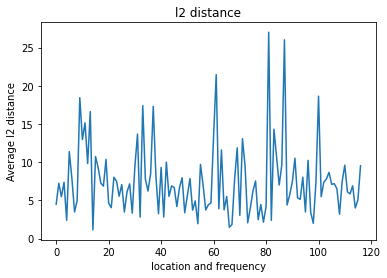

In [83]:
def create_deep(inp_dim):
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(50, input_dim=inp_dim, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(.001), metrics=['mse'])
    return model

frequencies = [8e7,30e7,99e7]
es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)

def iterated_position_estimation(data):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
    
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == a[k][0])&(data['position_y'] == a[k][1])
        
        if k==38:
            k=-1
            
        frequencies = data.loc[temp_filter].iloc[:,1].values
        frequencies = pd.Series(frequencies).drop_duplicates().tolist()
        for f in frequencies:
            reg=create_deep(4)
            temp_filter_not = (data['position_x'] != a[k][0])&(data['position_y'] != a[k][1])&(data['position_x'] != realdicc[(a[k][0], a[k][1])][f][0][0])&(data['position_y'] != realdicc[(a[k][0], a[k][1])][f][0][1])
            val_temp_filter= (data['position_x'] == realdicc[(a[k][0], a[k][1])][f][0][0])&(data['position_y'] == realdicc[(a[k][0], a[k][1])][f][0][1])
            
            temp_train = data.loc[temp_filter_not].loc[data['frequency'] == f].iloc[:,4:]
            temp_val= data.loc[val_temp_filter].loc[data['frequency'] == f].iloc[:,4:]            
            temp_test = data.loc[temp_filter].loc[data['frequency'] == f].iloc[:,4:]
            
            locations = data.loc[data['frequency'] == f].loc[temp_filter].iloc[:,2:4].values
            locations_val = data.loc[data['frequency'] == f].loc[val_temp_filter].iloc[:,2:4].values
            locations_not = data.loc[data['frequency'] == f].loc[temp_filter_not].iloc[:,2:4].values
            #regr1.fit(temp_train,x_coordinates_not)
            #regr2.fit(temp_train,y_coordinates_not)
            
            PredictorScaler=StandardScaler()
            PredictorScalerFit=PredictorScaler.fit(temp_train)
            temp_train=PredictorScalerFit.transform(temp_train)
            temp_val=PredictorScalerFit.transform(temp_val)
            temp_test=PredictorScalerFit.transform(temp_test)

            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
            
            hist=reg.fit(temp_train,locations_not,validation_data=(temp_val, locations_val), epochs=1, batch_size=50,  callbacks = [es])
            #temp_pred_x = regr1.predict(temp_test)
            #temp_pred_y = regr2.predict(temp_test)
            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            
    plt.plot(l2)
    plt.title("l2 distance")
    plt.xlabel("location and frequency")
    plt.ylabel("Average l2 distance")
    print(np.mean(l2))
iterated_position_estimation(data)

# Data Shift Testing

This part is explained in master thesis Chapter 3.2

In [126]:
data=pd.read_csv("labeled_data.csv")

In [128]:
data

,Unnamed: 0,frequency,position_x,position_y,receiver_1,receiver_2,receiver_3,receiver_4
0,0,80000000.0,3.5,3.0,-114.579575,-70.127907,-107.050392,-112.772629
1,1,80000000.0,3.5,3.0,-111.364632,-68.144577,-109.648026,-115.011749
2,2,80000000.0,3.5,3.0,-110.275764,-68.512436,-112.961052,-115.024254
3,3,80000000.0,3.5,3.0,-110.312576,-68.787834,-113.154762,-114.123688
4,4,80000000.0,3.5,3.0,-112.499069,-68.832184,-111.322098,-113.994385
...,...,...,...,...,...,...,...,...
267925,267925,990000000.0,16.0,27.0,-57.256004,-93.571815,-75.603081,-69.626663
267926,267926,990000000.0,16.0,27.0,-57.196037,-93.618988,-75.584007,-69.693550
267927,267927,990000000.0,16.0,27.0,-57.111420,-93.666595,-75.626625,-69.746071
267928,267928,990000000.0,16.0,27.0,-56.964897,-93.652969,-75.625092,-69.705360


In [130]:
temp_filter_not = (data['position_x'] != data.iloc[0,2])&(data['position_y'] != data.iloc[0,3])
#posätäon x and position y are grouped.
temp_filter = (data['position_x'] == data.iloc[0,2])&(data['position_y'] == data.iloc[0,3])
frequencies = data.loc[temp_filter].iloc[:,1].values
frequencies = pd.Series(frequencies).drop_duplicates().tolist()
temp_train = data.loc[temp_filter_not].loc[data['frequency'] == 8e7].iloc[:,4:]
#with given frequency and given position receiver1 values
temp_test = data.loc[temp_filter].loc[data['frequency'] == 8e7].iloc[:,4:]
temp_train["indication"]=0
temp_test["indication"]=1
dataa=pd.concat([temp_train,temp_test])
X=dataa.iloc[:,:4]
y=dataa.iloc[:,4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
model=LogisticRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

1.0

Model score is 1. There is %100 dataset shift.

In [ ]:
AUC

In [135]:
temp_train

,receiver_1,receiver_2,receiver_3,receiver_4
6870,-115.835083,-92.615349,-109.157608,-111.758690
6871,-112.040253,-87.469490,-104.335480,-110.568634
6872,-112.113831,-87.771210,-101.639938,-111.452873
6873,-110.657005,-90.793846,-100.907318,-111.097809
6874,-110.526772,-89.807961,-100.837387,-111.832413
...,...,...,...,...
263345,-82.294815,-101.508881,-106.460884,-104.667007
263346,-82.363800,-101.862869,-105.247261,-107.454468
263347,-82.370407,-101.802376,-104.407776,-110.566650
263348,-82.266777,-101.692719,-104.234009,-109.987625


Text(0, 0.5, 'Number of PSD values per bin')

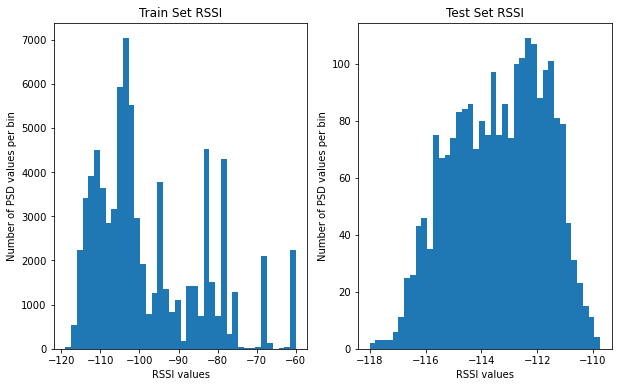

In [16]:
temp_filter_not = (data['position_x'] != data.iloc[0,2])&(data['position_y'] != data.iloc[0,3])
#posätäon x and position y are grouped.
temp_filter = (data['position_x'] == data.iloc[0,2])&(data['position_y'] == data.iloc[0,3])
frequencies = data.loc[temp_filter].iloc[:,1].values
frequencies = pd.Series(frequencies).drop_duplicates().tolist()
temp_train = data.loc[temp_filter_not].loc[data['frequency'] == 8e7].iloc[:,4:]
#with given frequency and given position receiver1 values
temp_test = data.loc[temp_filter].loc[data['frequency'] == 8e7].iloc[:,4:]
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.hist(temp_train.iloc[:,0],bins=40)
plt.title("Train Set RSSI")
plt.xlabel("RSSI values")
plt.ylabel("Number of PSD values per bin")

plt.subplot(1, 2, 2) # index 2
plt.hist(temp_test.iloc[:,0],bins=40)
plt.title("Test Set RSSI")
plt.xlabel("RSSI values")
plt.ylabel("Number of PSD values per bin")

Training and test distributions are different.

Text(0, 0.5, 'Number of PSD values per bin')

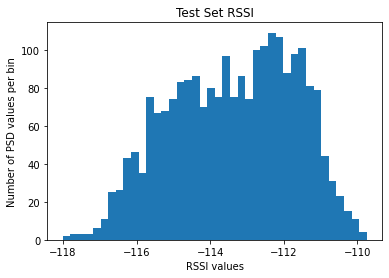

In [4]:
plt.figure(figsize=(10, 8))
plt.hist(temp_test.iloc[:,0],bins=40)
plt.title("Test Set RSSI")
plt.xlabel("RSSI values")
plt.ylabel("Number of PSD values per bin")

Train and test dataset has %100 different distribution, it can be realized with histograms also.

# Resampling Reweighting

It is explained in master thesis Chapter 4.3.

In [4]:
temp_filter_not = (data['position_x'] != data.iloc[0,2])&(data['position_y'] != data.iloc[0,3])
#posätäon x and position y are grouped.
temp_filter = (data['position_x'] == data.iloc[0,2])&(data['position_y'] == data.iloc[0,3])
frequencies = data.loc[temp_filter].iloc[:,1].values
frequencies = pd.Series(frequencies).drop_duplicates().tolist()
temp_train = data.loc[temp_filter_not].loc[data['frequency'] == 8e7].iloc[:,4:]
#with given frequency and given position receiver1 values
temp_test = data.loc[temp_filter].loc[data['frequency'] == 8e7].iloc[:,4:]
locations = data.loc[data['frequency'] == 8e7].loc[temp_filter].iloc[:,2:4].values
locations_not = data.loc[data['frequency'] == 8e7].loc[temp_filter_not].iloc[:,2:4].values
temp_train["indication"]=0
temp_test["indication"]=1
dataa=pd.concat([temp_train,temp_test])
X=dataa.iloc[:,:4]
y=dataa.iloc[:,4]
model=LogisticRegression()
model.fit(X,y)
conf_score = model.decision_function(temp_train.iloc[:,:4])
C = 10
conditions = [conf_score < -C,conf_score > C]
choices = [-C, C]
conf_score = np.select(conditions, choices, conf_score)
weights = np.exp(conf_score)
print(weights)
print(conf_score)


[4.53999298e-05 4.53999298e-05 4.53999298e-05 ... 4.53999298e-05
 4.53999298e-05 4.53999298e-05]
[-10. -10. -10. ... -10. -10. -10.]


In [6]:
temp_train.iloc[:,:4].shape

(77860, 4)

In [5]:
weights.shape

(77860,)

In [40]:
value, counts=np.unique(weights, return_counts=True)

In [41]:
value

array([4.53999298e-05, 4.60872793e-05, 4.61676812e-05, ...,
       2.65500540e-02, 2.74440619e-02, 3.51190030e-02])

In [42]:
counts

array([76784,     1,     1, ...,     1,     1,     1], dtype=int64)

Sample weigths are given so low. So this technique is not used.

Epoch 1/15
3779/3779 [==============================] - 7s 2ms/step - loss: 0.0044 - mse: 65.4605 - val_loss: 12.8514 - val_mse: 12.8514
Epoch 2/15
3779/3779 [==============================] - 6s 1ms/step - loss: 0.0025 - mse: 35.2849 - val_loss: 13.0233 - val_mse: 13.0233
Epoch 3/15
3779/3779 [==============================] - 5s 1ms/step - loss: 0.0021 - mse: 29.4639 - val_loss: 5.7639 - val_mse: 5.7639
Epoch 4/15
3779/3779 [==============================] - 5s 1ms/step - loss: 0.0018 - mse: 26.3199 - val_loss: 3.4570 - val_mse: 3.4570
Epoch 5/15
3779/3779 [==============================] - 5s 1ms/step - loss: 0.0017 - mse: 24.2553 - val_loss: 6.2149 - val_mse: 6.2149
Epoch 6/15
3779/3779 [==============================] - 5s 1ms/step - loss: 0.0014 - mse: 21.4057 - val_loss: 25.4495 - val_mse: 25.4495
Epoch 7/15
3779/3779 [==============================] - 5s 1ms/step - loss: 0.0014 - mse: 20.2319 - val_loss: 12.6582 - val_mse: 12.6582
Epoch 8/15
3779/3779 [=========================

3779/3779 [==============================] - 5s 1ms/step - loss: 10.7594 - mse: 91.4284 - val_loss: 35.6193 - val_mse: 35.6193
Epoch 13/15
3779/3779 [==============================] - 5s 1ms/step - loss: 6.5569 - mse: 104.3580 - val_loss: 85.5617 - val_mse: 85.5617
Epoch 14/15
3779/3779 [==============================] - 5s 1ms/step - loss: 9.8616 - mse: 92.1824 - val_loss: 28.5692 - val_mse: 28.5692
Epoch 15/15
72/72 [==============================] - 0s 970us/step
Prediced Locations
[[ 9.65859  14.020734]
 [ 9.446358 15.047955]
 [10.141753 16.094328]
 ...
 [ 9.246881 14.518623]
 [ 9.518384 14.14016 ]
 [ 9.398412 14.974598]]
Real Locations
[[ 3.5 12. ]
 [ 3.5 12. ]
 [ 3.5 12. ]
 ...
 [ 3.5 12. ]
 [ 3.5 12. ]
 [ 3.5 12. ]]
1 (3.5, 12.0) 80000000.0 6.458676173440108
Epoch 1/15
3779/3779 [==============================] - 6s 1ms/step - loss: 0.0015 - mse: 31.4995 - val_loss: 16.9205 - val_mse: 16.9205
Epoch 2/15
3779/3779 [==============================] - 7s 2ms/step - loss: 6.0932e-04 

4122/4122 [==============================] - 5s 1ms/step - loss: 4.7912 - mse: 54.9074 - val_loss: 9.6014 - val_mse: 9.6014
Epoch 7/15
4122/4122 [==============================] - 5s 1ms/step - loss: 6.1457 - mse: 49.3332 - val_loss: 2.9688 - val_mse: 2.9688
Epoch 8/15
4122/4122 [==============================] - 5s 1ms/step - loss: 4.8916 - mse: 53.5698 - val_loss: 22.0621 - val_mse: 22.0621
Epoch 9/15
4122/4122 [==============================] - 5s 1ms/step - loss: 4.2494 - mse: 48.1034 - val_loss: 16.2195 - val_mse: 16.2195
Epoch 10/15
4122/4122 [==============================] - 5s 1ms/step - loss: 5.1555 - mse: 50.4510 - val_loss: 39.6225 - val_mse: 39.6225
Epoch 11/15
4122/4122 [==============================] - 5s 1ms/step - loss: 4.4162 - mse: 44.2343 - val_loss: 24.2483 - val_mse: 24.2483
Epoch 12/15
4122/4122 [==============================] - 5s 1ms/step - loss: 4.3327 - mse: 42.5018 - val_loss: 26.5650 - val_mse: 26.5650
Epoch 13/15
4122/4122 [==============================

72/72 [==============================] - 0s 907us/step
Prediced Locations
[[ 7.6276426 13.550725 ]
 [ 7.704636  13.544602 ]
 [ 7.6916    13.504739 ]
 ...
 [ 7.468586  13.889274 ]
 [ 7.4714165 13.919861 ]
 [ 7.4580965 13.901879 ]]
Real Locations
[[ 4. 18.]
 [ 4. 18.]
 [ 4. 18.]
 ...
 [ 4. 18.]
 [ 4. 18.]
 [ 4. 18.]]
3 (4.0, 18.0) 300000000.0 5.928308831125287
Epoch 1/15
4008/4008 [==============================] - 7s 1ms/step - loss: 1.0662 - mse: 36.9729 - val_loss: 1.5414 - val_mse: 1.5414
Epoch 2/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.4289 - mse: 14.6895 - val_loss: 12.5218 - val_mse: 12.5218
Epoch 3/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.3216 - mse: 11.1903 - val_loss: 20.8906 - val_mse: 20.8906
Epoch 4/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.2720 - mse: 9.3735 - val_loss: 16.2283 - val_mse: 16.2283
Epoch 5/15
4008/4008 [==============================] - 6s 1ms/step - loss: 0.2277 - mse: 7.83

Epoch 12/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.0095 - mse: 24.9268 - val_loss: 42.9557 - val_mse: 42.9557
Epoch 13/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.0053 - mse: 24.8354 - val_loss: 45.7765 - val_mse: 45.7765
Epoch 14/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.0050 - mse: 24.5906 - val_loss: 40.6538 - val_mse: 40.6538
Epoch 15/15
72/72 [==============================] - 0s 880us/step
Prediced Locations
[[28.04446   27.616983 ]
 [ 5.8624477  3.5836937]
 [ 5.801126   3.6518283]
 ...
 [ 5.8849096  3.336157 ]
 [ 6.0144086  3.3213618]
 [ 5.9050756  3.4222872]]
Real Locations
[[8.25 2.  ]
 [8.25 2.  ]
 [8.25 2.  ]
 ...
 [8.25 2.  ]
 [8.25 2.  ]
 [8.25 2.  ]]
4 (8.25, 2.0) 990000000.0 2.722768183177266
Epoch 1/15
4122/4122 [==============================] - 6s 1ms/step - loss: 93.5655 - mse: 147.7451 - val_loss: 12.7970 - val_mse: 12.7970
Epoch 2/15
4122/4122 [==============================] - 5s 1ms

7 (11.5, 3.0) 80000000.0 4.926452892688496
Epoch 1/15
3550/3550 [==============================] - 6s 1ms/step - loss: 8.7471 - mse: 96.7067 - val_loss: 26.1812 - val_mse: 26.1812
Epoch 2/15
3550/3550 [==============================] - 5s 1ms/step - loss: 8.9345 - mse: 95.5699 - val_loss: 76.6752 - val_mse: 76.6752
Epoch 3/15
3550/3550 [==============================] - 5s 1ms/step - loss: 9.5125 - mse: 78.1874 - val_loss: 27.7675 - val_mse: 27.7675
Epoch 4/15
3550/3550 [==============================] - 5s 1ms/step - loss: 4.5155 - mse: 62.2202 - val_loss: 26.4282 - val_mse: 26.4282
Epoch 5/15
3550/3550 [==============================] - 5s 1ms/step - loss: 5.4462 - mse: 54.2209 - val_loss: 79.2374 - val_mse: 79.2374
Epoch 6/15
3550/3550 [==============================] - 5s 1ms/step - loss: 3.3981 - mse: 56.6984 - val_loss: 69.3060 - val_mse: 69.3060
Epoch 7/15
3550/3550 [==============================] - 5s 1ms/step - loss: 3.9041 - mse: 49.8844 - val_loss: 51.8063 - val_mse: 51.806

Epoch 1/15
3550/3550 [==============================] - 6s 1ms/step - loss: 1.8005 - mse: 77.6569 - val_loss: 44.9871 - val_mse: 44.9871
Epoch 2/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.8889 - mse: 40.5033 - val_loss: 6.7383 - val_mse: 6.7383
Epoch 3/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.7959 - mse: 35.3466 - val_loss: 45.7075 - val_mse: 45.7075
Epoch 4/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.7692 - mse: 31.2420 - val_loss: 75.0644 - val_mse: 75.0644
Epoch 5/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.6825 - mse: 30.1296 - val_loss: 44.7482 - val_mse: 44.7482
Epoch 6/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.6393 - mse: 27.5921 - val_loss: 38.3808 - val_mse: 38.3808
Epoch 7/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.5915 - mse: 26.3662 - val_loss: 31.4186 - val_mse: 31.4186
Epoch 8/15
3550/3550 [=====================

Epoch 11/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.1601 - mse: 17.4408 - val_loss: 13.4116 - val_mse: 13.4116
Epoch 12/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.1548 - mse: 17.0180 - val_loss: 24.3193 - val_mse: 24.3193
Epoch 13/15
72/72 [==============================] - 0s 751us/step
Prediced Locations
[[10.268723 16.49316 ]
 [12.836106 19.262405]
 [13.055596 19.851152]
 ...
 [12.515733 19.421494]
 [13.443931 20.150242]
 [14.527101 21.621584]]
Real Locations
[[14. 14.]
 [14. 14.]
 [14. 14.]
 ...
 [14. 14.]
 [14. 14.]
 [14. 14.]]
11 (14.0, 14.0) 80000000.0 6.823170923165582
Epoch 1/15
4008/4008 [==============================] - 6s 1ms/step - loss: 0.0021 - mse: 41.1490 - val_loss: 1.4581 - val_mse: 1.4581
Epoch 2/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.0012 - mse: 22.1152 - val_loss: 2.8001 - val_mse: 2.8001
Epoch 3/15
4008/4008 [==============================] - 5s 1ms/step - loss: 0.0010 - mse: 18

Epoch 3/15
4122/4122 [==============================] - 5s 1ms/step - loss: 6.2413 - mse: 77.3766 - val_loss: 10.8569 - val_mse: 10.8569
Epoch 4/15
4122/4122 [==============================] - 5s 1ms/step - loss: 4.6774 - mse: 62.3092 - val_loss: 14.6983 - val_mse: 14.6983
Epoch 5/15
4122/4122 [==============================] - 5s 1ms/step - loss: 4.1814 - mse: 48.3018 - val_loss: 1.1571 - val_mse: 1.1571
Epoch 6/15
4122/4122 [==============================] - 5s 1ms/step - loss: 3.9942 - mse: 46.4013 - val_loss: 11.7675 - val_mse: 11.7675
Epoch 7/15
4122/4122 [==============================] - 5s 1ms/step - loss: 2.8499 - mse: 46.5399 - val_loss: 61.0390 - val_mse: 61.0390
Epoch 8/15
4122/4122 [==============================] - 5s 1ms/step - loss: 2.7030 - mse: 47.5630 - val_loss: 6.4401 - val_mse: 6.4401
Epoch 9/15
4122/4122 [==============================] - 5s 1ms/step - loss: 3.0104 - mse: 42.8916 - val_loss: 7.1902 - val_mse: 7.1902
Epoch 10/15
4122/4122 [========================

Epoch 1/15
4122/4122 [==============================] - 6s 1ms/step - loss: 1.0978 - mse: 38.3017 - val_loss: 87.4907 - val_mse: 87.4907
Epoch 2/15
4122/4122 [==============================] - 5s 1ms/step - loss: 0.4773 - mse: 16.6859 - val_loss: 97.8290 - val_mse: 97.8290
Epoch 3/15
4122/4122 [==============================] - 5s 1ms/step - loss: 0.3564 - mse: 12.5905 - val_loss: 147.5113 - val_mse: 147.5113
Epoch 4/15
4122/4122 [==============================] - 5s 1ms/step - loss: 0.2834 - mse: 9.9751 - val_loss: 157.5314 - val_mse: 157.5314
Epoch 5/15
4122/4122 [==============================] - 5s 1ms/step - loss: 0.2289 - mse: 8.0080 - val_loss: 162.2405 - val_mse: 162.2405
Epoch 6/15
4122/4122 [==============================] - 5s 1ms/step - loss: 0.1877 - mse: 6.6418 - val_loss: 121.8015 - val_mse: 121.8015
Epoch 7/15
4122/4122 [==============================] - 5s 1ms/step - loss: 0.1657 - mse: 5.7458 - val_loss: 143.6577 - val_mse: 143.6577
Epoch 8/15
4122/4122 [=============

3550/3550 [==============================] - 5s 1ms/step - loss: 0.0667 - mse: 69.5554 - val_loss: 23.0458 - val_mse: 23.0458
Epoch 3/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.0872 - mse: 66.5535 - val_loss: 13.8790 - val_mse: 13.8790
Epoch 4/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.0743 - mse: 56.4257 - val_loss: 0.9980 - val_mse: 0.9980
Epoch 5/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.0693 - mse: 51.2342 - val_loss: 1.5289 - val_mse: 1.5289
Epoch 6/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.0701 - mse: 52.1089 - val_loss: 12.1654 - val_mse: 12.1654
Epoch 7/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.0431 - mse: 44.8404 - val_loss: 65.0042 - val_mse: 65.0042
Epoch 8/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.0462 - mse: 45.6690 - val_loss: 8.9178 - val_mse: 8.9178
Epoch 9/15
3550/3550 [==============================] - 5s

72/72 [==============================] - 0s 971us/step
Prediced Locations
[[24.889181  0.      ]
 [23.947472  0.      ]
 [23.737972  0.      ]
 ...
 [25.99559   0.      ]
 [25.78878   0.      ]
 [25.976536  0.      ]]
Real Locations
[[21. 14.]
 [21. 14.]
 [21. 14.]
 ...
 [21. 14.]
 [21. 14.]
 [21. 14.]]
18 (21.0, 14.0) 300000000.0 14.732380518287236
Epoch 1/15
3664/3664 [==============================] - 5s 1ms/step - loss: 1.5313 - mse: 44.4675 - val_loss: 11.3548 - val_mse: 11.3548
Epoch 2/15
3664/3664 [==============================] - 5s 1ms/step - loss: 0.7496 - mse: 22.1847 - val_loss: 8.7462 - val_mse: 8.7462
Epoch 3/15
3664/3664 [==============================] - 5s 1ms/step - loss: 0.5877 - mse: 17.5157 - val_loss: 8.1862 - val_mse: 8.1862
Epoch 4/15
3664/3664 [==============================] - 5s 1ms/step - loss: 0.5029 - mse: 14.7518 - val_loss: 18.9620 - val_mse: 18.9620
Epoch 5/15
3664/3664 [==============================] - 5s 1ms/step - loss: 0.4155 - mse: 12.2671 - val_

72/72 [==============================] - 0s 909us/step
Prediced Locations
[[22.52875   33.388947 ]
 [ 8.687058  15.348049 ]
 [ 8.690445  15.359948 ]
 ...
 [ 8.619875  14.8511715]
 [ 8.627925  14.869551 ]
 [ 8.685392  14.862436 ]]
Real Locations
[[21. 21.]
 [21. 21.]
 [21. 21.]
 ...
 [21. 21.]
 [21. 21.]
 [21. 21.]]
20 (21.0, 21.0) 990000000.0 13.41561475182625
Epoch 1/15
3550/3550 [==============================] - 6s 1ms/step - loss: 2.6021 - mse: 64.0862 - val_loss: 4.3002 - val_mse: 4.3002
Epoch 2/15
3550/3550 [==============================] - 5s 1ms/step - loss: 1.4242 - mse: 35.4741 - val_loss: 1.7925 - val_mse: 1.7925
Epoch 3/15
3550/3550 [==============================] - 5s 1ms/step - loss: 1.2177 - mse: 29.6417 - val_loss: 9.3174 - val_mse: 9.3174
Epoch 4/15
3550/3550 [==============================] - 5s 1ms/step - loss: 1.0832 - mse: 27.1002 - val_loss: 17.1491 - val_mse: 17.1491
Epoch 5/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.9974 - mse: 25.39

72/72 [==============================] - 0s 967us/step
Prediced Locations
[[12.376046   2.3138254]
 [11.874026   2.0690763]
 [11.8649845  2.0625463]
 ...
 [12.062988   2.289947 ]
 [12.028742   2.2496915]
 [12.017847   2.2523773]]
Real Locations
[[23.  3.]
 [23.  3.]
 [23.  3.]
 ...
 [23.  3.]
 [23.  3.]
 [23.  3.]]
23 (23.0, 3.0) 300000000.0 10.895865869957282
Epoch 1/15
3550/3550 [==============================] - 6s 1ms/step - loss: 0.0017 - mse: 35.7970 - val_loss: 102.7158 - val_mse: 102.7158
Epoch 2/15
3550/3550 [==============================] - 5s 1ms/step - loss: 6.8856e-04 - mse: 15.0057 - val_loss: 146.0127 - val_mse: 146.0127
Epoch 3/15
3550/3550 [==============================] - 5s 1ms/step - loss: 5.2346e-04 - mse: 11.3536 - val_loss: 132.1658 - val_mse: 132.1658
Epoch 4/15
3550/3550 [==============================] - 5s 1ms/step - loss: 4.1680e-04 - mse: 8.9944 - val_loss: 152.4818 - val_mse: 152.4818
Epoch 5/15
3550/3550 [==============================] - 5s 1ms/step - 

3893/3893 [==============================] - 5s 1ms/step - loss: 0.1629 - mse: 80.7507 - val_loss: 1014.2875 - val_mse: 1014.2875
Epoch 4/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.1594 - mse: 75.4428 - val_loss: 934.8855 - val_mse: 934.8855
Epoch 5/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.1914 - mse: 88.8102 - val_loss: 795.0080 - val_mse: 795.0080
Epoch 6/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.1429 - mse: 83.1797 - val_loss: 2325.2419 - val_mse: 2325.2419
Epoch 7/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.1406 - mse: 74.6388 - val_loss: 901.1865 - val_mse: 901.1865
Epoch 8/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.2599 - mse: 85.4911 - val_loss: 420.5609 - val_mse: 420.5609
Epoch 9/15
3893/3893 [==============================] - 6s 1ms/step - loss: 0.0900 - mse: 70.2216 - val_loss: 816.0742 - val_mse: 816.0741
Epoch 10/15
3893/3893 [===========

Epoch 5/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.2896 - mse: 9.3949 - val_loss: 159.6256 - val_mse: 159.6256
Epoch 6/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.2553 - mse: 8.3964 - val_loss: 108.7904 - val_mse: 108.7904
Epoch 7/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.2249 - mse: 7.3705 - val_loss: 102.2480 - val_mse: 102.2480
Epoch 8/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.1958 - mse: 6.4334 - val_loss: 84.7111 - val_mse: 84.7111
Epoch 9/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.1731 - mse: 5.7610 - val_loss: 56.2336 - val_mse: 56.2336
Epoch 10/15
3893/3893 [==============================] - 5s 1ms/step - loss: 0.1554 - mse: 5.1306 - val_loss: 82.5574 - val_mse: 82.5574
Epoch 11/15
72/72 [==============================] - 0s 881us/step
Prediced Locations
[[25.4503   16.929836]
 [24.869991 16.74378 ]
 [24.892895 16.779264]
 ...
 [22.48526  18.13

Epoch 11/15
72/72 [==============================] - 0s 752us/step
Prediced Locations
[[26.183764 20.114653]
 [26.634733 20.455296]
 [26.635862 20.457499]
 ...
 [24.069456 20.663221]
 [23.958868 20.599205]
 [23.707108 20.5034  ]]
Real Locations
[[29. 19.]
 [29. 19.]
 [29. 19.]
 ...
 [29. 19.]
 [29. 19.]
 [29. 19.]]
30 (29.0, 19.0) 990000000.0 3.687997445769668
Epoch 1/15
2977/2977 [==============================] - 5s 1ms/step - loss: 1.5314 - mse: 38.4429 - val_loss: 90.6586 - val_mse: 90.6586
Epoch 2/15
2977/2977 [==============================] - 4s 1ms/step - loss: 0.7943 - mse: 20.0512 - val_loss: 98.5082 - val_mse: 98.5082
Epoch 3/15
2977/2977 [==============================] - 4s 1ms/step - loss: 0.6799 - mse: 17.1064 - val_loss: 93.5324 - val_mse: 93.5324
Epoch 4/15
2977/2977 [==============================] - 4s 1ms/step - loss: 0.5587 - mse: 14.1562 - val_loss: 118.5177 - val_mse: 118.5177
Epoch 5/15
2977/2977 [==============================] - 4s 1ms/step - loss: 0.4800 - ms

3435/3435 [==============================] - 4s 1ms/step - loss: 0.6921 - mse: 17.3794 - val_loss: 54.0873 - val_mse: 54.0873
Epoch 8/15
3435/3435 [==============================] - 4s 1ms/step - loss: 0.6498 - mse: 16.1787 - val_loss: 64.7703 - val_mse: 64.7703
Epoch 9/15
3435/3435 [==============================] - 4s 1ms/step - loss: 0.6126 - mse: 15.1823 - val_loss: 64.8870 - val_mse: 64.8870
Epoch 10/15
3435/3435 [==============================] - 4s 1ms/step - loss: 0.5632 - mse: 14.1028 - val_loss: 78.2269 - val_mse: 78.2269
Epoch 11/15
3435/3435 [==============================] - 4s 1ms/step - loss: 0.5341 - mse: 13.3795 - val_loss: 119.4537 - val_mse: 119.4537
Epoch 12/15
3435/3435 [==============================] - 4s 1ms/step - loss: 0.5156 - mse: 12.6046 - val_loss: 93.1191 - val_mse: 93.1191
Epoch 13/15
3435/3435 [==============================] - 4s 1ms/step - loss: 0.4785 - mse: 11.8767 - val_loss: 79.3313 - val_mse: 79.3313
Epoch 14/15
3435/3435 [=======================

3550/3550 [==============================] - 5s 1ms/step - loss: 0.2743 - mse: 7.9382 - val_loss: 40.8553 - val_mse: 40.8553
Epoch 14/15
3550/3550 [==============================] - 5s 1ms/step - loss: 0.2512 - mse: 7.5154 - val_loss: 23.0493 - val_mse: 23.0493
Epoch 15/15
72/72 [==============================] - 0s 972us/step
Prediced Locations
[[17.84315    4.509188 ]
 [16.726315   4.4609118]
 [16.504267   4.4313745]
 ...
 [16.383497   4.345249 ]
 [17.37822    4.443589 ]
 [17.802084   4.374549 ]]
Real Locations
[[30. 12.]
 [30. 12.]
 [30. 12.]
 ...
 [30. 12.]
 [30. 12.]
 [30. 12.]]
33 (30.0, 12.0) 80000000.0 15.018422357195407
Epoch 1/15
3550/3550 [==============================] - 6s 1ms/step - loss: 56.4163 - mse: 145.9784 - val_loss: 11.8282 - val_mse: 11.8282
Epoch 2/15
3550/3550 [==============================] - 5s 1ms/step - loss: 38.8026 - mse: 138.9650 - val_loss: 32.3624 - val_mse: 32.3624
Epoch 3/15
3550/3550 [==============================] - 5s 1ms/step - loss: 21.2774 -

Epoch 11/15
72/72 [==============================] - 0s 880us/step
Prediced Locations
[[24.05223  22.926311]
 [21.9104   21.835442]
 [21.888666 21.801168]
 ...
 [23.602016 22.724024]
 [23.594666 22.706926]
 [23.566563 22.691595]]
Real Locations
[[30. 26.]
 [30. 26.]
 [30. 26.]
 ...
 [30. 26.]
 [30. 26.]
 [30. 26.]]
35 (30.0, 26.0) 990000000.0 7.745443865219743
Epoch 1/15
3435/3435 [==============================] - 5s 1ms/step - loss: 0.0022 - mse: 36.9707 - val_loss: 57.4135 - val_mse: 57.4135
Epoch 2/15
3435/3435 [==============================] - 4s 1ms/step - loss: 0.0011 - mse: 21.9800 - val_loss: 229.9558 - val_mse: 229.9558
Epoch 3/15
3435/3435 [==============================] - 4s 1ms/step - loss: 9.6984e-04 - mse: 18.4706 - val_loss: 277.3357 - val_mse: 277.3357
Epoch 4/15
3435/3435 [==============================] - 4s 1ms/step - loss: 9.3453e-04 - mse: 17.7813 - val_loss: 357.8569 - val_mse: 357.8569
Epoch 5/15
3435/3435 [==============================] - 4s 1ms/step - loss:

Epoch 11/15
3206/3206 [==============================] - 4s 1ms/step - loss: 0.5434 - mse: 12.2774 - val_loss: 91.5575 - val_mse: 91.5575
Epoch 12/15
3206/3206 [==============================] - 4s 1ms/step - loss: 0.5328 - mse: 11.9739 - val_loss: 96.4951 - val_mse: 96.4951
Epoch 13/15
72/72 [==============================] - 0s 752us/step
Prediced Locations
[[22.902456 29.289213]
 [22.499178 28.444628]
 [22.508642 28.378153]
 ...
 [23.004797 29.40607 ]
 [23.099192 29.804209]
 [23.224195 30.425863]]
Real Locations
[[30. 33.]
 [30. 33.]
 [30. 33.]
 ...
 [30. 33.]
 [30. 33.]
 [30. 33.]]
37 (30.0, 33.0) 80000000.0 7.669652697459161
Epoch 1/15
3206/3206 [==============================] - 5s 1ms/step - loss: 11.8471 - mse: 92.4172 - val_loss: 18.1530 - val_mse: 18.1530
Epoch 2/15
3206/3206 [==============================] - 4s 1ms/step - loss: 17.6513 - mse: 81.4065 - val_loss: 15.0483 - val_mse: 15.0483
Epoch 3/15
3206/3206 [==============================] - 4s 1ms/step - loss: 13.1520 - 

Epoch 3/15
2748/2748 [==============================] - 4s 1ms/step - loss: 3.8808 - mse: 43.3714 - val_loss: 8.6733 - val_mse: 8.6733
Epoch 4/15
2748/2748 [==============================] - 4s 1ms/step - loss: 3.6855 - mse: 35.1444 - val_loss: 18.7240 - val_mse: 18.7240
Epoch 5/15
2748/2748 [==============================] - 4s 1ms/step - loss: 3.8557 - mse: 34.3285 - val_loss: 13.1898 - val_mse: 13.1898
Epoch 6/15
2748/2748 [==============================] - 3s 1ms/step - loss: 2.6244 - mse: 29.6406 - val_loss: 5.8747 - val_mse: 5.8747
Epoch 7/15
2748/2748 [==============================] - 4s 1ms/step - loss: 2.8988 - mse: 29.8249 - val_loss: 13.7863 - val_mse: 13.7863
Epoch 8/15
2748/2748 [==============================] - 3s 1ms/step - loss: 3.3464 - mse: 29.4050 - val_loss: 28.4148 - val_mse: 28.4148
Epoch 9/15
2748/2748 [==============================] - 4s 1ms/step - loss: 4.7582 - mse: 28.9601 - val_loss: 13.6764 - val_mse: 13.6764
Epoch 10/15
2748/2748 [======================

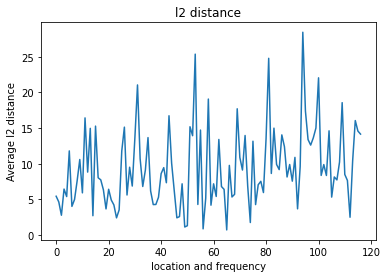

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def l2_dist(p1, p2):
    x1,y1 = p1
    x2,y2 = p2
    x1, y1 = np.array(x1), np.array(y1)
    x2, y2 = np.array(x2), np.array(y2)
    dx = x1 - x2
    dy = y1 - y2
    dx = dx ** 2
    dy = dy ** 2
    dists = dx + dy
    dists = np.sqrt(dists)
    return np.mean(dists)

def create_deep(inp_dim):
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(50, input_dim=inp_dim, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(.001), metrics=['mse'])
    return model
es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)

frequencies = [8e7,30e7,99e7]
def iterated_position_estimation(data):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
    
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == a[k][0])&(data['position_y'] == a[k][1])
        
        if k==38:
            k=-1
            
        temp_filter_not = (data['position_x'] != a[k][0])&(data['position_y'] != a[k][1])&(data['position_x'] != a[k+1][0])&(data['position_y'] != a[k+1][1])              
        val_temp_filter= (data['position_x'] == a[k+1][0])&(data['position_y'] == a[k+1][1])
        frequencies = data.loc[temp_filter].iloc[:,1].values
        frequencies = pd.Series(frequencies).drop_duplicates().tolist()
        for f in frequencies:
            reg=create_deep(4)
            temp_train = data.loc[temp_filter_not].loc[data['frequency'] == f].iloc[:,4:]
            temp_val= data.loc[val_temp_filter].loc[data['frequency'] == f].iloc[:,4:]            
            temp_test = data.loc[temp_filter].loc[data['frequency'] == f].iloc[:,4:]
       
            locations = data.loc[data['frequency'] == f].loc[temp_filter].iloc[:,2:4].values
            locations_val = data.loc[data['frequency'] == f].loc[val_temp_filter].iloc[:,2:4].values
            locations_not = data.loc[data['frequency'] == f].loc[temp_filter_not].iloc[:,2:4].values
            #regr1.fit(temp_train,x_coordinates_not)
            #regr2.fit(temp_train,y_coordinates_not)
            
            temp_train["indication"]=0
            temp_test["indication"]=1
            dataa=pd.concat([temp_train,temp_test])
            X=dataa.iloc[:,:4]
            y=dataa.iloc[:,4]
            model=LogisticRegression()
            model.fit(X,y)
            conf_score = model.decision_function(temp_train.iloc[:,:4])
            C = 10
            conditions = [conf_score < -C,conf_score > C]
            choices = [-C, C]
            conf_score = np.select(conditions, choices, conf_score)
            weights = np.exp(conf_score)
            
            PredictorScaler=StandardScaler()
            PredictorScalerFit=PredictorScaler.fit(temp_train.iloc[:,:4])
            temp_train=PredictorScalerFit.transform(temp_train.iloc[:,:4])
            temp_val=PredictorScalerFit.transform(temp_val)
            temp_test=PredictorScalerFit.transform(temp_test.iloc[:,:4])

            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
            
            hist=reg.fit(temp_train,locations_not,validation_data=(temp_val, locations_val),sample_weight = weights, epochs=15, batch_size=20,  callbacks = [es])
            #temp_pred_x = regr1.predict(temp_test)
            #temp_pred_y = regr2.predict(temp_test)
            temp_pred = reg.predict(temp_test[:,:4])
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            
    plt.plot(l2)
    plt.title("l2 distance")
    plt.xlabel("location and frequency")
    plt.ylabel("Average l2 distance")
    print(np.mean(l2))
iterated_position_estimation(data)

# Codes are Tested Here (Scratch)

# Preprocessing Scheme

Outlier detection technique Local Outlier Factor and for smoothing moving average is used.

In [3]:
frequencies = [8e7,30e7,99e7]

def preprocessing1(Outlier, Smoothing):
    
    data=pd.read_csv("labeled_data.csv")
    
    data["r12"]=data["receiver_1"]-data["receiver_2"]
    data["r13"]=data["receiver_1"]-data["receiver_3"]
    data["r14"]=data["receiver_1"]-data["receiver_4"]
    data.drop(columns=['receiver_1','receiver_2','receiver_3','receiver_4'],inplace=True)
    
    if Outlier == 1: 
        df = pd.DataFrame(columns=['position_x', 'position_y','r12', 'r13', 'r14','frequency'])
        for f in frequencies:
            for k,group in enumerate(groups_in_file.groups):
                temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])
                temp_train = data.loc[temp_filter].loc[data['frequency'] == f].iloc[:,4:].values
                model=IsolationForest(contamination=float(0.05))
                yhat=model.fit_predict(temp_train)
                mask = yhat != -1
                temp_train2=temp_train[mask,:]
                locations = data.loc[data['frequency'] == f].loc[temp_filter].iloc[:,2:4].values
                yy=locations[mask,:]
                dataset=pd.DataFrame({'position_x':yy[:,0], 'position_y':yy[:,1],'r12': temp_train2[:, 0], 'r13': temp_train2[:, 1], 'r14': temp_train2[:, 2], 'frequency':f})
                df=pd.concat([df, dataset])
        data=df.copy()        
    else:
        pass
    
    if Smoothing == 1:
        data["r1_2"]=moving_average(data["r12"],5)
        data["r1_3"]=moving_average(data["r13"],5)
        data["r1_4"]=moving_average(data["r14"],5)
        
        data.drop(columns=['r12','r13','r14'],inplace=True)
        
        new_cols = ["position_x","position_y","frequency","r1_2","r1_3","r1_4"]
        data=data.reindex(columns=new_cols)
        
    else:
        data.rename(columns={'r12': 'r1_2', 'r13': 'r1_3', 'r14': 'r1_4'}, inplace=True)
        new_cols = ["position_x","position_y","frequency","r1_2","r1_3","r1_4"]
        data=data.reindex(columns=new_cols)
    
    return data

In [25]:
preprocessing1(1,0)

,position_x,position_y,frequency,r1_2,r1_3,r1_4
0,3.5,3.0,80000000.0,-44.451668,-7.529182,-1.806946
1,3.5,3.0,80000000.0,-43.220055,-1.716606,3.647118
2,3.5,3.0,80000000.0,-43.666885,-1.176971,1.495316
3,3.5,3.0,80000000.0,-44.499939,-4.034874,0.250877
4,3.5,3.0,80000000.0,-44.859261,-5.849998,0.401505
...,...,...,...,...,...,...
2170,30.0,37.0,990000000.0,52.693047,27.255562,-13.001747
2171,30.0,37.0,990000000.0,52.779255,27.269642,-12.989967
2172,30.0,37.0,990000000.0,52.84758,27.274666,-12.973564
2173,30.0,37.0,990000000.0,52.850616,27.312897,-12.976501


In [26]:
preprocessing1(1,1)

,position_x,position_y,frequency,r1_2,r1_3,r1_4
0,3.5,3.0,80000000.0,-44.048389,-5.096225,-0.055681
1,3.5,3.0,80000000.0,-44.058043,-4.397363,0.355884
2,3.5,3.0,80000000.0,-44.139561,-4.061526,0.797574
3,3.5,3.0,80000000.0,-44.71803,-4.358383,0.623885
4,3.5,3.0,80000000.0,-45.082863,-5.39055,-0.046873
...,...,...,...,...,...,...
2170,30.0,37.0,990000000.0,52.75687,27.246828,-12.995311
2171,30.0,37.0,990000000.0,52.769183,27.264743,-12.988721
2172,30.0,37.0,990000000.0,52.771168,27.279621,-12.980817
2173,30.0,37.0,990000000.0,52.769627,27.285577,-12.972928


In [27]:
preprocessing1(0,1)

,position_x,position_y,frequency,r1_2,r1_3,r1_4
0,3.5,3.0,80000000.0,-43.667677,-4.323773,0.594954
1,3.5,3.0,80000000.0,-43.082292,-2.249500,1.718565
2,3.5,3.0,80000000.0,-42.925336,-0.979057,2.379018
3,3.5,3.0,80000000.0,-42.934990,-0.280196,2.790582
4,3.5,3.0,80000000.0,-43.262831,-1.106874,2.141460
...,...,...,...,...,...,...
267925,16.0,27.0,990000000.0,36.348364,18.391650,12.411528
267926,16.0,27.0,990000000.0,36.447198,18.453349,12.512766
267927,16.0,27.0,990000000.0,36.567884,18.539835,12.619315
267928,16.0,27.0,990000000.0,36.676204,18.628166,12.715842


In [28]:
preprocessing1(0,0)

,position_x,position_y,frequency,r1_2,r1_3,r1_4
0,3.5,3.0,80000000.0,-44.451668,-7.529182,-1.806946
1,3.5,3.0,80000000.0,-43.220055,-1.716606,3.647118
2,3.5,3.0,80000000.0,-41.763329,2.685287,4.748489
3,3.5,3.0,80000000.0,-41.524742,2.842186,3.811111
4,3.5,3.0,80000000.0,-43.666885,-1.176971,1.495316
...,...,...,...,...,...,...
267925,16.0,27.0,990000000.0,36.315811,18.347076,12.370659
267926,16.0,27.0,990000000.0,36.422951,18.387970,12.497513
267927,16.0,27.0,990000000.0,36.555176,18.515205,12.634651
267928,16.0,27.0,990000000.0,36.688072,18.660194,12.740463


# Models

In [4]:
import tensorflow as tf
def create_deep(inp_dim):
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(27, input_dim=inp_dim, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(53, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['mse'])
    return model
es = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto', restore_best_weights=True)

def iterated_position_estimation1(data, Scaling, Validation):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
    
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    byproc=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == a[k][0])&(data['position_y'] == a[k][1])
        
        if k==38:
            k=-1
            
        frequencies = data.loc[temp_filter].iloc[:,2].values
        frequencies = pd.Series(frequencies).drop_duplicates().tolist()
        for f in frequencies:
            reg=create_deep(4)
            if Validation == 1:
                temp_filter_not = (data['position_x'] != a[k][0])&(data['position_y'] != a[k][1])&(data['position_x'] != a[k+1][0])&(data['position_y'] != a[k+1][1])              
                val_temp_filter= (data['position_x'] == a[k+1][0])&(data['position_y'] == a[k+1][1])
            
            elif Validation == 2:
                temp_filter_not = (data['position_x'] != a[k][0])&(data['position_y'] != a[k][1])&(data['position_x'] != realdicc[(a[k][0], a[k][1])][f][0][0])&(data['position_y'] != realdicc[(a[k][0], a[k][1])][f][0][1])
                val_temp_filter= (data['position_x'] == realdicc[(a[k][0], a[k][1])][f][0][0])&(data['position_y'] == realdicc[(a[k][0], a[k][1])][f][0][1])
                
            temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,2:]
            temp_val= data.loc[(val_temp_filter)&(data['frequency'] == f)].iloc[:,2:]            
            temp_test = data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,2:]
            
            locations = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
            locations_val = data.loc[(data['frequency'] == f)&(val_temp_filter)].iloc[:,0:2].values
            locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values

            if Scaling == 1:
                PredictorScaler=StandardScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_val=PredictorScalerFit.transform(temp_val)
                temp_test=PredictorScalerFit.transform(temp_test)
                
            elif Scaling == 2:
                PredictorScaler=MinMaxScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_val=PredictorScalerFit.transform(temp_val)
                temp_test=PredictorScalerFit.transform(temp_test)
            else:
                pass
    
            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
        
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_val = np.asarray(temp_val).astype(np.float32)
            locations_val = np.asarray(locations_val).astype(np.float32)
            temp_test = np.asarray(temp_test).astype(np.float32)
            locations = np.asarray(locations).astype(np.float32)   
            
            hist=reg.fit(temp_train,locations_not,validation_data=(temp_val, locations_val), epochs=30, batch_size=100,  callbacks = [es])

            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))

    loss=np.mean(l2)
    print(loss)            

def iterated_position_estimation2(data,reg, Scaling):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
        
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])
            
        frequencies = data.loc[temp_filter].iloc[:,2].values
        frequencies = pd.Series(frequencies).drop_duplicates().tolist()
        for f in frequencies:
            reg=reg
            
            temp_filter_not = (data['position_x'] != group[0])&(data['position_y'] != group[1])

            temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,3:]
            temp_test = data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,3:]
            
            locations = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
            locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values

            #regr1.fit(temp_train,x_coordinates_not)
            #regr2.fit(temp_train,y_coordinates_not)
            
            if Scaling == 1:
                PredictorScaler=StandardScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
                
            elif Scaling == 2:
                PredictorScaler=MinMaxScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
            else:
                pass

            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
            
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_test = np.asarray(temp_test).astype(np.float32)
            locations = np.asarray(locations).astype(np.float32)
    
            hist=reg.fit(temp_train,locations_not)
            #temp_pred_x = regr1.predict(temp_test)
            #temp_pred_y = regr2.predict(temp_test)
            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
    
    loss=np.mean(l2)
    print(loss)
    print(l2)

def iterated_position_estimation4(data, Scaling):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
        
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])
        
        for f in frequencies:
            reg=create_deep(4)
            
            temp_filter_not = (data['position_x'] != group[0])&(data['position_y'] != group[1])

            temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,2:]
            temp_test = data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,2:]
            
            locations = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
            locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values

            #regr1.fit(temp_train,x_coordinates_not)
            #regr2.fit(temp_train,y_coordinates_not)
            
            if Scaling == 1:
                PredictorScaler=StandardScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
                
            elif Scaling == 2:
                PredictorScaler=MinMaxScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
            else:
                pass

            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
            
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_test = np.asarray(temp_test).astype(np.float32)
            locations = np.asarray(locations).astype(np.float32)
            
            hist=reg.fit(temp_train,locations_not, epochs=30, batch_size=100)
            #temp_pred_x = regr1.predict(temp_test)
            #temp_pred_y = regr2.predict(temp_test)
            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
    
    loss=np.mean(l2)
    print(loss)
    print(l2)

In [5]:
iterated_position_estimation1(preprocessing1(1,1),1,1)

Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 43.8354 - mse: 43.8354 - val_loss: 10.8233 - val_mse: 10.8233
Epoch 2/30
756/756 [==============================] - 1s 1ms/step - loss: 26.6122 - mse: 26.6122 - val_loss: 10.6268 - val_mse: 10.6268
Epoch 3/30
756/756 [==============================] - 1s 1ms/step - loss: 23.8203 - mse: 23.8203 - val_loss: 11.1331 - val_mse: 11.1331
Epoch 4/30
756/756 [==============================] - 1s 1ms/step - loss: 21.5078 - mse: 21.5078 - val_loss: 13.5179 - val_mse: 13.5179
Epoch 5/30
756/756 [==============================] - 1s 1ms/step - loss: 19.6727 - mse: 19.6727 - val_loss: 9.9778 - val_mse: 9.9778
Epoch 6/30
756/756 [==============================] - 1s 1ms/step - loss: 18.0368 - mse: 18.0368 - val_loss: 10.5842 - val_mse: 10.5842
Epoch 7/30
756/756 [==============================] - 1s 1ms/step - loss: 16.9043 - mse: 16.9043 - val_loss: 19.6452 - val_mse: 19.6452
Epoch 8/30
756/756 [==============================

Epoch 5/30
825/825 [==============================] - 1s 1ms/step - loss: 18.7566 - mse: 18.7566 - val_loss: 46.2744 - val_mse: 46.2744
Epoch 6/30
825/825 [==============================] - 1s 1ms/step - loss: 17.7955 - mse: 17.7955 - val_loss: 38.6108 - val_mse: 38.6108
Epoch 7/30
825/825 [==============================] - 1s 1ms/step - loss: 17.0500 - mse: 17.0500 - val_loss: 38.7226 - val_mse: 38.7226
Epoch 8/30
825/825 [==============================] - 1s 1ms/step - loss: 16.3958 - mse: 16.3958 - val_loss: 44.5762 - val_mse: 44.5762
Epoch 9/30
825/825 [==============================] - 1s 1ms/step - loss: 15.7151 - mse: 15.7151 - val_loss: 50.7043 - val_mse: 50.7043
Prediced Locations
[[8.556768  6.899661 ]
 [8.6150875 6.882286 ]
 [8.613813  6.8871074]
 ...
 [8.796867  6.6167245]
 [7.643302  7.508328 ]
 [7.157573  7.8646374]]
Real Locations
[[4. 8.]
 [4. 8.]
 [4. 8.]
 ...
 [4. 8.]
 [4. 8.]
 [4. 8.]]
2 (4.0, 8.0) 80000000.0 4.602293551125304
Epoch 1/30
825/825 [====================

Epoch 1/30
802/802 [==============================] - 2s 2ms/step - loss: 39.4446 - mse: 39.4446 - val_loss: 41.6454 - val_mse: 41.6454
Epoch 2/30
802/802 [==============================] - 1s 1ms/step - loss: 25.4009 - mse: 25.4009 - val_loss: 36.5375 - val_mse: 36.5375
Epoch 3/30
802/802 [==============================] - 1s 1ms/step - loss: 21.5421 - mse: 21.5421 - val_loss: 40.5833 - val_mse: 40.5833
Epoch 4/30
802/802 [==============================] - 1s 1ms/step - loss: 19.0384 - mse: 19.0384 - val_loss: 46.1256 - val_mse: 46.1256
Epoch 5/30
802/802 [==============================] - 1s 1ms/step - loss: 17.4671 - mse: 17.4671 - val_loss: 41.3413 - val_mse: 41.3413
Epoch 6/30
802/802 [==============================] - 1s 1ms/step - loss: 16.3179 - mse: 16.3179 - val_loss: 57.1339 - val_mse: 57.1339
Epoch 7/30
802/802 [==============================] - 1s 1ms/step - loss: 15.4890 - mse: 15.4890 - val_loss: 52.5056 - val_mse: 52.5056
Prediced Locations
[[ 8.200439  16.491558 ]
 [ 6

Epoch 1/30
825/825 [==============================] - 2s 2ms/step - loss: 37.3152 - mse: 37.3152 - val_loss: 0.5081 - val_mse: 0.5081
Epoch 2/30
825/825 [==============================] - 1s 1ms/step - loss: 21.6035 - mse: 21.6035 - val_loss: 1.9880 - val_mse: 1.9880
Epoch 3/30
825/825 [==============================] - 1s 1ms/step - loss: 18.3513 - mse: 18.3513 - val_loss: 2.2375 - val_mse: 2.2375
Epoch 4/30
825/825 [==============================] - 1s 1ms/step - loss: 16.7682 - mse: 16.7682 - val_loss: 2.2873 - val_mse: 2.2873
Epoch 5/30
825/825 [==============================] - 1s 1ms/step - loss: 15.5870 - mse: 15.5870 - val_loss: 10.6781 - val_mse: 10.6781
Epoch 6/30
825/825 [==============================] - 1s 1ms/step - loss: 14.5761 - mse: 14.5761 - val_loss: 27.2141 - val_mse: 27.2141
Prediced Locations
[[13.988929 18.977715]
 [ 9.623218 14.359682]
 [ 9.627561 14.336206]
 ...
 [ 9.794718 15.078436]
 [ 9.749647 15.066794]
 [ 9.716826 15.04642 ]]
Real Locations
[[ 9. 21.]
 [ 

Epoch 16/30
710/710 [==============================] - 1s 1ms/step - loss: 13.2771 - mse: 13.2771 - val_loss: 12.8046 - val_mse: 12.8046
Prediced Locations
[[ 8.591715   5.589405 ]
 [10.0712185  4.331419 ]
 [10.143442   4.7697344]
 ...
 [ 6.676123   4.421544 ]
 [ 6.4064474  4.773718 ]
 [ 6.572606   5.570691 ]]
Real Locations
[[11.5  3. ]
 [11.5  3. ]
 [11.5  3. ]
 ...
 [11.5  3. ]
 [11.5  3. ]
 [11.5  3. ]]
7 (11.5, 3.0) 80000000.0 4.692942169363363
Epoch 1/30
710/710 [==============================] - 1s 1ms/step - loss: 37.5482 - mse: 37.5482 - val_loss: 18.7664 - val_mse: 18.7664
Epoch 2/30
710/710 [==============================] - 1s 1ms/step - loss: 21.0700 - mse: 21.0700 - val_loss: 15.3188 - val_mse: 15.3188
Epoch 3/30
710/710 [==============================] - 1s 1ms/step - loss: 17.8906 - mse: 17.8906 - val_loss: 19.4794 - val_mse: 19.4794
Epoch 4/30
710/710 [==============================] - 1s 1ms/step - loss: 15.5095 - mse: 15.5095 - val_loss: 44.2390 - val_mse: 44.2390
Ep

8 (12.0, 30.0) 990000000.0 3.603485591496786
Epoch 1/30
733/733 [==============================] - 2s 2ms/step - loss: 37.4884 - mse: 37.4884 - val_loss: 27.4529 - val_mse: 27.4529
Epoch 2/30
733/733 [==============================] - 1s 1ms/step - loss: 23.4910 - mse: 23.4910 - val_loss: 28.4411 - val_mse: 28.4411
Epoch 3/30
733/733 [==============================] - 1s 1ms/step - loss: 20.4558 - mse: 20.4558 - val_loss: 15.6899 - val_mse: 15.6899
Epoch 4/30
733/733 [==============================] - 1s 1ms/step - loss: 18.7138 - mse: 18.7138 - val_loss: 13.9252 - val_mse: 13.9252
Epoch 5/30
733/733 [==============================] - 1s 1ms/step - loss: 17.9876 - mse: 17.9876 - val_loss: 20.1415 - val_mse: 20.1415
Epoch 6/30
733/733 [==============================] - 1s 1ms/step - loss: 17.1151 - mse: 17.1151 - val_loss: 23.7448 - val_mse: 23.7448
Epoch 7/30
733/733 [==============================] - 1s 1ms/step - loss: 16.6825 - mse: 16.6825 - val_loss: 20.9748 - val_mse: 20.9748
Epo

Epoch 4/30
802/802 [==============================] - 1s 1ms/step - loss: 18.5611 - mse: 18.5611 - val_loss: 24.1020 - val_mse: 24.1020
Epoch 5/30
802/802 [==============================] - 1s 1ms/step - loss: 17.2846 - mse: 17.2846 - val_loss: 15.0658 - val_mse: 15.0658
Epoch 6/30
802/802 [==============================] - 1s 1ms/step - loss: 16.0753 - mse: 16.0753 - val_loss: 24.6804 - val_mse: 24.6804
Epoch 7/30
802/802 [==============================] - 1s 1ms/step - loss: 15.4690 - mse: 15.4690 - val_loss: 26.1576 - val_mse: 26.1576
Epoch 8/30
802/802 [==============================] - 1s 1ms/step - loss: 14.8739 - mse: 14.8739 - val_loss: 34.3617 - val_mse: 34.3617
Epoch 9/30
802/802 [==============================] - 1s 1ms/step - loss: 14.1058 - mse: 14.1058 - val_loss: 30.3512 - val_mse: 30.3512
Epoch 10/30
802/802 [==============================] - 1s 1ms/step - loss: 13.6239 - mse: 13.6239 - val_loss: 28.5751 - val_mse: 28.5751
Prediced Locations
[[11.025466 20.589775]
 [15.

Epoch 1/30
756/756 [==============================] - 2s 1ms/step - loss: 33.8410 - mse: 33.8410 - val_loss: 2.4344 - val_mse: 2.4344
Epoch 2/30
756/756 [==============================] - 1s 1ms/step - loss: 20.6191 - mse: 20.6191 - val_loss: 1.8497 - val_mse: 1.8497
Epoch 3/30
756/756 [==============================] - 1s 1ms/step - loss: 17.6232 - mse: 17.6232 - val_loss: 2.5261 - val_mse: 2.5261
Epoch 4/30
756/756 [==============================] - 1s 1ms/step - loss: 15.7138 - mse: 15.7138 - val_loss: 5.0490 - val_mse: 5.0490
Epoch 5/30
756/756 [==============================] - 1s 1ms/step - loss: 14.6195 - mse: 14.6195 - val_loss: 3.8215 - val_mse: 3.8215
Epoch 6/30
756/756 [==============================] - 1s 1ms/step - loss: 13.9665 - mse: 13.9665 - val_loss: 3.3604 - val_mse: 3.3604
Epoch 7/30
756/756 [==============================] - 1s 1ms/step - loss: 13.4170 - mse: 13.4170 - val_loss: 5.1228 - val_mse: 5.1228
Prediced Locations
[[14.273906 37.044876]
 [14.335639 37.88911

733/733 [==============================] - 1s 1ms/step - loss: 13.6679 - mse: 13.6679 - val_loss: 15.5167 - val_mse: 15.5167
Prediced Locations
[[31.114765 11.535916]
 [30.426882 10.689768]
 [30.157393 10.674213]
 ...
 [32.596497 11.68239 ]
 [32.337395 11.682754]
 [32.645855 11.623927]]
Real Locations
[[21. 14.]
 [21. 14.]
 [21. 14.]
 ...
 [21. 14.]
 [21. 14.]
 [21. 14.]]
18 (21.0, 14.0) 300000000.0 11.217448767870216
Epoch 1/30
733/733 [==============================] - 1s 1ms/step - loss: 36.8000 - mse: 36.8000 - val_loss: 6.2145 - val_mse: 6.2145
Epoch 2/30
733/733 [==============================] - 1s 1ms/step - loss: 20.9488 - mse: 20.9488 - val_loss: 2.3418 - val_mse: 2.3418
Epoch 3/30
733/733 [==============================] - 1s 1ms/step - loss: 17.4383 - mse: 17.4383 - val_loss: 5.9813 - val_mse: 5.9813
Epoch 4/30
733/733 [==============================] - 1s 1ms/step - loss: 15.9313 - mse: 15.9313 - val_loss: 2.5278 - val_mse: 2.5278
Epoch 5/30
733/733 [======================

665/665 [==============================] - 1s 1ms/step - loss: 20.0806 - mse: 20.0806 - val_loss: 84.3163 - val_mse: 84.3163
Epoch 6/30
665/665 [==============================] - 1s 1ms/step - loss: 18.6004 - mse: 18.6004 - val_loss: 110.2323 - val_mse: 110.2323
Epoch 7/30
665/665 [==============================] - 1s 1ms/step - loss: 18.2662 - mse: 18.2662 - val_loss: 113.5841 - val_mse: 113.5841
Epoch 8/30
665/665 [==============================] - 1s 1ms/step - loss: 17.3184 - mse: 17.3184 - val_loss: 123.4928 - val_mse: 123.4928
Epoch 9/30
665/665 [==============================] - 1s 1ms/step - loss: 16.5938 - mse: 16.5938 - val_loss: 115.7592 - val_mse: 115.7592
Epoch 10/30
665/665 [==============================] - 1s 1ms/step - loss: 15.9154 - mse: 15.9154 - val_loss: 117.8774 - val_mse: 117.8774
Prediced Locations
[[19.64097  35.59995 ]
 [17.68317  35.976562]
 [17.629734 36.728035]
 ...
 [18.226341 35.691856]
 [18.217041 35.70623 ]
 [18.242847 35.533962]]
Real Locations
[[21. 

Epoch 1/30
710/710 [==============================] - 1s 1ms/step - loss: 36.6404 - mse: 36.6404 - val_loss: 13.3309 - val_mse: 13.3309
Epoch 2/30
710/710 [==============================] - 1s 1ms/step - loss: 19.8008 - mse: 19.8008 - val_loss: 28.4185 - val_mse: 28.4185
Epoch 3/30
710/710 [==============================] - 1s 1ms/step - loss: 16.8352 - mse: 16.8352 - val_loss: 21.6074 - val_mse: 21.6074
Epoch 4/30
710/710 [==============================] - 1s 1ms/step - loss: 14.3716 - mse: 14.3716 - val_loss: 28.1652 - val_mse: 28.1652
Epoch 5/30
710/710 [==============================] - 1s 1ms/step - loss: 13.1655 - mse: 13.1655 - val_loss: 18.7145 - val_mse: 18.7145
Epoch 6/30
710/710 [==============================] - 1s 1ms/step - loss: 12.1437 - mse: 12.1437 - val_loss: 20.1123 - val_mse: 20.1123
Prediced Locations
[[30.667513   5.4290867]
 [30.885313   5.0658126]
 [30.96108    5.09199  ]
 ...
 [31.34334    5.208206 ]
 [31.354755   5.2014403]
 [31.364952   5.188347 ]]
Real Loca

779/779 [==============================] - 1s 1ms/step - loss: 17.8402 - mse: 17.8402 - val_loss: 7.5840 - val_mse: 7.5840
Epoch 4/30
779/779 [==============================] - 1s 1ms/step - loss: 15.5382 - mse: 15.5382 - val_loss: 3.2966 - val_mse: 3.2966
Epoch 5/30
779/779 [==============================] - 1s 1ms/step - loss: 14.6150 - mse: 14.6150 - val_loss: 2.2913 - val_mse: 2.2913
Epoch 6/30
779/779 [==============================] - 1s 1ms/step - loss: 14.0083 - mse: 14.0083 - val_loss: 3.0203 - val_mse: 3.0203
Epoch 7/30
779/779 [==============================] - 1s 1ms/step - loss: 13.4034 - mse: 13.4034 - val_loss: 4.8910 - val_mse: 4.8910
Epoch 8/30
779/779 [==============================] - 1s 1ms/step - loss: 12.8168 - mse: 12.8168 - val_loss: 10.6711 - val_mse: 10.6711
Epoch 9/30
779/779 [==============================] - 1s 1ms/step - loss: 12.2240 - mse: 12.2240 - val_loss: 16.2513 - val_mse: 16.2513
Epoch 10/30
779/779 [==============================] - 1s 1ms/step - 

Epoch 13/30
756/756 [==============================] - 1s 1ms/step - loss: 16.2744 - mse: 16.2744 - val_loss: 35.0433 - val_mse: 35.0433
Epoch 14/30
756/756 [==============================] - 1s 1ms/step - loss: 16.1366 - mse: 16.1366 - val_loss: 46.6355 - val_mse: 46.6355
Epoch 15/30
756/756 [==============================] - 1s 1ms/step - loss: 15.5398 - mse: 15.5398 - val_loss: 35.3226 - val_mse: 35.3226
Epoch 16/30
756/756 [==============================] - 1s 1ms/step - loss: 15.1495 - mse: 15.1495 - val_loss: 42.6864 - val_mse: 42.6864
Prediced Locations
[[39.323345 42.144615]
 [35.55011  41.80997 ]
 [35.511    41.083828]
 ...
 [34.933918 39.75325 ]
 [35.323475 40.408913]
 [36.06825  41.872604]]
Real Locations
[[26. 38.]
 [26. 38.]
 [26. 38.]
 ...
 [26. 38.]
 [26. 38.]
 [26. 38.]]
29 (26.0, 38.0) 80000000.0 11.523507188142245
Epoch 1/30
756/756 [==============================] - 2s 1ms/step - loss: 32.3727 - mse: 32.3727 - val_loss: 6.7944 - val_mse: 6.7944
Epoch 2/30
756/756 [==

Epoch 1/30
596/596 [==============================] - 1s 1ms/step - loss: 30.5757 - mse: 30.5757 - val_loss: 41.4687 - val_mse: 41.4687
Epoch 2/30
596/596 [==============================] - 1s 1ms/step - loss: 18.0139 - mse: 18.0139 - val_loss: 56.5810 - val_mse: 56.5810
Epoch 3/30
596/596 [==============================] - 1s 1ms/step - loss: 15.4734 - mse: 15.4734 - val_loss: 50.6470 - val_mse: 50.6470
Epoch 4/30
596/596 [==============================] - 1s 1ms/step - loss: 13.5176 - mse: 13.5176 - val_loss: 64.2739 - val_mse: 64.2739
Epoch 5/30
596/596 [==============================] - 1s 1ms/step - loss: 12.1783 - mse: 12.1783 - val_loss: 65.9740 - val_mse: 65.9740
Epoch 6/30
596/596 [==============================] - 1s 1ms/step - loss: 11.2172 - mse: 11.2172 - val_loss: 62.5142 - val_mse: 62.5142
Prediced Locations
[[27.51769  28.236824]
 [27.97891  28.101078]
 [27.967495 28.092289]
 ...
 [26.807787 26.83089 ]
 [26.745317 26.771435]
 [26.776846 26.80532 ]]
Real Locations
[[29. 

Prediced Locations
[[21.18495  24.93275 ]
 [21.690247 23.729244]
 [21.651367 23.702122]
 ...
 [21.215834 24.526379]
 [21.089495 24.541145]
 [21.117256 24.571026]]
Real Locations
[[30. 12.]
 [30. 12.]
 [30. 12.]
 ...
 [30. 12.]
 [30. 12.]
 [30. 12.]]
33 (30.0, 12.0) 300000000.0 14.935075400834693
Epoch 1/30
710/710 [==============================] - 1s 1ms/step - loss: 32.0980 - mse: 32.0980 - val_loss: 37.7841 - val_mse: 37.7841
Epoch 2/30
710/710 [==============================] - 1s 1ms/step - loss: 18.7659 - mse: 18.7659 - val_loss: 29.1740 - val_mse: 29.1740
Epoch 3/30
710/710 [==============================] - 1s 1ms/step - loss: 15.4746 - mse: 15.4746 - val_loss: 39.1164 - val_mse: 39.1164
Epoch 4/30
710/710 [==============================] - 1s 1ms/step - loss: 13.4791 - mse: 13.4791 - val_loss: 37.6682 - val_mse: 37.6682
Epoch 5/30
710/710 [==============================] - 1s 1ms/step - loss: 12.6124 - mse: 12.6124 - val_loss: 46.9833 - val_mse: 46.9833
Epoch 6/30
710/710 [===

642/642 [==============================] - 1s 2ms/step - loss: 8.3718 - mse: 8.3718 - val_loss: 21.3161 - val_mse: 21.3161
Epoch 11/30
642/642 [==============================] - 1s 1ms/step - loss: 7.8332 - mse: 7.8332 - val_loss: 42.0752 - val_mse: 42.0752
Epoch 12/30
642/642 [==============================] - 1s 1ms/step - loss: 7.5906 - mse: 7.5906 - val_loss: 18.6106 - val_mse: 18.6106
Epoch 13/30
642/642 [==============================] - 1s 2ms/step - loss: 7.3628 - mse: 7.3628 - val_loss: 29.2175 - val_mse: 29.2175
Prediced Locations
[[24.123625 31.897757]
 [24.309776 32.129807]
 [24.189285 32.070827]
 ...
 [24.393686 32.398026]
 [24.315117 32.357162]
 [24.232504 32.272377]]
Real Locations
[[30. 33.]
 [30. 33.]
 [30. 33.]
 ...
 [30. 33.]
 [30. 33.]
 [30. 33.]]
37 (30.0, 33.0) 300000000.0 5.80878554806982
Epoch 1/30
642/642 [==============================] - 2s 2ms/step - loss: 30.8582 - mse: 30.8582 - val_loss: 44.8741 - val_mse: 44.8741
Epoch 2/30
642/642 [=====================

In [6]:
import tensorflow as tf
def create_deep(inp_dim):
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(37, input_dim=inp_dim, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(83, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(55, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['mse'])
    return model
es = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto', restore_best_weights=True)

def iterated_position_estimation1(data, Scaling, Validation):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
    
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    byproc=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == a[k][0])&(data['position_y'] == a[k][1])
        
        if k==38:
            k=-1
            
        frequencies = data.loc[temp_filter].iloc[:,2].values
        frequencies = pd.Series(frequencies).drop_duplicates().tolist()
        for f in frequencies:
            reg=create_deep(4)
            if Validation == 1:
                temp_filter_not = (data['position_x'] != a[k][0])&(data['position_y'] != a[k][1])&(data['position_x'] != a[k+1][0])&(data['position_y'] != a[k+1][1])              
                val_temp_filter= (data['position_x'] == a[k+1][0])&(data['position_y'] == a[k+1][1])
            
            elif Validation == 2:
                temp_filter_not = (data['position_x'] != a[k][0])&(data['position_y'] != a[k][1])&(data['position_x'] != realdicc[(a[k][0], a[k][1])][f][0][0])&(data['position_y'] != realdicc[(a[k][0], a[k][1])][f][0][1])
                val_temp_filter= (data['position_x'] == realdicc[(a[k][0], a[k][1])][f][0][0])&(data['position_y'] == realdicc[(a[k][0], a[k][1])][f][0][1])
                
            temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,2:]
            temp_val= data.loc[(val_temp_filter)&(data['frequency'] == f)].iloc[:,2:]            
            temp_test = data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,2:]
            
            locations = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
            locations_val = data.loc[(data['frequency'] == f)&(val_temp_filter)].iloc[:,0:2].values
            locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values

            if Scaling == 1:
                PredictorScaler=StandardScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_val=PredictorScalerFit.transform(temp_val)
                temp_test=PredictorScalerFit.transform(temp_test)
                
            elif Scaling == 2:
                PredictorScaler=MinMaxScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_val=PredictorScalerFit.transform(temp_val)
                temp_test=PredictorScalerFit.transform(temp_test)
            else:
                pass
    
            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
        
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_val = np.asarray(temp_val).astype(np.float32)
            locations_val = np.asarray(locations_val).astype(np.float32)
            temp_test = np.asarray(temp_test).astype(np.float32)
            locations = np.asarray(locations).astype(np.float32)   
            
            hist=reg.fit(temp_train,locations_not,validation_data=(temp_val, locations_val), epochs=30, batch_size=100,  callbacks = [es])

            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))

    loss=np.mean(l2)
    print(loss)            

def iterated_position_estimation2(data,reg, Scaling):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
        
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])
            
        frequencies = data.loc[temp_filter].iloc[:,2].values
        frequencies = pd.Series(frequencies).drop_duplicates().tolist()
        for f in frequencies:
            reg=reg
            
            temp_filter_not = (data['position_x'] != group[0])&(data['position_y'] != group[1])

            temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,3:]
            temp_test = data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,3:]
            
            locations = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
            locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values

            #regr1.fit(temp_train,x_coordinates_not)
            #regr2.fit(temp_train,y_coordinates_not)
            
            if Scaling == 1:
                PredictorScaler=StandardScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
                
            elif Scaling == 2:
                PredictorScaler=MinMaxScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
            else:
                pass

            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
            
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_test = np.asarray(temp_test).astype(np.float32)
            locations = np.asarray(locations).astype(np.float32)
    
            hist=reg.fit(temp_train,locations_not)
            #temp_pred_x = regr1.predict(temp_test)
            #temp_pred_y = regr2.predict(temp_test)
            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
    
    loss=np.mean(l2)
    print(loss)
    print(l2)

def iterated_position_estimation4(data, Scaling):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
        
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])
        
        for f in frequencies:
            reg=create_deep(4)
            
            temp_filter_not = (data['position_x'] != group[0])&(data['position_y'] != group[1])

            temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,2:]
            temp_test = data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,2:]
            
            locations = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
            locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values

            #regr1.fit(temp_train,x_coordinates_not)
            #regr2.fit(temp_train,y_coordinates_not)
            
            if Scaling == 1:
                PredictorScaler=StandardScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
                
            elif Scaling == 2:
                PredictorScaler=MinMaxScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
            else:
                pass

            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
            
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_test = np.asarray(temp_test).astype(np.float32)
            locations = np.asarray(locations).astype(np.float32)
            
            hist=reg.fit(temp_train,locations_not, epochs=30, batch_size=100)
            #temp_pred_x = regr1.predict(temp_test)
            #temp_pred_y = regr2.predict(temp_test)
            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
    
    loss=np.mean(l2)
    print(loss)
    print(l2)

In [7]:
iterated_position_estimation1(preprocessing1(0,0),1,2)

Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 48.4935 - mse: 48.4935 - val_loss: 15.4701 - val_mse: 15.4701
Epoch 2/30
756/756 [==============================] - 1s 2ms/step - loss: 27.7979 - mse: 27.7979 - val_loss: 5.6066 - val_mse: 5.6066
Epoch 3/30
756/756 [==============================] - 1s 2ms/step - loss: 22.9478 - mse: 22.9478 - val_loss: 13.8099 - val_mse: 13.8099
Epoch 4/30
756/756 [==============================] - 1s 2ms/step - loss: 20.2432 - mse: 20.2432 - val_loss: 19.6535 - val_mse: 19.6535
Epoch 5/30
756/756 [==============================] - 1s 2ms/step - loss: 18.6432 - mse: 18.6432 - val_loss: 27.0940 - val_mse: 27.0940
Epoch 6/30
756/756 [==============================] - 2s 2ms/step - loss: 17.6358 - mse: 17.6358 - val_loss: 36.3163 - val_mse: 36.3163
Epoch 7/30
756/756 [==============================] - 2s 2ms/step - loss: 16.9485 - mse: 16.9485 - val_loss: 34.1238 - val_mse: 34.1238
Prediced Locations
[[ 4.6602173  9.765034 ]
 [ 4.4

Epoch 1/30
825/825 [==============================] - 2s 2ms/step - loss: 46.4976 - mse: 46.4976 - val_loss: 62.7254 - val_mse: 62.7254
Epoch 2/30
825/825 [==============================] - 1s 2ms/step - loss: 28.2676 - mse: 28.2676 - val_loss: 66.5167 - val_mse: 66.5167
Epoch 3/30
825/825 [==============================] - 1s 2ms/step - loss: 23.4507 - mse: 23.4507 - val_loss: 62.5535 - val_mse: 62.5535
Epoch 4/30
825/825 [==============================] - 1s 2ms/step - loss: 20.3332 - mse: 20.3332 - val_loss: 57.0533 - val_mse: 57.0533
Epoch 5/30
825/825 [==============================] - 1s 2ms/step - loss: 18.5759 - mse: 18.5759 - val_loss: 60.2914 - val_mse: 60.2914
Epoch 6/30
825/825 [==============================] - 1s 2ms/step - loss: 17.3172 - mse: 17.3172 - val_loss: 51.2300 - val_mse: 51.2300
Epoch 7/30
825/825 [==============================] - 1s 2ms/step - loss: 16.3515 - mse: 16.3515 - val_loss: 42.1597 - val_mse: 42.1597
Epoch 8/30
825/825 [============================

Epoch 15/30
802/802 [==============================] - 1s 2ms/step - loss: 8.2897 - mse: 8.2897 - val_loss: 12.5677 - val_mse: 12.5677
Prediced Locations
[[14.394148  15.249099 ]
 [14.377302  15.234621 ]
 [14.36198   15.223044 ]
 ...
 [14.25132   15.176049 ]
 [14.241189  15.170819 ]
 [14.2318535 15.1642   ]]
Real Locations
[[ 4. 18.]
 [ 4. 18.]
 [ 4. 18.]
 ...
 [ 4. 18.]
 [ 4. 18.]
 [ 4. 18.]]
3 (4.0, 18.0) 300000000.0 10.682721251548754
Epoch 1/30
802/802 [==============================] - 2s 2ms/step - loss: 43.9731 - mse: 43.9731 - val_loss: 5.7164 - val_mse: 5.7164
Epoch 2/30
802/802 [==============================] - 1s 2ms/step - loss: 24.1342 - mse: 24.1342 - val_loss: 5.3199 - val_mse: 5.3199
Epoch 3/30
802/802 [==============================] - 1s 2ms/step - loss: 19.3236 - mse: 19.3236 - val_loss: 8.4810 - val_mse: 8.4810
Epoch 4/30
802/802 [==============================] - 1s 2ms/step - loss: 16.7718 - mse: 16.7718 - val_loss: 14.9215 - val_mse: 14.9215
Epoch 5/30
802/802 [

Epoch 10/30
825/825 [==============================] - 1s 2ms/step - loss: 9.9423 - mse: 9.9423 - val_loss: 37.4925 - val_mse: 37.4925
Epoch 11/30
825/825 [==============================] - 1s 2ms/step - loss: 9.4531 - mse: 9.4531 - val_loss: 38.6640 - val_mse: 38.6640
Epoch 12/30
825/825 [==============================] - 1s 2ms/step - loss: 9.4075 - mse: 9.4075 - val_loss: 55.0131 - val_mse: 55.0131
Prediced Locations
[[ 8.541089   9.993956 ]
 [ 8.751144   8.551713 ]
 [ 8.73177    8.564742 ]
 ...
 [10.362219   7.9539156]
 [10.390789   7.973962 ]
 [10.454103   7.9716454]]
Real Locations
[[ 9. 21.]
 [ 9. 21.]
 [ 9. 21.]
 ...
 [ 9. 21.]
 [ 9. 21.]
 [ 9. 21.]]
5 (9.0, 21.0) 300000000.0 12.798789916565983
Epoch 1/30
825/825 [==============================] - 2s 2ms/step - loss: 40.5216 - mse: 40.5216 - val_loss: 7.9593 - val_mse: 7.9593
Epoch 2/30
825/825 [==============================] - 1s 2ms/step - loss: 23.5182 - mse: 23.5182 - val_loss: 8.1808 - val_mse: 8.1808
Epoch 3/30
825/825 [

Epoch 1/30
733/733 [==============================] - 2s 2ms/step - loss: 43.6038 - mse: 43.6038 - val_loss: 71.7911 - val_mse: 71.7911
Epoch 2/30
733/733 [==============================] - 1s 2ms/step - loss: 24.9663 - mse: 24.9663 - val_loss: 29.9350 - val_mse: 29.9350
Epoch 3/30
733/733 [==============================] - 1s 2ms/step - loss: 20.8425 - mse: 20.8425 - val_loss: 28.2575 - val_mse: 28.2575
Epoch 4/30
733/733 [==============================] - 1s 2ms/step - loss: 18.8828 - mse: 18.8828 - val_loss: 27.0487 - val_mse: 27.0487
Epoch 5/30
733/733 [==============================] - 1s 2ms/step - loss: 17.8277 - mse: 17.8277 - val_loss: 27.9701 - val_mse: 27.9701
Epoch 6/30
733/733 [==============================] - 1s 2ms/step - loss: 17.3600 - mse: 17.3600 - val_loss: 24.6462 - val_mse: 24.6462
Epoch 7/30
733/733 [==============================] - 1s 2ms/step - loss: 16.8781 - mse: 16.8781 - val_loss: 13.8272 - val_mse: 13.8272
Epoch 8/30
733/733 [============================

825/825 [==============================] - 2s 2ms/step - loss: 41.3717 - mse: 41.3717 - val_loss: 11.4409 - val_mse: 11.4409
Epoch 2/30
825/825 [==============================] - 1s 2ms/step - loss: 23.4161 - mse: 23.4161 - val_loss: 11.9487 - val_mse: 11.9487
Epoch 3/30
825/825 [==============================] - 1s 2ms/step - loss: 18.6143 - mse: 18.6143 - val_loss: 34.4074 - val_mse: 34.4074
Epoch 4/30
825/825 [==============================] - 1s 2ms/step - loss: 16.1375 - mse: 16.1375 - val_loss: 30.4260 - val_mse: 30.4260
Epoch 5/30
825/825 [==============================] - 1s 2ms/step - loss: 14.5629 - mse: 14.5629 - val_loss: 23.8484 - val_mse: 23.8484
Epoch 6/30
825/825 [==============================] - 1s 2ms/step - loss: 13.3089 - mse: 13.3089 - val_loss: 28.5292 - val_mse: 28.5292
Prediced Locations
[[20.95523   10.080704 ]
 [20.934372   9.970499 ]
 [20.947773   9.9566555]
 ...
 [21.164013   9.404839 ]
 [21.177643   9.416553 ]
 [21.178562   9.428392 ]]
Real Locations
[[15.

Real Locations
[[16. 27.]
 [16. 27.]
 [16. 27.]
 ...
 [16. 27.]
 [16. 27.]
 [16. 27.]]
13 (16.0, 27.0) 990000000.0 1.9431108218751811
Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 46.1562 - mse: 46.1562 - val_loss: 31.3845 - val_mse: 31.3845
Epoch 2/30
756/756 [==============================] - 1s 2ms/step - loss: 28.5835 - mse: 28.5835 - val_loss: 19.9534 - val_mse: 19.9534
Epoch 3/30
756/756 [==============================] - 1s 2ms/step - loss: 23.3507 - mse: 23.3507 - val_loss: 31.7858 - val_mse: 31.7858
Epoch 4/30
756/756 [==============================] - 1s 2ms/step - loss: 20.9616 - mse: 20.9616 - val_loss: 33.4193 - val_mse: 33.4193
Epoch 5/30
756/756 [==============================] - 1s 2ms/step - loss: 19.0362 - mse: 19.0362 - val_loss: 43.6566 - val_mse: 43.6566
Epoch 6/30
756/756 [==============================] - 1s 2ms/step - loss: 18.3919 - mse: 18.3919 - val_loss: 38.9023 - val_mse: 38.9023
Epoch 7/30
756/756 [==============================

Epoch 1/30
733/733 [==============================] - 2s 2ms/step - loss: 49.5641 - mse: 49.5641 - val_loss: 18.5787 - val_mse: 18.5787
Epoch 2/30
733/733 [==============================] - 1s 2ms/step - loss: 27.7347 - mse: 27.7347 - val_loss: 27.0576 - val_mse: 27.0576
Epoch 3/30
733/733 [==============================] - 1s 2ms/step - loss: 21.3945 - mse: 21.3945 - val_loss: 35.1297 - val_mse: 35.1297
Epoch 4/30
733/733 [==============================] - 1s 2ms/step - loss: 19.3002 - mse: 19.3002 - val_loss: 26.8195 - val_mse: 26.8195
Epoch 5/30
733/733 [==============================] - 1s 2ms/step - loss: 17.8758 - mse: 17.8758 - val_loss: 26.3359 - val_mse: 26.3359
Epoch 6/30
733/733 [==============================] - 1s 2ms/step - loss: 17.0729 - mse: 17.0729 - val_loss: 39.0006 - val_mse: 39.0006
Prediced Locations
[[24.794083 20.518335]
 [21.222553 17.337206]
 [19.234814 15.925728]
 ...
 [25.61878  19.056913]
 [25.775457 18.489305]
 [24.856443 18.388859]]
Real Locations
[[21. 

21 (21.0, 23.0) 80000000.0 5.758354595095299
Epoch 1/30
710/710 [==============================] - 2s 2ms/step - loss: 41.2580 - mse: 41.2580 - val_loss: 7.7390 - val_mse: 7.7390
Epoch 2/30
710/710 [==============================] - 1s 2ms/step - loss: 24.4852 - mse: 24.4852 - val_loss: 2.2803 - val_mse: 2.2803
Epoch 3/30
710/710 [==============================] - 1s 2ms/step - loss: 19.8485 - mse: 19.8485 - val_loss: 3.4812 - val_mse: 3.4812
Epoch 4/30
710/710 [==============================] - 1s 2ms/step - loss: 17.3698 - mse: 17.3698 - val_loss: 2.7848 - val_mse: 2.7848
Epoch 5/30
710/710 [==============================] - 1s 2ms/step - loss: 15.6358 - mse: 15.6358 - val_loss: 3.7745 - val_mse: 3.7745
Epoch 6/30
710/710 [==============================] - 1s 2ms/step - loss: 14.2931 - mse: 14.2931 - val_loss: 3.7673 - val_mse: 3.7673
Epoch 7/30
710/710 [==============================] - 1s 2ms/step - loss: 13.3126 - mse: 13.3126 - val_loss: 6.2431 - val_mse: 6.2431
Prediced Location

Epoch 1/30
710/710 [==============================] - 2s 2ms/step - loss: 37.6177 - mse: 37.6177 - val_loss: 4.9009 - val_mse: 4.9009
Epoch 2/30
710/710 [==============================] - 1s 2ms/step - loss: 21.7561 - mse: 21.7561 - val_loss: 9.8938 - val_mse: 9.8938
Epoch 3/30
710/710 [==============================] - 1s 2ms/step - loss: 17.4290 - mse: 17.4290 - val_loss: 13.2282 - val_mse: 13.2282
Epoch 4/30
710/710 [==============================] - 1s 2ms/step - loss: 15.0396 - mse: 15.0396 - val_loss: 13.9956 - val_mse: 13.9956
Epoch 5/30
710/710 [==============================] - 1s 2ms/step - loss: 13.2694 - mse: 13.2694 - val_loss: 17.8514 - val_mse: 17.8514
Epoch 6/30
710/710 [==============================] - 1s 2ms/step - loss: 12.0419 - mse: 12.0419 - val_loss: 28.5535 - val_mse: 28.5535
Prediced Locations
[[22.447653   5.552363 ]
 [22.746939   6.055398 ]
 [22.781841   6.1039057]
 ...
 [22.65183    6.085168 ]
 [22.682028   6.0974107]
 [22.680555   6.1109724]]
Real Location

Epoch 1/30
733/733 [==============================] - 2s 2ms/step - loss: 40.3640 - mse: 40.3640 - val_loss: 14.2688 - val_mse: 14.2688
Epoch 2/30
733/733 [==============================] - 1s 2ms/step - loss: 24.5140 - mse: 24.5140 - val_loss: 4.8198 - val_mse: 4.8198
Epoch 3/30
733/733 [==============================] - 1s 2ms/step - loss: 19.1818 - mse: 19.1818 - val_loss: 7.0162 - val_mse: 7.0162
Epoch 4/30
733/733 [==============================] - 1s 2ms/step - loss: 16.0570 - mse: 16.0570 - val_loss: 0.7332 - val_mse: 0.7332
Epoch 5/30
733/733 [==============================] - 1s 2ms/step - loss: 14.5565 - mse: 14.5565 - val_loss: 4.0037 - val_mse: 4.0037
Epoch 6/30
733/733 [==============================] - 1s 2ms/step - loss: 13.6957 - mse: 13.6957 - val_loss: 7.7220 - val_mse: 7.7220
Epoch 7/30
733/733 [==============================] - 2s 2ms/step - loss: 12.9024 - mse: 12.9024 - val_loss: 0.1732 - val_mse: 0.1732
Epoch 8/30
733/733 [==============================] - 1s 2ms

756/756 [==============================] - 2s 2ms/step - loss: 44.6034 - mse: 44.6034 - val_loss: 35.2936 - val_mse: 35.2936
Epoch 2/30
756/756 [==============================] - 1s 2ms/step - loss: 28.1056 - mse: 28.1056 - val_loss: 30.8844 - val_mse: 30.8844
Epoch 3/30
756/756 [==============================] - 1s 2ms/step - loss: 23.0640 - mse: 23.0640 - val_loss: 47.5390 - val_mse: 47.5390
Epoch 4/30
756/756 [==============================] - 1s 2ms/step - loss: 20.6860 - mse: 20.6860 - val_loss: 31.5207 - val_mse: 31.5208
Epoch 5/30
756/756 [==============================] - 1s 2ms/step - loss: 19.0117 - mse: 19.0117 - val_loss: 46.9808 - val_mse: 46.9808
Epoch 6/30
756/756 [==============================] - 1s 2ms/step - loss: 17.4698 - mse: 17.4698 - val_loss: 44.1593 - val_mse: 44.1593
Epoch 7/30
756/756 [==============================] - 1s 2ms/step - loss: 16.7175 - mse: 16.7175 - val_loss: 28.7336 - val_mse: 28.7336
Epoch 8/30
756/756 [==============================] - 1s 2m

687/687 [==============================] - 1s 1ms/step - loss: 14.0266 - mse: 14.0266 - val_loss: 114.5798 - val_mse: 114.5798
Epoch 5/30
687/687 [==============================] - 1s 1ms/step - loss: 11.7248 - mse: 11.7248 - val_loss: 107.2941 - val_mse: 107.2941
Epoch 6/30
687/687 [==============================] - 1s 1ms/step - loss: 10.4844 - mse: 10.4844 - val_loss: 112.2781 - val_mse: 112.2781
Prediced Locations
[[21.018505 11.882237]
 [21.152504 11.317343]
 [21.132923 11.315187]
 ...
 [20.973835 11.520603]
 [20.966892 11.606255]
 [20.9235   11.399685]]
Real Locations
[[30.  8.]
 [30.  8.]
 [30.  8.]
 ...
 [30.  8.]
 [30.  8.]
 [30.  8.]]
32 (30.0, 8.0) 300000000.0 9.39269997672236
Epoch 1/30
687/687 [==============================] - 1s 2ms/step - loss: 36.7432 - mse: 36.7432 - val_loss: 29.5924 - val_mse: 29.5924
Epoch 2/30
687/687 [==============================] - 1s 1ms/step - loss: 20.3523 - mse: 20.3523 - val_loss: 34.3373 - val_mse: 34.3373
Epoch 3/30
687/687 [===========

687/687 [==============================] - 1s 1ms/step - loss: 16.3861 - mse: 16.3861 - val_loss: 42.2634 - val_mse: 42.2634
Epoch 8/30
687/687 [==============================] - 1s 1ms/step - loss: 15.6866 - mse: 15.6866 - val_loss: 40.4771 - val_mse: 40.4771
Epoch 9/30
687/687 [==============================] - 1s 1ms/step - loss: 14.9509 - mse: 14.9509 - val_loss: 34.0389 - val_mse: 34.0389
Prediced Locations
[[25.647112 25.593744]
 [25.896238 27.503534]
 [25.723797 27.995134]
 ...
 [25.915758 26.425241]
 [25.875006 26.720331]
 [25.7189   26.642899]]
Real Locations
[[30. 30.]
 [30. 30.]
 [30. 30.]
 ...
 [30. 30.]
 [30. 30.]
 [30. 30.]]
36 (30.0, 30.0) 80000000.0 5.451482424940143
Epoch 1/30
687/687 [==============================] - 1s 1ms/step - loss: 35.6116 - mse: 35.6116 - val_loss: 20.0329 - val_mse: 20.0329
Epoch 2/30
687/687 [==============================] - 1s 2ms/step - loss: 20.9659 - mse: 20.9659 - val_loss: 22.6026 - val_mse: 22.6026
Epoch 3/30
687/687 [================

In [8]:
import tensorflow as tf
def create_deep(inp_dim):
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(42, input_dim=inp_dim, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(73, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(34, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(38, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['mse'])
    return model
es = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto', restore_best_weights=True)

def iterated_position_estimation1(data, Scaling, Validation):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
    
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    byproc=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == a[k][0])&(data['position_y'] == a[k][1])
        
        if k==38:
            k=-1
            
        frequencies = data.loc[temp_filter].iloc[:,2].values
        frequencies = pd.Series(frequencies).drop_duplicates().tolist()
        for f in frequencies:
            reg=create_deep(4)
            if Validation == 1:
                temp_filter_not = (data['position_x'] != a[k][0])&(data['position_y'] != a[k][1])&(data['position_x'] != a[k+1][0])&(data['position_y'] != a[k+1][1])              
                val_temp_filter= (data['position_x'] == a[k+1][0])&(data['position_y'] == a[k+1][1])
            
            elif Validation == 2:
                temp_filter_not = (data['position_x'] != a[k][0])&(data['position_y'] != a[k][1])&(data['position_x'] != realdicc[(a[k][0], a[k][1])][f][0][0])&(data['position_y'] != realdicc[(a[k][0], a[k][1])][f][0][1])
                val_temp_filter= (data['position_x'] == realdicc[(a[k][0], a[k][1])][f][0][0])&(data['position_y'] == realdicc[(a[k][0], a[k][1])][f][0][1])
                
            temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,2:]
            temp_val= data.loc[(val_temp_filter)&(data['frequency'] == f)].iloc[:,2:]            
            temp_test = data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,2:]
            
            locations = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
            locations_val = data.loc[(data['frequency'] == f)&(val_temp_filter)].iloc[:,0:2].values
            locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values

            if Scaling == 1:
                PredictorScaler=StandardScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_val=PredictorScalerFit.transform(temp_val)
                temp_test=PredictorScalerFit.transform(temp_test)
                
            elif Scaling == 2:
                PredictorScaler=MinMaxScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_val=PredictorScalerFit.transform(temp_val)
                temp_test=PredictorScalerFit.transform(temp_test)
            else:
                pass
    
            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
        
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_val = np.asarray(temp_val).astype(np.float32)
            locations_val = np.asarray(locations_val).astype(np.float32)
            temp_test = np.asarray(temp_test).astype(np.float32)
            locations = np.asarray(locations).astype(np.float32)   
            
            hist=reg.fit(temp_train,locations_not,validation_data=(temp_val, locations_val), epochs=30, batch_size=100,  callbacks = [es])

            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))

    loss=np.mean(l2)
    print(loss)            

def iterated_position_estimation2(data,reg, Scaling):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
        
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])
            
        frequencies = data.loc[temp_filter].iloc[:,2].values
        frequencies = pd.Series(frequencies).drop_duplicates().tolist()
        for f in frequencies:
            reg=reg
            
            temp_filter_not = (data['position_x'] != group[0])&(data['position_y'] != group[1])

            temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,3:]
            temp_test = data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,3:]
            
            locations = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
            locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values

            #regr1.fit(temp_train,x_coordinates_not)
            #regr2.fit(temp_train,y_coordinates_not)
            
            if Scaling == 1:
                PredictorScaler=StandardScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
                
            elif Scaling == 2:
                PredictorScaler=MinMaxScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
            else:
                pass

            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
            
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_test = np.asarray(temp_test).astype(np.float32)
            locations = np.asarray(locations).astype(np.float32)
    
            hist=reg.fit(temp_train,locations_not)
            #temp_pred_x = regr1.predict(temp_test)
            #temp_pred_y = regr2.predict(temp_test)
            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
    
    loss=np.mean(l2)
    print(loss)
    print(l2)

def iterated_position_estimation4(data, Scaling):
    '''pop one position and train one AI Model
    test it with the popped position data and plot it in a heatmap'''
        
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(average = 1,epsilon=0.1,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(SGDRegressor(epsilon=0.4,loss="huber",max_iter = 100000,tol=0.0001,penalty='elasticnet',verbose=1)))#linear_model.LassoLars(alpha=.1, normalize=False)
    #regr1 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #regr2 = make_pipeline(StandardScaler(),svm.LinearSVR(C=30, epsilon=0.01,max_iter = 100000,verbose = 1))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.SVR(kernel="rbf", C=30, epsilon=0.5, max_iter = 100000,verbose = 1)))
    #reg = make_pipeline(StandardScaler(),MultiOutputRegressor(svm.LinearSVR(C=30, epsilon=0.5,max_iter = 100000,verbose = 1)))
    groups_in_file = data.groupby(['position_x','position_y'])
    l2=[]
    a=[]
    for k,group in enumerate(groups_in_file.groups):
        a.append(group)
    for k,group in enumerate(groups_in_file.groups):

        #posätäon x and position y are grouped.
        temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])
        
        for f in frequencies:
            reg=create_deep(4)
            
            temp_filter_not = (data['position_x'] != group[0])&(data['position_y'] != group[1])

            temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,2:]
            temp_test = data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,2:]
            
            locations = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
            locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values

            #regr1.fit(temp_train,x_coordinates_not)
            #regr2.fit(temp_train,y_coordinates_not)
            
            if Scaling == 1:
                PredictorScaler=StandardScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
                
            elif Scaling == 2:
                PredictorScaler=MinMaxScaler()
                PredictorScalerFit=PredictorScaler.fit(temp_train)
                temp_train=PredictorScalerFit.transform(temp_train)
                temp_test=PredictorScalerFit.transform(temp_test)
            else:
                pass

            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
            
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_test = np.asarray(temp_test).astype(np.float32)
            locations = np.asarray(locations).astype(np.float32)
            
            hist=reg.fit(temp_train,locations_not, epochs=30, batch_size=100)
            #temp_pred_x = regr1.predict(temp_test)
            #temp_pred_y = regr2.predict(temp_test)
            temp_pred = reg.predict(temp_test)
            print("Prediced Locations")
            print(temp_pred)
            print("Real Locations")
            print(locations)
            print(k,group,f, l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
            l2.append(l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations[:,0],locations[:,1])))
    
    loss=np.mean(l2)
    print(loss)
    print(l2)

In [9]:
iterated_position_estimation1(preprocessing1(1,1),1,2)

Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 63.7729 - mse: 63.7729 - val_loss: 7.7224 - val_mse: 7.7224
Epoch 2/30
756/756 [==============================] - 1s 2ms/step - loss: 36.1795 - mse: 36.1795 - val_loss: 13.0292 - val_mse: 13.0292
Epoch 3/30
756/756 [==============================] - 1s 2ms/step - loss: 29.0708 - mse: 29.0708 - val_loss: 14.6978 - val_mse: 14.6978
Epoch 4/30
756/756 [==============================] - 1s 2ms/step - loss: 25.7186 - mse: 25.7186 - val_loss: 15.2975 - val_mse: 15.2975
Epoch 5/30
756/756 [==============================] - 1s 2ms/step - loss: 24.6431 - mse: 24.6431 - val_loss: 18.8376 - val_mse: 18.8376
Epoch 6/30
756/756 [==============================] - 1s 2ms/step - loss: 23.7133 - mse: 23.7133 - val_loss: 19.6260 - val_mse: 19.6260
Prediced Locations
[[5.135163  6.9158897]
 [5.017286  6.872343 ]
 [4.9992123 7.025462 ]
 ...
 [5.0180426 6.8585014]
 [5.010603  6.869381 ]
 [4.9872932 6.8189135]]
Real Locations
[[3.5 3.

Epoch 7/30
825/825 [==============================] - 2s 2ms/step - loss: 24.5249 - mse: 24.5249 - val_loss: 64.3464 - val_mse: 64.3464
Epoch 8/30
825/825 [==============================] - 2s 2ms/step - loss: 24.3304 - mse: 24.3304 - val_loss: 71.4779 - val_mse: 71.4779
Epoch 9/30
825/825 [==============================] - 2s 2ms/step - loss: 23.8418 - mse: 23.8418 - val_loss: 72.8871 - val_mse: 72.8871
Epoch 10/30
825/825 [==============================] - 2s 2ms/step - loss: 24.2209 - mse: 24.2209 - val_loss: 82.8428 - val_mse: 82.8428
Epoch 11/30
825/825 [==============================] - 2s 2ms/step - loss: 23.3408 - mse: 23.3408 - val_loss: 103.6068 - val_mse: 103.6068
Epoch 12/30
825/825 [==============================] - 1s 2ms/step - loss: 23.0020 - mse: 23.0020 - val_loss: 149.8295 - val_mse: 149.8295
Prediced Locations
[[8.622129  7.0971646]
 [8.715653  7.1892138]
 [8.784555  7.2570295]
 ...
 [9.139612  7.6064878]
 [8.8888035 7.3596344]
 [8.564398  7.040344 ]]
Real Locations

825/825 [==============================] - 2s 2ms/step - loss: 30.6603 - mse: 30.6603 - val_loss: 8.1436 - val_mse: 8.1436
Epoch 4/30
825/825 [==============================] - 2s 2ms/step - loss: 28.1236 - mse: 28.1236 - val_loss: 5.5379 - val_mse: 5.5379
Epoch 5/30
825/825 [==============================] - 2s 2ms/step - loss: 26.8042 - mse: 26.8042 - val_loss: 9.6862 - val_mse: 9.6862
Epoch 6/30
825/825 [==============================] - 2s 2ms/step - loss: 25.6837 - mse: 25.6837 - val_loss: 4.4207 - val_mse: 4.4207
Epoch 7/30
825/825 [==============================] - 1s 2ms/step - loss: 25.4784 - mse: 25.4784 - val_loss: 6.2776 - val_mse: 6.2776
Epoch 8/30
825/825 [==============================] - 2s 2ms/step - loss: 25.0220 - mse: 25.0220 - val_loss: 3.2836 - val_mse: 3.2836
Epoch 9/30
825/825 [==============================] - 2s 2ms/step - loss: 23.9742 - mse: 23.9742 - val_loss: 8.4238 - val_mse: 8.4238
Epoch 10/30
825/825 [==============================] - 2s 2ms/step - loss

Epoch 7/30
779/779 [==============================] - 1s 2ms/step - loss: 18.0725 - mse: 18.0725 - val_loss: 4.5944 - val_mse: 4.5944
Epoch 8/30
779/779 [==============================] - 1s 2ms/step - loss: 17.1307 - mse: 17.1307 - val_loss: 4.9621 - val_mse: 4.9621
Epoch 9/30
779/779 [==============================] - 1s 2ms/step - loss: 16.4785 - mse: 16.4785 - val_loss: 5.3529 - val_mse: 5.3529
Epoch 10/30
779/779 [==============================] - 1s 2ms/step - loss: 16.1000 - mse: 16.1000 - val_loss: 6.1205 - val_mse: 6.1205
Prediced Locations
[[ 7.182255  14.896729 ]
 [ 7.0616436 14.865401 ]
 [ 7.0736833 14.923731 ]
 ...
 [ 7.5314436 15.648096 ]
 [ 7.533605  15.656313 ]
 [ 7.568349  15.695272 ]]
Real Locations
[[11.  9.]
 [11.  9.]
 [11.  9.]
 ...
 [11.  9.]
 [11.  9.]
 [11.  9.]]
6 (11.0, 9.0) 300000000.0 7.429822413232285
Epoch 1/30
779/779 [==============================] - 2s 2ms/step - loss: 62.0302 - mse: 62.0302 - val_loss: 5.6574 - val_mse: 5.6574
Epoch 2/30
779/779 [===

779/779 [==============================] - 2s 2ms/step - loss: 24.8718 - mse: 24.8718 - val_loss: 31.6191 - val_mse: 31.6191
Epoch 7/30
779/779 [==============================] - 1s 2ms/step - loss: 24.1816 - mse: 24.1816 - val_loss: 44.0213 - val_mse: 44.0213
Epoch 8/30
779/779 [==============================] - 2s 2ms/step - loss: 23.7269 - mse: 23.7269 - val_loss: 46.4698 - val_mse: 46.4698
Prediced Locations
[[15.91219  21.24707 ]
 [16.287506 25.122232]
 [16.327936 25.570559]
 ...
 [19.01767  33.779015]
 [19.16951  34.040096]
 [18.445524 32.18038 ]]
Real Locations
[[12. 30.]
 [12. 30.]
 [12. 30.]
 ...
 [12. 30.]
 [12. 30.]
 [12. 30.]]
8 (12.0, 30.0) 80000000.0 6.289340560516294
Epoch 1/30
779/779 [==============================] - 2s 2ms/step - loss: 52.2208 - mse: 52.2208 - val_loss: 24.7488 - val_mse: 24.7488
Epoch 2/30
779/779 [==============================] - 1s 2ms/step - loss: 28.8943 - mse: 28.8943 - val_loss: 17.8649 - val_mse: 17.8649
Epoch 3/30
779/779 [=================

Epoch 1/30
825/825 [==============================] - 2s 2ms/step - loss: 59.4233 - mse: 59.4233 - val_loss: 9.6317 - val_mse: 9.6317
Epoch 2/30
825/825 [==============================] - 2s 2ms/step - loss: 32.7325 - mse: 32.7325 - val_loss: 10.7614 - val_mse: 10.7614
Epoch 3/30
825/825 [==============================] - 2s 2ms/step - loss: 26.0133 - mse: 26.0133 - val_loss: 14.2756 - val_mse: 14.2756
Epoch 4/30
825/825 [==============================] - 2s 2ms/step - loss: 23.3165 - mse: 23.3165 - val_loss: 21.9177 - val_mse: 21.9177
Epoch 5/30
825/825 [==============================] - 2s 2ms/step - loss: 21.7940 - mse: 21.7940 - val_loss: 14.7350 - val_mse: 14.7350
Epoch 6/30
825/825 [==============================] - 2s 2ms/step - loss: 20.8977 - mse: 20.8977 - val_loss: 18.7719 - val_mse: 18.7719
Prediced Locations
[[14.217152   5.183439 ]
 [14.273005   5.2131476]
 [14.3097725  5.1999674]
 ...
 [14.998114   4.9394693]
 [15.011051   4.9424386]
 [15.009802   4.9455175]]
Real Locati

Epoch 5/30
756/756 [==============================] - 1s 2ms/step - loss: 22.5811 - mse: 22.5811 - val_loss: 28.5612 - val_mse: 28.5612
Epoch 6/30
756/756 [==============================] - 1s 2ms/step - loss: 21.5449 - mse: 21.5449 - val_loss: 14.1454 - val_mse: 14.1454
Epoch 7/30
756/756 [==============================] - 1s 2ms/step - loss: 20.4373 - mse: 20.4373 - val_loss: 18.3425 - val_mse: 18.3425
Prediced Locations
[[17.545229 20.325272]
 [14.045767 22.676252]
 [13.921068 22.677502]
 ...
 [14.178156 22.664267]
 [14.120156 22.595068]
 [14.252186 22.505575]]
Real Locations
[[17. 38.]
 [17. 38.]
 [17. 38.]
 ...
 [17. 38.]
 [17. 38.]
 [17. 38.]]
14 (17.0, 38.0) 300000000.0 15.865216949021711
Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 58.4568 - mse: 58.4568 - val_loss: 8.9352 - val_mse: 8.9352
Epoch 2/30
756/756 [==============================] - 2s 2ms/step - loss: 33.4656 - mse: 33.4656 - val_loss: 2.8792 - val_mse: 2.8792
Epoch 3/30
756/756 [=======

Epoch 1/30
733/733 [==============================] - 2s 2ms/step - loss: 61.4489 - mse: 61.4489 - val_loss: 7.7220 - val_mse: 7.7220
Epoch 2/30
733/733 [==============================] - 2s 2ms/step - loss: 36.1390 - mse: 36.1390 - val_loss: 10.8737 - val_mse: 10.8737
Epoch 3/30
733/733 [==============================] - 1s 2ms/step - loss: 29.5785 - mse: 29.5785 - val_loss: 24.5166 - val_mse: 24.5166
Epoch 4/30
733/733 [==============================] - 2s 2ms/step - loss: 26.1185 - mse: 26.1185 - val_loss: 12.5622 - val_mse: 12.5622
Epoch 5/30
733/733 [==============================] - 2s 2ms/step - loss: 24.8248 - mse: 24.8248 - val_loss: 19.0059 - val_mse: 19.0059
Epoch 6/30
733/733 [==============================] - 1s 2ms/step - loss: 23.5757 - mse: 23.5757 - val_loss: 10.5131 - val_mse: 10.5131
Prediced Locations
[[ 8.872545 16.668472]
 [ 9.164351 16.408266]
 [ 9.179005 16.431908]
 ...
 [ 8.990866 16.792324]
 [ 8.995314 16.78798 ]
 [ 8.978386 16.775389]]
Real Locations
[[21. 14

710/710 [==============================] - 1s 2ms/step - loss: 28.4553 - mse: 28.4553 - val_loss: 39.7476 - val_mse: 39.7476
Epoch 4/30
710/710 [==============================] - 1s 2ms/step - loss: 24.7721 - mse: 24.7721 - val_loss: 36.0734 - val_mse: 36.0734
Epoch 5/30
710/710 [==============================] - 1s 2ms/step - loss: 24.0446 - mse: 24.0446 - val_loss: 32.1847 - val_mse: 32.1847
Epoch 6/30
710/710 [==============================] - 1s 2ms/step - loss: 23.1519 - mse: 23.1519 - val_loss: 33.9719 - val_mse: 33.9719
Epoch 7/30
710/710 [==============================] - 1s 2ms/step - loss: 22.5036 - mse: 22.5036 - val_loss: 33.5907 - val_mse: 33.5907
Epoch 8/30
710/710 [==============================] - 1s 2ms/step - loss: 22.0664 - mse: 22.0664 - val_loss: 20.5105 - val_mse: 20.5105
Epoch 9/30
710/710 [==============================] - 1s 2ms/step - loss: 22.0446 - mse: 22.0446 - val_loss: 30.1158 - val_mse: 30.1158
Epoch 10/30
710/710 [==============================] - 1s 2

Prediced Locations
[[23.970837 26.131048]
 [24.5242   26.359589]
 [24.231129 26.430635]
 ...
 [24.627117 25.728502]
 [24.513931 25.762312]
 [24.342545 25.809673]]
Real Locations
[[24. 26.]
 [24. 26.]
 [24. 26.]
 ...
 [24. 26.]
 [24. 26.]
 [24. 26.]]
26 (24.0, 26.0) 300000000.0 0.5828413549171428
Epoch 1/30
779/779 [==============================] - 2s 2ms/step - loss: 57.3401 - mse: 57.3401 - val_loss: 28.9597 - val_mse: 28.9597
Epoch 2/30
779/779 [==============================] - 1s 2ms/step - loss: 32.0887 - mse: 32.0887 - val_loss: 25.9085 - val_mse: 25.9085
Epoch 3/30
779/779 [==============================] - 1s 2ms/step - loss: 25.9226 - mse: 25.9226 - val_loss: 44.7115 - val_mse: 44.7115
Epoch 4/30
779/779 [==============================] - 1s 2ms/step - loss: 22.8977 - mse: 22.8977 - val_loss: 26.3330 - val_mse: 26.3330
Epoch 5/30
779/779 [==============================] - 1s 2ms/step - loss: 22.1626 - mse: 22.1626 - val_loss: 47.7667 - val_mse: 47.7667
Epoch 6/30
779/779 [===

Epoch 5/30
779/779 [==============================] - 1s 2ms/step - loss: 22.9344 - mse: 22.9344 - val_loss: 22.9874 - val_mse: 22.9874
Epoch 6/30
779/779 [==============================] - 1s 2ms/step - loss: 22.4483 - mse: 22.4483 - val_loss: 12.5728 - val_mse: 12.5728
Epoch 7/30
779/779 [==============================] - 1s 2ms/step - loss: 21.4484 - mse: 21.4484 - val_loss: 19.7205 - val_mse: 19.7205
Epoch 8/30
779/779 [==============================] - 1s 2ms/step - loss: 20.7429 - mse: 20.7429 - val_loss: 20.8620 - val_mse: 20.8620
Prediced Locations
[[24.883867 25.474413]
 [26.469612 24.471365]
 [26.48779  24.453112]
 ...
 [26.995234 23.724352]
 [26.983252 23.75364 ]
 [26.992506 23.73421 ]]
Real Locations
[[26. 26.]
 [26. 26.]
 [26. 26.]
 ...
 [26. 26.]
 [26. 26.]
 [26. 26.]]
28 (26.0, 26.0) 990000000.0 2.179898859446604
Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 61.1713 - mse: 61.1713 - val_loss: 62.0662 - val_mse: 62.0662
Epoch 2/30
756/756 [====

596/596 [==============================] - 1s 2ms/step - loss: 15.7783 - mse: 15.7783 - val_loss: 90.9194 - val_mse: 90.9194
Epoch 11/30
596/596 [==============================] - 1s 2ms/step - loss: 15.5086 - mse: 15.5086 - val_loss: 126.1337 - val_mse: 126.1337
Epoch 12/30
596/596 [==============================] - 1s 2ms/step - loss: 15.2686 - mse: 15.2686 - val_loss: 111.0564 - val_mse: 111.0564
Epoch 13/30
596/596 [==============================] - 1s 2ms/step - loss: 14.7367 - mse: 14.7367 - val_loss: 104.3926 - val_mse: 104.3926
Epoch 14/30
596/596 [==============================] - 1s 2ms/step - loss: 14.1735 - mse: 14.1735 - val_loss: 117.0882 - val_mse: 117.0882
Epoch 15/30
596/596 [==============================] - 1s 2ms/step - loss: 14.4193 - mse: 14.4193 - val_loss: 101.6780 - val_mse: 101.6780
Prediced Locations
[[22.05357  25.379341]
 [22.256659 24.999397]
 [22.282679 24.996267]
 ...
 [21.126581 24.391918]
 [21.093634 24.293533]
 [21.132511 24.357199]]
Real Locations
[[

Epoch 1/30
710/710 [==============================] - 2s 2ms/step - loss: 58.0209 - mse: 58.0209 - val_loss: 49.0865 - val_mse: 49.0865
Epoch 2/30
710/710 [==============================] - 1s 2ms/step - loss: 36.5463 - mse: 36.5463 - val_loss: 66.4274 - val_mse: 66.4274
Epoch 3/30
710/710 [==============================] - 1s 2ms/step - loss: 31.7626 - mse: 31.7626 - val_loss: 147.4196 - val_mse: 147.4196
Epoch 4/30
710/710 [==============================] - 1s 2ms/step - loss: 29.2177 - mse: 29.2177 - val_loss: 147.1632 - val_mse: 147.1632
Epoch 5/30
710/710 [==============================] - 1s 2ms/step - loss: 26.9689 - mse: 26.9689 - val_loss: 148.0318 - val_mse: 148.0318
Epoch 6/30
710/710 [==============================] - 1s 2ms/step - loss: 24.6362 - mse: 24.6362 - val_loss: 47.8034 - val_mse: 47.8034
Epoch 7/30
710/710 [==============================] - 1s 2ms/step - loss: 23.5223 - mse: 23.5223 - val_loss: 146.6750 - val_mse: 146.6750
Epoch 8/30
710/710 [====================

687/687 [==============================] - 1s 1ms/step - loss: 15.9142 - mse: 15.9142 - val_loss: 31.3897 - val_mse: 31.3897
Epoch 9/30
687/687 [==============================] - 1s 1ms/step - loss: 15.2724 - mse: 15.2724 - val_loss: 24.6537 - val_mse: 24.6537
Epoch 10/30
687/687 [==============================] - 1s 1ms/step - loss: 15.0808 - mse: 15.0808 - val_loss: 33.6851 - val_mse: 33.6851
Epoch 11/30
687/687 [==============================] - 1s 1ms/step - loss: 14.6029 - mse: 14.6029 - val_loss: 30.4708 - val_mse: 30.4708
Epoch 12/30
687/687 [==============================] - 1s 1ms/step - loss: 14.7360 - mse: 14.7360 - val_loss: 46.8415 - val_mse: 46.8415
Epoch 13/30
687/687 [==============================] - 1s 1ms/step - loss: 14.5260 - mse: 14.5260 - val_loss: 27.0768 - val_mse: 27.0768
Epoch 14/30
687/687 [==============================] - 1s 1ms/step - loss: 14.4156 - mse: 14.4156 - val_loss: 27.2490 - val_mse: 27.2490
Prediced Locations
[[18.274143  0.      ]
 [18.67909  

642/642 [==============================] - 1s 2ms/step - loss: 17.1016 - mse: 17.1016 - val_loss: 31.1784 - val_mse: 31.1784
Epoch 6/30
642/642 [==============================] - 1s 2ms/step - loss: 16.5344 - mse: 16.5344 - val_loss: 42.4617 - val_mse: 42.4617
Epoch 7/30
642/642 [==============================] - 1s 2ms/step - loss: 15.5152 - mse: 15.5152 - val_loss: 60.9161 - val_mse: 60.9161
Epoch 8/30
642/642 [==============================] - 1s 2ms/step - loss: 14.9848 - mse: 14.9848 - val_loss: 41.4900 - val_mse: 41.4900
Epoch 9/30
642/642 [==============================] - 1s 2ms/step - loss: 14.5179 - mse: 14.5179 - val_loss: 46.1893 - val_mse: 46.1893
Epoch 10/30
642/642 [==============================] - 1s 2ms/step - loss: 14.3247 - mse: 14.3247 - val_loss: 46.8798 - val_mse: 46.8798
Prediced Locations
[[22.70953  31.51632 ]
 [22.789131 31.605957]
 [22.731134 31.54105 ]
 ...
 [22.797897 31.57629 ]
 [22.752644 31.550968]
 [22.706701 31.491814]]
Real Locations
[[30. 33.]
 [30.

# ALL in One

This section shows which Outlier, Smoothing, Scaling, Validation choice is better.

In [9]:
Outlier=[1, 0]#1:IsolationForest,0
Smoothing=[1, 0]#1:MovingAverage,0
Scaling=[1, 2]#1: StandardScaler,2:MinMax
Validation=[1, 2]#1:1 step above, 2:closest


In [ ]:
for i in Outlier:
    for j in Smoothing:
        for k in Scaling:
            print(i,j,k)
            iterated_position_estimation4(preprocessing1(i,j),k)

In [15]:
for m in Validation:
    iterated_position_estimation1(preprocessing1(1,1),1,m)

Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 37.2990 - mse: 37.2990 - val_loss: 23.3748 - val_mse: 23.3748
Epoch 2/30
756/756 [==============================] - 1s 2ms/step - loss: 23.3987 - mse: 23.3987 - val_loss: 1.6430 - val_mse: 1.6430
Epoch 3/30
756/756 [==============================] - 1s 2ms/step - loss: 19.3221 - mse: 19.3221 - val_loss: 8.4801 - val_mse: 8.4801
Epoch 4/30
756/756 [==============================] - 1s 2ms/step - loss: 16.6569 - mse: 16.6569 - val_loss: 14.7040 - val_mse: 14.7040
Epoch 5/30
756/756 [==============================] - 1s 2ms/step - loss: 15.3323 - mse: 15.3323 - val_loss: 11.5923 - val_mse: 11.5923
Epoch 6/30
756/756 [==============================] - 2s 3ms/step - loss: 14.0248 - mse: 14.0248 - val_loss: 26.8508 - val_mse: 26.8508
Epoch 7/30
756/756 [==============================] - 3s 4ms/step - loss: 13.2624 - mse: 13.2624 - val_loss: 15.1032 - val_mse: 15.1032
Epoch 8/30
756/756 [==============================] 

Epoch 12/30
756/756 [==============================] - 1s 2ms/step - loss: 9.5562 - mse: 9.5562 - val_loss: 65.3359 - val_mse: 65.3359
Epoch 13/30
756/756 [==============================] - 1s 2ms/step - loss: 9.2348 - mse: 9.2348 - val_loss: 63.4139 - val_mse: 63.4139
Prediced Locations
[[7.629965  4.420581 ]
 [7.7879677 4.704132 ]
 [7.814534  4.5056624]
 ...
 [7.8034678 4.4300385]
 [7.7656097 4.1453695]
 [7.9219127 3.9227042]]
Real Locations
[[ 3.5 12. ]
 [ 3.5 12. ]
 [ 3.5 12. ]
 ...
 [ 3.5 12. ]
 [ 3.5 12. ]
 [ 3.5 12. ]]
1 (3.5, 12.0) 80000000.0 8.710612849388117
Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 27.1172 - mse: 27.1172 - val_loss: 23.2296 - val_mse: 23.2296
Epoch 2/30
756/756 [==============================] - 1s 2ms/step - loss: 16.7000 - mse: 16.7000 - val_loss: 20.6890 - val_mse: 20.6890
Epoch 3/30
756/756 [==============================] - 1s 2ms/step - loss: 13.8395 - mse: 13.8395 - val_loss: 21.1934 - val_mse: 21.1934
Epoch 4/30
756/75

802/802 [==============================] - 1s 2ms/step - loss: 13.1089 - mse: 13.1089 - val_loss: 4.8256 - val_mse: 4.8256
Epoch 5/30
802/802 [==============================] - 1s 2ms/step - loss: 11.7965 - mse: 11.7965 - val_loss: 7.8016 - val_mse: 7.8016
Epoch 6/30
802/802 [==============================] - 1s 2ms/step - loss: 10.8762 - mse: 10.8762 - val_loss: 13.2067 - val_mse: 13.2067
Epoch 7/30
802/802 [==============================] - 1s 2ms/step - loss: 10.2175 - mse: 10.2175 - val_loss: 10.4537 - val_mse: 10.4537
Epoch 8/30
802/802 [==============================] - 1s 2ms/step - loss: 9.6159 - mse: 9.6159 - val_loss: 4.8655 - val_mse: 4.8655
Epoch 9/30
802/802 [==============================] - 1s 2ms/step - loss: 9.2622 - mse: 9.2622 - val_loss: 12.0111 - val_mse: 12.0111
Epoch 10/30
802/802 [==============================] - 1s 2ms/step - loss: 8.5546 - mse: 8.5546 - val_loss: 10.6994 - val_mse: 10.6994
Epoch 11/30
802/802 [==============================] - 1s 2ms/step - l

779/779 [==============================] - 1s 2ms/step - loss: 14.1068 - mse: 14.1068 - val_loss: 5.8696 - val_mse: 5.8696
Epoch 8/30
779/779 [==============================] - 1s 2ms/step - loss: 13.3506 - mse: 13.3506 - val_loss: 8.5452 - val_mse: 8.5452
Epoch 9/30
779/779 [==============================] - 3s 4ms/step - loss: 12.9197 - mse: 12.9197 - val_loss: 10.5017 - val_mse: 10.5017
Epoch 10/30
779/779 [==============================] - 1s 2ms/step - loss: 12.1367 - mse: 12.1367 - val_loss: 13.6084 - val_mse: 13.6084
Epoch 11/30
779/779 [==============================] - 1s 2ms/step - loss: 11.7054 - mse: 11.7054 - val_loss: 10.5408 - val_mse: 10.5408
Epoch 12/30
779/779 [==============================] - 1s 2ms/step - loss: 11.3176 - mse: 11.3176 - val_loss: 9.9071 - val_mse: 9.9071
Epoch 13/30
779/779 [==============================] - 1s 2ms/step - loss: 10.9697 - mse: 10.9697 - val_loss: 15.5222 - val_mse: 15.5222
Epoch 14/30
779/779 [==============================] - 1s 2ms

710/710 [==============================] - 1s 2ms/step - loss: 10.7750 - mse: 10.7750 - val_loss: 15.2080 - val_mse: 15.2080
Prediced Locations
[[ 8.814335   6.798493 ]
 [10.751598   5.728882 ]
 [10.57061    5.877286 ]
 ...
 [ 8.885464   6.621284 ]
 [ 8.656062   6.784387 ]
 [ 8.307393   7.0321903]]
Real Locations
[[11.5  3. ]
 [11.5  3. ]
 [11.5  3. ]
 ...
 [11.5  3. ]
 [11.5  3. ]
 [11.5  3. ]]
7 (11.5, 3.0) 80000000.0 4.573759856013313
Epoch 1/30
710/710 [==============================] - 2s 2ms/step - loss: 29.2171 - mse: 29.2171 - val_loss: 25.0548 - val_mse: 25.0548
Epoch 2/30
710/710 [==============================] - 1s 2ms/step - loss: 17.6741 - mse: 17.6741 - val_loss: 13.4225 - val_mse: 13.4225
Epoch 3/30
710/710 [==============================] - 1s 2ms/step - loss: 14.1996 - mse: 14.1996 - val_loss: 22.9174 - val_mse: 22.9174
Epoch 4/30
710/710 [==============================] - 1s 2ms/step - loss: 12.3203 - mse: 12.3203 - val_loss: 49.2941 - val_mse: 49.2941
Epoch 5/30
710

Prediced Locations
[[14.026334 19.715958]
 [15.813507 30.922377]
 [15.81864  31.32733 ]
 ...
 [16.720882 36.47745 ]
 [16.845753 36.898487]
 [16.77971  36.15308 ]]
Real Locations
[[12. 30.]
 [12. 30.]
 [12. 30.]
 ...
 [12. 30.]
 [12. 30.]
 [12. 30.]]
8 (12.0, 30.0) 80000000.0 6.540077893341093
Epoch 1/30
779/779 [==============================] - 2s 2ms/step - loss: 25.6000 - mse: 25.6000 - val_loss: 3.4906 - val_mse: 3.4906
Epoch 2/30
779/779 [==============================] - 1s 2ms/step - loss: 16.3077 - mse: 16.3077 - val_loss: 14.3779 - val_mse: 14.3779
Epoch 3/30
779/779 [==============================] - 1s 2ms/step - loss: 13.2394 - mse: 13.2394 - val_loss: 14.0074 - val_mse: 14.0074
Epoch 4/30
779/779 [==============================] - 1s 2ms/step - loss: 11.3380 - mse: 11.3380 - val_loss: 72.8288 - val_mse: 72.8288
Epoch 5/30
779/779 [==============================] - 1s 2ms/step - loss: 10.1719 - mse: 10.1719 - val_loss: 42.5961 - val_mse: 42.5961
Epoch 6/30
779/779 [========

Epoch 1/30
733/733 [==============================] - 2s 2ms/step - loss: 26.8654 - mse: 26.8654 - val_loss: 6.5320 - val_mse: 6.5320
Epoch 2/30
733/733 [==============================] - 1s 2ms/step - loss: 15.7087 - mse: 15.7087 - val_loss: 39.4416 - val_mse: 39.4416
Epoch 3/30
733/733 [==============================] - 1s 2ms/step - loss: 13.1532 - mse: 13.1532 - val_loss: 33.0909 - val_mse: 33.0909
Epoch 4/30
733/733 [==============================] - 1s 2ms/step - loss: 11.7392 - mse: 11.7392 - val_loss: 25.3550 - val_mse: 25.3550
Epoch 5/30
733/733 [==============================] - 1s 2ms/step - loss: 10.7666 - mse: 10.7666 - val_loss: 23.1084 - val_mse: 23.1084
Epoch 6/30
733/733 [==============================] - 1s 2ms/step - loss: 9.8957 - mse: 9.8957 - val_loss: 16.8789 - val_mse: 16.8789
Epoch 7/30
733/733 [==============================] - 1s 2ms/step - loss: 9.2060 - mse: 9.2060 - val_loss: 22.6387 - val_mse: 22.6387
Epoch 8/30
733/733 [==============================] - 

Epoch 10/30
710/710 [==============================] - 1s 2ms/step - loss: 8.3670 - mse: 8.3670 - val_loss: 38.2894 - val_mse: 38.2894
Epoch 11/30
710/710 [==============================] - 1s 2ms/step - loss: 8.2466 - mse: 8.2466 - val_loss: 37.9729 - val_mse: 37.9729
Prediced Locations
[[15.663002 38.33878 ]
 [15.491345 38.04026 ]
 [15.488073 38.027332]
 ...
 [15.625196 38.143692]
 [15.628677 38.15632 ]
 [15.624022 38.139977]]
Real Locations
[[12. 37.]
 [12. 37.]
 [12. 37.]
 ...
 [12. 37.]
 [12. 37.]
 [12. 37.]]
10 (12.0, 37.0) 990000000.0 3.8773627701621436
Epoch 1/30
802/802 [==============================] - 2s 2ms/step - loss: 34.2946 - mse: 34.2946 - val_loss: 67.6374 - val_mse: 67.6374
Epoch 2/30
802/802 [==============================] - 1s 2ms/step - loss: 22.0320 - mse: 22.0320 - val_loss: 35.5121 - val_mse: 35.5121
Epoch 3/30
802/802 [==============================] - 1s 2ms/step - loss: 18.6397 - mse: 18.6397 - val_loss: 56.3969 - val_mse: 56.3969
Epoch 4/30
802/802 [=====

825/825 [==============================] - 1s 2ms/step - loss: 9.7442 - mse: 9.7442 - val_loss: 24.7224 - val_mse: 24.7224
Epoch 10/30
825/825 [==============================] - 1s 2ms/step - loss: 9.5885 - mse: 9.5885 - val_loss: 16.5328 - val_mse: 16.5328
Epoch 11/30
825/825 [==============================] - 1s 2ms/step - loss: 9.1850 - mse: 9.1850 - val_loss: 15.8160 - val_mse: 15.8160
Epoch 12/30
825/825 [==============================] - 1s 2ms/step - loss: 9.0489 - mse: 9.0489 - val_loss: 15.8496 - val_mse: 15.8496
Prediced Locations
[[7.3714967 5.6831694]
 [7.4990206 5.7762747]
 [7.532314  5.7700367]
 ...
 [7.747546  5.29377  ]
 [7.785348  5.299322 ]
 [7.7448463 5.3308706]]
Real Locations
[[15.33  2.  ]
 [15.33  2.  ]
 [15.33  2.  ]
 ...
 [15.33  2.  ]
 [15.33  2.  ]
 [15.33  2.  ]]
12 (15.33, 2.0) 990000000.0 8.560065317669798
Epoch 1/30
825/825 [==============================] - 2s 2ms/step - loss: 33.9778 - mse: 33.9778 - val_loss: 7.6621 - val_mse: 7.6621
Epoch 2/30
825/825

825/825 [==============================] - 1s 2ms/step - loss: 8.0247 - mse: 8.0247 - val_loss: 13.8750 - val_mse: 13.8750
Epoch 14/30
825/825 [==============================] - 2s 2ms/step - loss: 7.7829 - mse: 7.7829 - val_loss: 14.2457 - val_mse: 14.2457
Prediced Locations
[[23.432493 31.341082]
 [21.480576 30.125095]
 [22.171524 29.949814]
 ...
 [22.36332  29.681564]
 [22.282106 29.729546]
 [22.210632 29.777319]]
Real Locations
[[16. 27.]
 [16. 27.]
 [16. 27.]
 ...
 [16. 27.]
 [16. 27.]
 [16. 27.]]
13 (16.0, 27.0) 990000000.0 6.657001683073928
Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 34.2190 - mse: 34.2190 - val_loss: 14.0002 - val_mse: 14.0002
Epoch 2/30
756/756 [==============================] - 1s 2ms/step - loss: 23.0196 - mse: 23.0196 - val_loss: 27.2388 - val_mse: 27.2388
Epoch 3/30
756/756 [==============================] - 1s 2ms/step - loss: 19.6858 - mse: 19.6858 - val_loss: 25.6781 - val_mse: 25.6781
Epoch 4/30
756/756 [==================

Epoch 15/30
687/687 [==============================] - 1s 2ms/step - loss: 11.4594 - mse: 11.4594 - val_loss: 29.1819 - val_mse: 29.1819
Epoch 16/30
687/687 [==============================] - 1s 2ms/step - loss: 11.3690 - mse: 11.3690 - val_loss: 35.4439 - val_mse: 35.4439
Epoch 17/30
687/687 [==============================] - 1s 2ms/step - loss: 11.2003 - mse: 11.2003 - val_loss: 31.5158 - val_mse: 31.5158
Prediced Locations
[[ 9.945939 17.807621]
 [11.247988 12.743329]
 [11.508046 11.283476]
 ...
 [13.211838 13.424389]
 [11.816145 12.061346]
 [11.448575 11.121027]]
Real Locations
[[18. 23.]
 [18. 23.]
 [18. 23.]
 ...
 [18. 23.]
 [18. 23.]
 [18. 23.]]
15 (18.0, 23.0) 80000000.0 10.001198866069165
Epoch 1/30
687/687 [==============================] - 2s 2ms/step - loss: 30.1675 - mse: 30.1675 - val_loss: 9.8979 - val_mse: 9.8979
Epoch 2/30
687/687 [==============================] - 1s 1ms/step - loss: 19.4057 - mse: 19.4057 - val_loss: 9.9894 - val_mse: 9.9894
Epoch 3/30
687/687 [=====

Epoch 9/30
710/710 [==============================] - 1s 2ms/step - loss: 8.3705 - mse: 8.3705 - val_loss: 32.8122 - val_mse: 32.8122
Epoch 10/30
710/710 [==============================] - 1s 2ms/step - loss: 7.8400 - mse: 7.8400 - val_loss: 32.0279 - val_mse: 32.0279
Epoch 11/30
710/710 [==============================] - 1s 2ms/step - loss: 7.3682 - mse: 7.3682 - val_loss: 17.6759 - val_mse: 17.6759
Prediced Locations
[[25.165163   3.5481594]
 [25.909521   3.3964112]
 [25.702177   3.152226 ]
 ...
 [25.882776   3.469435 ]
 [25.877016   3.429724 ]
 [25.890793   3.3851154]]
Real Locations
[[19.  3.]
 [19.  3.]
 [19.  3.]
 ...
 [19.  3.]
 [19.  3.]
 [19.  3.]]
16 (19.0, 3.0) 300000000.0 7.196729785950083
Epoch 1/30
710/710 [==============================] - 2s 2ms/step - loss: 28.2305 - mse: 28.2305 - val_loss: 33.6148 - val_mse: 33.6148
Epoch 2/30
710/710 [==============================] - 1s 2ms/step - loss: 16.7057 - mse: 16.7057 - val_loss: 27.3695 - val_mse: 27.3695
Epoch 3/30
710/71

Epoch 16/30
733/733 [==============================] - 1s 2ms/step - loss: 8.3854 - mse: 8.3854 - val_loss: 4.6438 - val_mse: 4.6438
Epoch 17/30
733/733 [==============================] - 1s 2ms/step - loss: 8.2485 - mse: 8.2485 - val_loss: 5.1500 - val_mse: 5.1500
Epoch 18/30
733/733 [==============================] - 1s 2ms/step - loss: 8.0721 - mse: 8.0721 - val_loss: 5.1127 - val_mse: 5.1127
Epoch 19/30
733/733 [==============================] - 1s 2ms/step - loss: 7.9100 - mse: 7.9100 - val_loss: 3.6713 - val_mse: 3.6713
Epoch 20/30
733/733 [==============================] - 1s 2ms/step - loss: 7.7439 - mse: 7.7439 - val_loss: 9.8473 - val_mse: 9.8473
Prediced Locations
[[ 9.272892  21.53563  ]
 [ 7.2779455 17.930473 ]
 [ 7.2724137 17.946552 ]
 ...
 [ 8.115002  20.486885 ]
 [ 8.037825  20.389706 ]
 [ 8.130666  20.501106 ]]
Real Locations
[[21. 14.]
 [21. 14.]
 [21. 14.]
 ...
 [21. 14.]
 [21. 14.]
 [21. 14.]]
18 (21.0, 14.0) 990000000.0 14.410366967644517
Epoch 1/30
733/733 [======

Epoch 14/30
687/687 [==============================] - 1s 1ms/step - loss: 8.8568 - mse: 8.8568 - val_loss: 13.5462 - val_mse: 13.5462
Epoch 15/30
687/687 [==============================] - 1s 2ms/step - loss: 8.4797 - mse: 8.4797 - val_loss: 8.9837 - val_mse: 8.9837
Epoch 16/30
687/687 [==============================] - 1s 2ms/step - loss: 8.4633 - mse: 8.4633 - val_loss: 8.8665 - val_mse: 8.8665
Epoch 17/30
687/687 [==============================] - 2s 2ms/step - loss: 8.2226 - mse: 8.2226 - val_loss: 8.2402 - val_mse: 8.2402
Epoch 18/30
687/687 [==============================] - 2s 2ms/step - loss: 8.1031 - mse: 8.1031 - val_loss: 12.6421 - val_mse: 12.6421
Epoch 19/30
687/687 [==============================] - 1s 1ms/step - loss: 7.9773 - mse: 7.9773 - val_loss: 5.8728 - val_mse: 5.8728
Epoch 20/30
687/687 [==============================] - 1s 1ms/step - loss: 7.8476 - mse: 7.8476 - val_loss: 5.6378 - val_mse: 5.6378
Epoch 21/30
687/687 [==============================] - 1s 2ms/ste

Epoch 1/30
665/665 [==============================] - 2s 2ms/step - loss: 38.2481 - mse: 38.2481 - val_loss: 100.4725 - val_mse: 100.4725
Epoch 2/30
665/665 [==============================] - 1s 2ms/step - loss: 24.1414 - mse: 24.1414 - val_loss: 182.0048 - val_mse: 182.0048
Epoch 3/30
665/665 [==============================] - 1s 2ms/step - loss: 21.5629 - mse: 21.5629 - val_loss: 110.2734 - val_mse: 110.2734
Epoch 4/30
665/665 [==============================] - 1s 2ms/step - loss: 19.0367 - mse: 19.0367 - val_loss: 128.0666 - val_mse: 128.0666
Epoch 5/30
665/665 [==============================] - 1s 2ms/step - loss: 17.2761 - mse: 17.2761 - val_loss: 181.1829 - val_mse: 181.1829
Epoch 6/30
665/665 [==============================] - 1s 2ms/step - loss: 16.2327 - mse: 16.2327 - val_loss: 154.1530 - val_mse: 154.1530
Epoch 7/30
665/665 [==============================] - 1s 2ms/step - loss: 15.0086 - mse: 15.0086 - val_loss: 161.5534 - val_mse: 161.5534
Epoch 8/30
665/665 [==============

Epoch 1/30
710/710 [==============================] - 2s 2ms/step - loss: 35.3695 - mse: 35.3695 - val_loss: 18.4291 - val_mse: 18.4291
Epoch 2/30
710/710 [==============================] - 1s 2ms/step - loss: 21.7866 - mse: 21.7866 - val_loss: 29.0870 - val_mse: 29.0870
Epoch 3/30
710/710 [==============================] - 1s 2ms/step - loss: 18.8020 - mse: 18.8020 - val_loss: 23.3846 - val_mse: 23.3846
Epoch 4/30
710/710 [==============================] - 1s 2ms/step - loss: 16.1627 - mse: 16.1627 - val_loss: 41.2864 - val_mse: 41.2864
Epoch 5/30
710/710 [==============================] - 1s 2ms/step - loss: 14.9509 - mse: 14.9509 - val_loss: 40.7698 - val_mse: 40.7698
Epoch 6/30
710/710 [==============================] - 1s 2ms/step - loss: 14.1087 - mse: 14.1087 - val_loss: 16.3527 - val_mse: 16.3527
Epoch 7/30
710/710 [==============================] - 2s 2ms/step - loss: 13.4153 - mse: 13.4153 - val_loss: 32.7335 - val_mse: 32.7335
Epoch 8/30
710/710 [============================

Epoch 12/30
665/665 [==============================] - 1s 2ms/step - loss: 12.5787 - mse: 12.5787 - val_loss: 4.4191 - val_mse: 4.4191
Epoch 13/30
665/665 [==============================] - 1s 2ms/step - loss: 12.4176 - mse: 12.4176 - val_loss: 5.0982 - val_mse: 5.0982
Prediced Locations
[[23.059118 35.69699 ]
 [23.571104 29.514576]
 [23.758535 29.666443]
 ...
 [21.055094 28.149738]
 [20.939444 28.721302]
 [20.42395  29.350494]]
Real Locations
[[23. 37.]
 [23. 37.]
 [23. 37.]
 ...
 [23. 37.]
 [23. 37.]
 [23. 37.]]
24 (23.0, 37.0) 80000000.0 7.791585064844831
Epoch 1/30
665/665 [==============================] - 2s 2ms/step - loss: 25.2863 - mse: 25.2863 - val_loss: 1.7344 - val_mse: 1.7344
Epoch 2/30
665/665 [==============================] - 1s 2ms/step - loss: 16.5004 - mse: 16.5004 - val_loss: 4.0762 - val_mse: 4.0762
Epoch 3/30
665/665 [==============================] - 1s 2ms/step - loss: 13.9270 - mse: 13.9270 - val_loss: 2.5844 - val_mse: 2.5844
Epoch 4/30
665/665 [=============

Epoch 11/30
733/733 [==============================] - 1s 2ms/step - loss: 8.7904 - mse: 8.7904 - val_loss: 5.4521 - val_mse: 5.4521
Epoch 12/30
733/733 [==============================] - 2s 3ms/step - loss: 8.4607 - mse: 8.4607 - val_loss: 5.8499 - val_mse: 5.8499
Epoch 13/30
733/733 [==============================] - 1s 2ms/step - loss: 8.2596 - mse: 8.2596 - val_loss: 5.8339 - val_mse: 5.8339
Prediced Locations
[[21.233482 21.95233 ]
 [18.669838 20.541523]
 [18.74467  20.263613]
 ...
 [22.545277 22.265024]
 [22.332275 22.3242  ]
 [22.469212 22.2422  ]]
Real Locations
[[24. 23.]
 [24. 23.]
 [24. 23.]
 ...
 [24. 23.]
 [24. 23.]
 [24. 23.]]
25 (24.0, 23.0) 300000000.0 4.0297624344612535
Epoch 1/30
733/733 [==============================] - 2s 2ms/step - loss: 28.5575 - mse: 28.5575 - val_loss: 3.6545 - val_mse: 3.6545
Epoch 2/30
733/733 [==============================] - 1s 2ms/step - loss: 18.1558 - mse: 18.1558 - val_loss: 5.3520 - val_mse: 5.3520
Epoch 3/30
733/733 [================

Epoch 9/30
779/779 [==============================] - 1s 2ms/step - loss: 12.8065 - mse: 12.8065 - val_loss: 4.5185 - val_mse: 4.5185
Epoch 10/30
779/779 [==============================] - 1s 2ms/step - loss: 12.5213 - mse: 12.5213 - val_loss: 11.9233 - val_mse: 11.9233
Epoch 11/30
779/779 [==============================] - 1s 2ms/step - loss: 12.3916 - mse: 12.3916 - val_loss: 2.1634 - val_mse: 2.1634
Epoch 12/30
779/779 [==============================] - 1s 2ms/step - loss: 11.9644 - mse: 11.9644 - val_loss: 11.9514 - val_mse: 11.9514
Epoch 13/30
779/779 [==============================] - 1s 2ms/step - loss: 11.8248 - mse: 11.8248 - val_loss: 10.6759 - val_mse: 10.6759
Epoch 14/30
779/779 [==============================] - 1s 2ms/step - loss: 11.6009 - mse: 11.6009 - val_loss: 20.3241 - val_mse: 20.3241
Epoch 15/30
779/779 [==============================] - 1s 2ms/step - loss: 11.4292 - mse: 11.4292 - val_loss: 22.0922 - val_mse: 22.0922
Epoch 16/30
779/779 [=========================

Epoch 1/30
756/756 [==============================] - 2s 2ms/step - loss: 24.3545 - mse: 24.3545 - val_loss: 25.5383 - val_mse: 25.5383
Epoch 2/30
756/756 [==============================] - 1s 2ms/step - loss: 16.0135 - mse: 16.0135 - val_loss: 1.3575 - val_mse: 1.3575
Epoch 3/30
756/756 [==============================] - 1s 2ms/step - loss: 13.2501 - mse: 13.2501 - val_loss: 4.1541 - val_mse: 4.1541
Epoch 4/30
756/756 [==============================] - 2s 2ms/step - loss: 11.8680 - mse: 11.8680 - val_loss: 2.6240 - val_mse: 2.6240
Epoch 5/30
756/756 [==============================] - 1s 2ms/step - loss: 11.1400 - mse: 11.1400 - val_loss: 0.8700 - val_mse: 0.8700
Epoch 6/30
756/756 [==============================] - 1s 2ms/step - loss: 10.3965 - mse: 10.3965 - val_loss: 3.0720 - val_mse: 3.0720
Epoch 7/30
756/756 [==============================] - 1s 2ms/step - loss: 9.5637 - mse: 9.5637 - val_loss: 8.4369 - val_mse: 8.4369
Epoch 8/30
756/756 [==============================] - 1s 2ms/s

596/596 [==============================] - 1s 2ms/step - loss: 10.6932 - mse: 10.6932 - val_loss: 90.7944 - val_mse: 90.7944
Epoch 6/30
596/596 [==============================] - 1s 2ms/step - loss: 9.6533 - mse: 9.6533 - val_loss: 64.5621 - val_mse: 64.5621
Epoch 7/30
596/596 [==============================] - 1s 2ms/step - loss: 9.2601 - mse: 9.2601 - val_loss: 81.9959 - val_mse: 81.9959
Epoch 8/30
596/596 [==============================] - 1s 2ms/step - loss: 8.4291 - mse: 8.4291 - val_loss: 73.1430 - val_mse: 73.1430
Epoch 9/30
596/596 [==============================] - 1s 2ms/step - loss: 7.7954 - mse: 7.7954 - val_loss: 84.7628 - val_mse: 84.7628
Epoch 10/30
596/596 [==============================] - 1s 2ms/step - loss: 7.4919 - mse: 7.4919 - val_loss: 76.1009 - val_mse: 76.1009
Epoch 11/30
596/596 [==============================] - 1s 2ms/step - loss: 6.9956 - mse: 6.9956 - val_loss: 76.6008 - val_mse: 76.6008
Epoch 12/30
596/596 [==============================] - 1s 2ms/step - 

687/687 [==============================] - 1s 2ms/step - loss: 7.4497 - mse: 7.4497 - val_loss: 33.0250 - val_mse: 33.0250
Epoch 10/30
687/687 [==============================] - 1s 2ms/step - loss: 7.0595 - mse: 7.0595 - val_loss: 33.9894 - val_mse: 33.9894
Epoch 11/30
687/687 [==============================] - 1s 2ms/step - loss: 7.0154 - mse: 7.0154 - val_loss: 30.9217 - val_mse: 30.9217
Prediced Locations
[[25.643095   9.405924 ]
 [25.041748   5.6084375]
 [24.946402   5.435756 ]
 ...
 [26.649813   7.204702 ]
 [26.669      7.227416 ]
 [26.617582   7.1426044]]
Real Locations
[[30. 15.]
 [30. 15.]
 [30. 15.]
 ...
 [30. 15.]
 [30. 15.]
 [30. 15.]]
34 (30.0, 15.0) 300000000.0 9.157421547694726
Epoch 1/30
687/687 [==============================] - 1s 2ms/step - loss: 25.5119 - mse: 25.5119 - val_loss: 21.7661 - val_mse: 21.7661
Epoch 2/30
687/687 [==============================] - 1s 2ms/step - loss: 15.2562 - mse: 15.2562 - val_loss: 33.7180 - val_mse: 33.7180
Epoch 3/30
687/687 [=======

Epoch 1/30
642/642 [==============================] - 2s 2ms/step - loss: 23.2830 - mse: 23.2830 - val_loss: 38.4788 - val_mse: 38.4788
Epoch 2/30
642/642 [==============================] - 1s 2ms/step - loss: 13.1012 - mse: 13.1012 - val_loss: 4.5782 - val_mse: 4.5782
Epoch 3/30
642/642 [==============================] - 1s 2ms/step - loss: 10.7005 - mse: 10.7005 - val_loss: 30.2541 - val_mse: 30.2541
Epoch 4/30
642/642 [==============================] - 1s 2ms/step - loss: 9.1242 - mse: 9.1242 - val_loss: 18.7018 - val_mse: 18.7018
Epoch 5/30
642/642 [==============================] - 1s 2ms/step - loss: 8.3400 - mse: 8.3400 - val_loss: 19.6478 - val_mse: 19.6478
Epoch 6/30
642/642 [==============================] - 1s 2ms/step - loss: 7.6579 - mse: 7.6579 - val_loss: 21.5543 - val_mse: 21.5543
Epoch 7/30
642/642 [==============================] - 1s 2ms/step - loss: 7.0139 - mse: 7.0139 - val_loss: 24.6911 - val_mse: 24.6911
Epoch 8/30
642/642 [==============================] - 1s 2

Epoch 3/30
550/550 [==============================] - 1s 2ms/step - loss: 12.6688 - mse: 12.6688 - val_loss: 23.9260 - val_mse: 23.9260
Epoch 4/30
550/550 [==============================] - 1s 2ms/step - loss: 10.8681 - mse: 10.8681 - val_loss: 12.8483 - val_mse: 12.8483
Epoch 5/30
550/550 [==============================] - 1s 2ms/step - loss: 9.7752 - mse: 9.7752 - val_loss: 23.4548 - val_mse: 23.4548
Epoch 6/30
550/550 [==============================] - 1s 2ms/step - loss: 8.9171 - mse: 8.9171 - val_loss: 25.1639 - val_mse: 25.1639
Epoch 7/30
550/550 [==============================] - 1s 2ms/step - loss: 8.0990 - mse: 8.0990 - val_loss: 27.6211 - val_mse: 27.6211
Epoch 8/30
550/550 [==============================] - 1s 2ms/step - loss: 7.6424 - mse: 7.6424 - val_loss: 20.5106 - val_mse: 20.5106
Epoch 9/30
550/550 [==============================] - 2s 3ms/step - loss: 7.2361 - mse: 7.2361 - val_loss: 25.9403 - val_mse: 25.9403
Epoch 10/30
550/550 [==============================] - 1s 

710/710 [==============================] - 1s 2ms/step - loss: 16.4151 - mse: 16.4151 - val_loss: 13.6186 - val_mse: 13.6186
Epoch 3/30
710/710 [==============================] - 1s 2ms/step - loss: 14.2049 - mse: 14.2049 - val_loss: 10.1641 - val_mse: 10.1641
Epoch 4/30
710/710 [==============================] - 1s 2ms/step - loss: 12.4321 - mse: 12.4321 - val_loss: 31.0666 - val_mse: 31.0666
Epoch 5/30
710/710 [==============================] - 1s 2ms/step - loss: 11.1254 - mse: 11.1254 - val_loss: 38.7554 - val_mse: 38.7554
Epoch 6/30
710/710 [==============================] - 1s 2ms/step - loss: 10.4020 - mse: 10.4020 - val_loss: 42.2157 - val_mse: 42.2157
Epoch 7/30
710/710 [==============================] - 1s 2ms/step - loss: 9.3631 - mse: 9.3631 - val_loss: 36.7067 - val_mse: 36.7067
Epoch 8/30
710/710 [==============================] - 1s 2ms/step - loss: 8.2768 - mse: 8.2768 - val_loss: 35.3064 - val_mse: 35.3064
Epoch 9/30
710/710 [==============================] - 1s 2ms/st

710/710 [==============================] - 1s 2ms/step - loss: 5.1431 - mse: 5.1431 - val_loss: 37.2267 - val_mse: 37.2267
Epoch 19/30
710/710 [==============================] - 1s 2ms/step - loss: 5.0686 - mse: 5.0686 - val_loss: 34.4621 - val_mse: 34.4621
Epoch 20/30
710/710 [==============================] - 1s 2ms/step - loss: 5.0259 - mse: 5.0259 - val_loss: 33.8487 - val_mse: 33.8487
Prediced Locations
[[9.538915  0.       ]
 [8.555113  0.       ]
 [8.164862  0.       ]
 ...
 [9.50848   0.       ]
 [9.501783  0.       ]
 [9.3542385 0.       ]]
Real Locations
[[4. 8.]
 [4. 8.]
 [4. 8.]
 ...
 [4. 8.]
 [4. 8.]
 [4. 8.]]
2 (4.0, 8.0) 990000000.0 9.352986312175084
Epoch 1/30
802/802 [==============================] - 2s 2ms/step - loss: 33.7788 - mse: 33.7788 - val_loss: 52.0436 - val_mse: 52.0436
Epoch 2/30
802/802 [==============================] - 1s 2ms/step - loss: 22.7813 - mse: 22.7813 - val_loss: 76.3673 - val_mse: 76.3673
Epoch 3/30
802/802 [==============================] - 

779/779 [==============================] - 2s 3ms/step - loss: 14.7973 - mse: 14.7973 - val_loss: 22.1035 - val_mse: 22.1035
Epoch 7/30
779/779 [==============================] - 1s 2ms/step - loss: 13.8765 - mse: 13.8765 - val_loss: 27.0207 - val_mse: 27.0207
Epoch 8/30
779/779 [==============================] - 2s 2ms/step - loss: 13.1391 - mse: 13.1391 - val_loss: 23.8841 - val_mse: 23.8841
Epoch 9/30
779/779 [==============================] - 1s 2ms/step - loss: 12.2620 - mse: 12.2620 - val_loss: 21.5778 - val_mse: 21.5778
Epoch 10/30
779/779 [==============================] - 2s 2ms/step - loss: 11.7243 - mse: 11.7243 - val_loss: 21.3875 - val_mse: 21.3875
Epoch 11/30
779/779 [==============================] - 2s 2ms/step - loss: 11.2585 - mse: 11.2585 - val_loss: 52.4983 - val_mse: 52.4983
Epoch 12/30
779/779 [==============================] - 1s 2ms/step - loss: 10.7631 - mse: 10.7631 - val_loss: 50.7801 - val_mse: 50.7801
Epoch 13/30
779/779 [==============================] - 2

779/779 [==============================] - 1s 2ms/step - loss: 10.0674 - mse: 10.0674 - val_loss: 30.3836 - val_mse: 30.3836
Epoch 21/30
779/779 [==============================] - 1s 2ms/step - loss: 10.1168 - mse: 10.1168 - val_loss: 34.7147 - val_mse: 34.7147
Epoch 22/30
779/779 [==============================] - 1s 2ms/step - loss: 9.9916 - mse: 9.9916 - val_loss: 29.0869 - val_mse: 29.0869
Epoch 23/30
779/779 [==============================] - 1s 2ms/step - loss: 9.9335 - mse: 9.9335 - val_loss: 27.5139 - val_mse: 27.5139
Epoch 24/30
779/779 [==============================] - 1s 2ms/step - loss: 9.9773 - mse: 9.9773 - val_loss: 31.1522 - val_mse: 31.1522
Prediced Locations
[[ 7.8405313  0.       ]
 [10.301799   0.       ]
 [10.6135435  0.       ]
 ...
 [ 5.5030804  0.       ]
 [ 5.6105137  0.       ]
 [ 5.611951   0.       ]]
Real Locations
[[11.5  3. ]
 [11.5  3. ]
 [11.5  3. ]
 ...
 [11.5  3. ]
 [11.5  3. ]
 [11.5  3. ]]
7 (11.5, 3.0) 80000000.0 5.7091030043049775
Epoch 1/30
756/

Epoch 6/30
733/733 [==============================] - 1s 2ms/step - loss: 10.2202 - mse: 10.2202 - val_loss: 29.7932 - val_mse: 29.7932
Epoch 7/30
733/733 [==============================] - 1s 2ms/step - loss: 9.5009 - mse: 9.5009 - val_loss: 43.7352 - val_mse: 43.7352
Epoch 8/30
733/733 [==============================] - 1s 2ms/step - loss: 8.7913 - mse: 8.7913 - val_loss: 115.1695 - val_mse: 115.1695
Epoch 9/30
733/733 [==============================] - 1s 2ms/step - loss: 8.5830 - mse: 8.5830 - val_loss: 48.2420 - val_mse: 48.2420
Epoch 10/30
733/733 [==============================] - 1s 2ms/step - loss: 8.2681 - mse: 8.2681 - val_loss: 60.4904 - val_mse: 60.4904
Epoch 11/30
733/733 [==============================] - 1s 2ms/step - loss: 7.8951 - mse: 7.8951 - val_loss: 59.9555 - val_mse: 59.9555
Epoch 12/30
733/733 [==============================] - 1s 2ms/step - loss: 7.8003 - mse: 7.8003 - val_loss: 61.1159 - val_mse: 61.1159
Epoch 13/30
733/733 [==============================] - 

733/733 [==============================] - 1s 2ms/step - loss: 9.3222 - mse: 9.3222 - val_loss: 42.0005 - val_mse: 42.0005
Epoch 8/30
733/733 [==============================] - 1s 2ms/step - loss: 8.7956 - mse: 8.7956 - val_loss: 39.6005 - val_mse: 39.6005
Epoch 9/30
733/733 [==============================] - 1s 2ms/step - loss: 8.2994 - mse: 8.2994 - val_loss: 31.2930 - val_mse: 31.2930
Epoch 10/30
733/733 [==============================] - 2s 3ms/step - loss: 7.7270 - mse: 7.7270 - val_loss: 25.8657 - val_mse: 25.8657
Epoch 11/30
733/733 [==============================] - 1s 2ms/step - loss: 7.5240 - mse: 7.5240 - val_loss: 27.9920 - val_mse: 27.9920
Epoch 12/30
733/733 [==============================] - 1s 2ms/step - loss: 7.2130 - mse: 7.2130 - val_loss: 50.2758 - val_mse: 50.2758
Epoch 13/30
733/733 [==============================] - 1s 2ms/step - loss: 6.9720 - mse: 6.9720 - val_loss: 38.2015 - val_mse: 38.2015
Epoch 14/30
733/733 [==============================] - 1s 2ms/step - 

733/733 [==============================] - 1s 2ms/step - loss: 7.3984 - mse: 7.3984 - val_loss: 10.9844 - val_mse: 10.9844
Epoch 11/30
733/733 [==============================] - 1s 2ms/step - loss: 6.8922 - mse: 6.8922 - val_loss: 12.9208 - val_mse: 12.9208
Epoch 12/30
733/733 [==============================] - 1s 2ms/step - loss: 6.8588 - mse: 6.8588 - val_loss: 11.7184 - val_mse: 11.7184
Epoch 13/30
733/733 [==============================] - 1s 2ms/step - loss: 6.5653 - mse: 6.5653 - val_loss: 19.9936 - val_mse: 19.9936
Epoch 14/30
733/733 [==============================] - 1s 2ms/step - loss: 6.3534 - mse: 6.3534 - val_loss: 15.4056 - val_mse: 15.4056
Epoch 15/30
733/733 [==============================] - 1s 2ms/step - loss: 6.3099 - mse: 6.3099 - val_loss: 5.8882 - val_mse: 5.8882
Epoch 16/30
733/733 [==============================] - 1s 2ms/step - loss: 6.1272 - mse: 6.1272 - val_loss: 12.8560 - val_mse: 12.8560
Epoch 17/30
733/733 [==============================] - 1s 2ms/step - 

Epoch 1/30
665/665 [==============================] - 2s 2ms/step - loss: 34.4091 - mse: 34.4091 - val_loss: 0.5108 - val_mse: 0.5108
Epoch 2/30
665/665 [==============================] - 1s 2ms/step - loss: 21.8947 - mse: 21.8947 - val_loss: 9.0285 - val_mse: 9.0285
Epoch 3/30
665/665 [==============================] - 2s 3ms/step - loss: 18.2915 - mse: 18.2915 - val_loss: 32.2058 - val_mse: 32.2058
Epoch 4/30
665/665 [==============================] - 2s 2ms/step - loss: 16.4837 - mse: 16.4837 - val_loss: 57.5233 - val_mse: 57.5233
Epoch 5/30
665/665 [==============================] - 1s 2ms/step - loss: 14.8151 - mse: 14.8151 - val_loss: 45.4842 - val_mse: 45.4842
Epoch 6/30
665/665 [==============================] - 1s 2ms/step - loss: 13.9414 - mse: 13.9414 - val_loss: 32.3780 - val_mse: 32.3780
Epoch 7/30
665/665 [==============================] - 1s 2ms/step - loss: 13.3462 - mse: 13.3462 - val_loss: 24.2791 - val_mse: 24.2791
Epoch 8/30
665/665 [==============================] 

710/710 [==============================] - 1s 2ms/step - loss: 14.6265 - mse: 14.6265 - val_loss: 49.2551 - val_mse: 49.2551
Epoch 7/30
710/710 [==============================] - 1s 2ms/step - loss: 13.9766 - mse: 13.9766 - val_loss: 49.9249 - val_mse: 49.9249
Epoch 8/30
710/710 [==============================] - 1s 2ms/step - loss: 13.6199 - mse: 13.6199 - val_loss: 51.9762 - val_mse: 51.9762
Epoch 9/30
710/710 [==============================] - 1s 2ms/step - loss: 13.2609 - mse: 13.2609 - val_loss: 53.7005 - val_mse: 53.7005
Epoch 10/30
710/710 [==============================] - 1s 2ms/step - loss: 12.9362 - mse: 12.9362 - val_loss: 43.5422 - val_mse: 43.5422
Epoch 11/30
710/710 [==============================] - 1s 2ms/step - loss: 12.6883 - mse: 12.6883 - val_loss: 51.7590 - val_mse: 51.7590
Prediced Locations
[[25.657358 20.857697]
 [23.642786 17.975597]
 [23.010918 17.15399 ]
 ...
 [26.51745  19.20346 ]
 [26.770884 18.560413]
 [25.835756 18.344055]]
Real Locations
[[21. 14.]
 [21

Epoch 3/30
733/733 [==============================] - 2s 2ms/step - loss: 14.3962 - mse: 14.3962 - val_loss: 2.7041 - val_mse: 2.7041
Epoch 4/30
733/733 [==============================] - 1s 2ms/step - loss: 12.4928 - mse: 12.4928 - val_loss: 2.1601 - val_mse: 2.1601
Epoch 5/30
733/733 [==============================] - 1s 2ms/step - loss: 11.4716 - mse: 11.4716 - val_loss: 2.5437 - val_mse: 2.5437
Epoch 6/30
733/733 [==============================] - 1s 2ms/step - loss: 11.1005 - mse: 11.1005 - val_loss: 5.6111 - val_mse: 5.6111
Epoch 7/30
733/733 [==============================] - 1s 2ms/step - loss: 10.6744 - mse: 10.6744 - val_loss: 3.8935 - val_mse: 3.8935
Epoch 8/30
733/733 [==============================] - 1s 2ms/step - loss: 9.8677 - mse: 9.8677 - val_loss: 2.8530 - val_mse: 2.8530
Epoch 9/30
733/733 [==============================] - 1s 2ms/step - loss: 9.5823 - mse: 9.5823 - val_loss: 4.4108 - val_mse: 4.4108
Epoch 10/30
733/733 [==============================] - 1s 2ms/step

Epoch 5/30
665/665 [==============================] - 1s 2ms/step - loss: 15.8422 - mse: 15.8422 - val_loss: 76.9586 - val_mse: 76.9586
Epoch 6/30
665/665 [==============================] - 1s 2ms/step - loss: 14.7974 - mse: 14.7974 - val_loss: 83.2102 - val_mse: 83.2102
Epoch 7/30
665/665 [==============================] - 1s 2ms/step - loss: 13.8569 - mse: 13.8569 - val_loss: 82.3705 - val_mse: 82.3705
Epoch 8/30
665/665 [==============================] - 1s 2ms/step - loss: 13.2278 - mse: 13.2278 - val_loss: 89.8341 - val_mse: 89.8341
Epoch 9/30
665/665 [==============================] - 1s 2ms/step - loss: 12.8537 - mse: 12.8537 - val_loss: 79.5761 - val_mse: 79.5761
Epoch 10/30
665/665 [==============================] - 1s 2ms/step - loss: 12.4405 - mse: 12.4405 - val_loss: 106.7336 - val_mse: 106.7336
Epoch 11/30
665/665 [==============================] - 1s 2ms/step - loss: 12.0653 - mse: 12.0653 - val_loss: 95.9729 - val_mse: 95.9729
Epoch 12/30
665/665 [=======================

665/665 [==============================] - 1s 2ms/step - loss: 11.4075 - mse: 11.4075 - val_loss: 26.3634 - val_mse: 26.3634
Epoch 6/30
665/665 [==============================] - 1s 2ms/step - loss: 10.6512 - mse: 10.6512 - val_loss: 24.1014 - val_mse: 24.1014
Epoch 7/30
665/665 [==============================] - 1s 2ms/step - loss: 10.0343 - mse: 10.0343 - val_loss: 73.4498 - val_mse: 73.4498
Epoch 8/30
665/665 [==============================] - 1s 2ms/step - loss: 9.4094 - mse: 9.4094 - val_loss: 39.5597 - val_mse: 39.5597
Epoch 9/30
665/665 [==============================] - 1s 2ms/step - loss: 8.8988 - mse: 8.8988 - val_loss: 58.6010 - val_mse: 58.6010
Epoch 10/30
665/665 [==============================] - 1s 2ms/step - loss: 8.8203 - mse: 8.8203 - val_loss: 35.1802 - val_mse: 35.1802
Epoch 11/30
665/665 [==============================] - 1s 2ms/step - loss: 8.3257 - mse: 8.3257 - val_loss: 50.7360 - val_mse: 50.7360
Epoch 12/30
665/665 [==============================] - 1s 2ms/ste

Epoch 8/30
642/642 [==============================] - 1s 2ms/step - loss: 10.6493 - mse: 10.6493 - val_loss: 13.9537 - val_mse: 13.9537
Epoch 9/30
642/642 [==============================] - 1s 2ms/step - loss: 10.5716 - mse: 10.5716 - val_loss: 13.3106 - val_mse: 13.3106
Epoch 10/30
642/642 [==============================] - 1s 2ms/step - loss: 10.3027 - mse: 10.3027 - val_loss: 9.4436 - val_mse: 9.4436
Epoch 11/30
642/642 [==============================] - 1s 2ms/step - loss: 9.9979 - mse: 9.9979 - val_loss: 7.9903 - val_mse: 7.9903
Epoch 12/30
642/642 [==============================] - 1s 2ms/step - loss: 9.6890 - mse: 9.6890 - val_loss: 4.3677 - val_mse: 4.3677
Epoch 13/30
642/642 [==============================] - 1s 2ms/step - loss: 9.5506 - mse: 9.5506 - val_loss: 12.7826 - val_mse: 12.7826
Epoch 14/30
642/642 [==============================] - 2s 2ms/step - loss: 9.2617 - mse: 9.2617 - val_loss: 18.0571 - val_mse: 18.0571
Epoch 15/30
642/642 [==============================] - 1s

Epoch 13/30
756/756 [==============================] - 1s 2ms/step - loss: 7.2283 - mse: 7.2283 - val_loss: 54.9249 - val_mse: 54.9249
Epoch 14/30
756/756 [==============================] - 1s 2ms/step - loss: 7.0544 - mse: 7.0544 - val_loss: 61.3630 - val_mse: 61.3630
Epoch 15/30
756/756 [==============================] - 1s 2ms/step - loss: 6.8861 - mse: 6.8861 - val_loss: 61.2961 - val_mse: 61.2961
Epoch 16/30
756/756 [==============================] - 1s 2ms/step - loss: 6.7320 - mse: 6.7320 - val_loss: 59.0807 - val_mse: 59.0807
Epoch 17/30
756/756 [==============================] - 1s 2ms/step - loss: 6.5576 - mse: 6.5576 - val_loss: 42.1028 - val_mse: 42.1028
Epoch 18/30
756/756 [==============================] - 1s 2ms/step - loss: 6.4548 - mse: 6.4548 - val_loss: 48.3226 - val_mse: 48.3226
Epoch 19/30
756/756 [==============================] - 1s 2ms/step - loss: 6.2589 - mse: 6.2589 - val_loss: 50.0652 - val_mse: 50.0652
Epoch 20/30
756/756 [==============================] - 

Epoch 1/30
710/710 [==============================] - 2s 2ms/step - loss: 36.6165 - mse: 36.6165 - val_loss: 6.2936 - val_mse: 6.2936
Epoch 2/30
710/710 [==============================] - 3s 4ms/step - loss: 22.2644 - mse: 22.2644 - val_loss: 12.2978 - val_mse: 12.2978
Epoch 3/30
710/710 [==============================] - 1s 2ms/step - loss: 18.7781 - mse: 18.7781 - val_loss: 24.2342 - val_mse: 24.2342
Epoch 4/30
710/710 [==============================] - 1s 2ms/step - loss: 16.7858 - mse: 16.7858 - val_loss: 31.8760 - val_mse: 31.8760
Epoch 5/30
710/710 [==============================] - 1s 2ms/step - loss: 15.2102 - mse: 15.2102 - val_loss: 35.8594 - val_mse: 35.8594
Epoch 6/30
710/710 [==============================] - 1s 2ms/step - loss: 14.3433 - mse: 14.3433 - val_loss: 26.6223 - val_mse: 26.6223
Epoch 7/30
710/710 [==============================] - 1s 2ms/step - loss: 13.4936 - mse: 13.4936 - val_loss: 45.0979 - val_mse: 45.0979
Epoch 8/30
710/710 [==============================

Epoch 4/30
756/756 [==============================] - 1s 2ms/step - loss: 13.0520 - mse: 13.0520 - val_loss: 31.2351 - val_mse: 31.2351
Epoch 5/30
756/756 [==============================] - 1s 2ms/step - loss: 11.9550 - mse: 11.9550 - val_loss: 41.7157 - val_mse: 41.7157
Epoch 6/30
756/756 [==============================] - 1s 2ms/step - loss: 11.1888 - mse: 11.1888 - val_loss: 36.6699 - val_mse: 36.6699
Epoch 7/30
756/756 [==============================] - 1s 2ms/step - loss: 10.4543 - mse: 10.4543 - val_loss: 42.1166 - val_mse: 42.1166
Epoch 8/30
756/756 [==============================] - 1s 2ms/step - loss: 9.8060 - mse: 9.8060 - val_loss: 48.0561 - val_mse: 48.0561
Epoch 9/30
756/756 [==============================] - 1s 2ms/step - loss: 9.5254 - mse: 9.5254 - val_loss: 49.5898 - val_mse: 49.5898
Epoch 10/30
756/756 [==============================] - 1s 2ms/step - loss: 8.9931 - mse: 8.9931 - val_loss: 39.9980 - val_mse: 39.9980
Epoch 11/30
756/756 [==============================] 

Epoch 10/30
596/596 [==============================] - 1s 2ms/step - loss: 7.1224 - mse: 7.1224 - val_loss: 6.3694 - val_mse: 6.3694
Epoch 11/30
596/596 [==============================] - 1s 2ms/step - loss: 6.7368 - mse: 6.7368 - val_loss: 5.2323 - val_mse: 5.2323
Prediced Locations
[[21.406412    0.        ]
 [22.441435    0.87857676]
 [22.465933    0.8409836 ]
 ...
 [19.474493    0.        ]
 [19.674364    0.        ]
 [19.07113     0.        ]]
Real Locations
[[30.  8.]
 [30.  8.]
 [30.  8.]
 ...
 [30.  8.]
 [30.  8.]
 [30.  8.]]
32 (30.0, 8.0) 990000000.0 11.369062683931565
Epoch 1/30
687/687 [==============================] - 2s 2ms/step - loss: 33.1420 - mse: 33.1420 - val_loss: 16.0967 - val_mse: 16.0967
Epoch 2/30
687/687 [==============================] - 1s 2ms/step - loss: 22.2745 - mse: 22.2745 - val_loss: 43.3325 - val_mse: 43.3325
Epoch 3/30
687/687 [==============================] - 1s 2ms/step - loss: 19.9881 - mse: 19.9881 - val_loss: 69.7670 - val_mse: 69.7670
Epoch 

665/665 [==============================] - 2s 2ms/step - loss: 25.6116 - mse: 25.6116 - val_loss: 13.8032 - val_mse: 13.8032
Epoch 2/30
665/665 [==============================] - 1s 2ms/step - loss: 15.2335 - mse: 15.2335 - val_loss: 7.2982 - val_mse: 7.2982
Epoch 3/30
665/665 [==============================] - 1s 2ms/step - loss: 12.6192 - mse: 12.6192 - val_loss: 8.5753 - val_mse: 8.5753
Epoch 4/30
665/665 [==============================] - 1s 2ms/step - loss: 10.9420 - mse: 10.9420 - val_loss: 7.3414 - val_mse: 7.3414
Epoch 5/30
665/665 [==============================] - 1s 2ms/step - loss: 10.0003 - mse: 10.0003 - val_loss: 6.0207 - val_mse: 6.0207
Epoch 6/30
665/665 [==============================] - 1s 2ms/step - loss: 9.1562 - mse: 9.1562 - val_loss: 10.3187 - val_mse: 10.3187
Epoch 7/30
665/665 [==============================] - 1s 2ms/step - loss: 8.4964 - mse: 8.4964 - val_loss: 12.8697 - val_mse: 12.8697
Epoch 8/30
665/665 [==============================] - 2s 3ms/step - los

642/642 [==============================] - 2s 3ms/step - loss: 13.8043 - mse: 13.8043 - val_loss: 10.7824 - val_mse: 10.7824
Epoch 6/30
642/642 [==============================] - 1s 2ms/step - loss: 13.0492 - mse: 13.0492 - val_loss: 12.8759 - val_mse: 12.8759
Epoch 7/30
642/642 [==============================] - 1s 2ms/step - loss: 12.4707 - mse: 12.4707 - val_loss: 2.8742 - val_mse: 2.8742
Epoch 8/30
642/642 [==============================] - 1s 2ms/step - loss: 11.9028 - mse: 11.9028 - val_loss: 4.3297 - val_mse: 4.3297
Epoch 9/30
642/642 [==============================] - 1s 2ms/step - loss: 11.7142 - mse: 11.7142 - val_loss: 22.2740 - val_mse: 22.2740
Epoch 10/30
642/642 [==============================] - 1s 2ms/step - loss: 11.2977 - mse: 11.2977 - val_loss: 9.5198 - val_mse: 9.5198
Epoch 11/30
642/642 [==============================] - 1s 2ms/step - loss: 11.2023 - mse: 11.2023 - val_loss: 8.9324 - val_mse: 8.9324
Epoch 12/30
642/642 [==============================] - 1s 2ms/ste

In [ ]:
iterated_position_estimation1(preprocessing1(1,1),1,2)

In [13]:
iterated_position_estimation4(preprocessing1(1,1),1)

Epoch 1/30
779/779 [==============================] - 2s 2ms/step - loss: 36.9636 - mse: 36.9636
Epoch 2/30
779/779 [==============================] - 1s 2ms/step - loss: 24.0748 - mse: 24.0748
Epoch 3/30
779/779 [==============================] - 1s 2ms/step - loss: 20.6542 - mse: 20.6542
Epoch 4/30
779/779 [==============================] - 1s 2ms/step - loss: 17.9045 - mse: 17.9045
Epoch 5/30
779/779 [==============================] - 1s 2ms/step - loss: 15.9688 - mse: 15.9688
Epoch 6/30
779/779 [==============================] - 1s 2ms/step - loss: 15.0468 - mse: 15.0468
Epoch 7/30
779/779 [==============================] - 1s 2ms/step - loss: 14.4944 - mse: 14.4944
Epoch 8/30
779/779 [==============================] - 1s 2ms/step - loss: 13.6431 - mse: 13.6431
Epoch 9/30
779/779 [==============================] - 1s 2ms/step - loss: 13.1722 - mse: 13.1722
Epoch 10/30
779/779 [==============================] - 1s 2ms/step - loss: 12.3014 - mse: 12.3014
Epoch 11/30
779/779 [========

825/825 [==============================] - 1s 2ms/step - loss: 13.3453 - mse: 13.3453
Epoch 5/30
825/825 [==============================] - 1s 2ms/step - loss: 12.4834 - mse: 12.4834
Epoch 6/30
825/825 [==============================] - 1s 2ms/step - loss: 11.4804 - mse: 11.4804
Epoch 7/30
825/825 [==============================] - 1s 2ms/step - loss: 10.7495 - mse: 10.7495
Epoch 8/30
825/825 [==============================] - 1s 2ms/step - loss: 10.0803 - mse: 10.0803
Epoch 9/30
825/825 [==============================] - 2s 2ms/step - loss: 9.4921 - mse: 9.4921
Epoch 10/30
825/825 [==============================] - 2s 2ms/step - loss: 8.9953 - mse: 8.9953
Epoch 11/30
825/825 [==============================] - 1s 2ms/step - loss: 8.6938 - mse: 8.6938
Epoch 12/30
825/825 [==============================] - 1s 2ms/step - loss: 8.4357 - mse: 8.4357
Epoch 13/30
825/825 [==============================] - 1s 2ms/step - loss: 8.1680 - mse: 8.1680
Epoch 14/30
825/825 [==========================

848/848 [==============================] - 1s 2ms/step - loss: 9.9415 - mse: 9.9415
Epoch 8/30
848/848 [==============================] - 1s 2ms/step - loss: 9.4849 - mse: 9.4849
Epoch 9/30
848/848 [==============================] - 1s 2ms/step - loss: 8.7049 - mse: 8.7049
Epoch 10/30
848/848 [==============================] - 1s 2ms/step - loss: 8.1743 - mse: 8.1743
Epoch 11/30
848/848 [==============================] - 1s 2ms/step - loss: 7.7855 - mse: 7.7855
Epoch 12/30
848/848 [==============================] - 2s 2ms/step - loss: 7.3138 - mse: 7.3138
Epoch 13/30
848/848 [==============================] - 1s 2ms/step - loss: 6.8853 - mse: 6.8853
Epoch 14/30
848/848 [==============================] - 1s 2ms/step - loss: 6.6229 - mse: 6.6229
Epoch 15/30
848/848 [==============================] - 1s 2ms/step - loss: 6.4340 - mse: 6.4340
Epoch 16/30
848/848 [==============================] - 1s 2ms/step - loss: 6.3063 - mse: 6.3063
Epoch 17/30
848/848 [==============================] -

848/848 [==============================] - 1s 2ms/step - loss: 8.9613 - mse: 8.9613
Epoch 27/30
848/848 [==============================] - 1s 2ms/step - loss: 8.8995 - mse: 8.8995
Epoch 28/30
848/848 [==============================] - 1s 2ms/step - loss: 8.8517 - mse: 8.8517
Epoch 29/30
848/848 [==============================] - 1s 2ms/step - loss: 8.7079 - mse: 8.7079
Epoch 30/30
848/848 [==============================] - 1s 2ms/step - loss: 8.7611 - mse: 8.7611
Prediced Locations
[[ 2.0960255 14.011526 ]
 [ 1.5103512 12.7988205]
 [ 7.4480324  8.155733 ]
 ...
 [ 1.6928043 17.233366 ]
 [ 0.        12.978405 ]
 [ 1.515276  14.704369 ]]
Real Locations
[[8.25 2.  ]
 [8.25 2.  ]
 [8.25 2.  ]
 ...
 [8.25 2.  ]
 [8.25 2.  ]
 [8.25 2.  ]]
4 (8.25, 2.0) 80000000.0 11.433651006211665
Epoch 1/30
848/848 [==============================] - 2s 2ms/step - loss: 28.0895 - mse: 28.0895
Epoch 2/30
848/848 [==============================] - 1s 2ms/step - loss: 17.2953 - mse: 17.2953
Epoch 3/30
848/848 [

848/848 [==============================] - 1s 2ms/step - loss: 6.6135 - mse: 6.6135
Epoch 30/30
848/848 [==============================] - 2s 2ms/step - loss: 6.5654 - mse: 6.5654
Prediced Locations
[[15.870241 13.669552]
 [ 0.       17.914688]
 [ 0.       17.91486 ]
 ...
 [ 0.       18.122292]
 [ 0.       18.091927]
 [ 0.       18.07103 ]]
Real Locations
[[ 9. 21.]
 [ 9. 21.]
 [ 9. 21.]
 ...
 [ 9. 21.]
 [ 9. 21.]
 [ 9. 21.]]
5 (9.0, 21.0) 990000000.0 9.464508890185778
Epoch 1/30
871/871 [==============================] - 2s 2ms/step - loss: 34.9247 - mse: 34.9247
Epoch 2/30
871/871 [==============================] - 1s 2ms/step - loss: 22.8322 - mse: 22.8322
Epoch 3/30
871/871 [==============================] - 1s 2ms/step - loss: 19.2768 - mse: 19.2768
Epoch 4/30
871/871 [==============================] - 1s 2ms/step - loss: 17.6870 - mse: 17.6870
Epoch 5/30
871/871 [==============================] - 1s 2ms/step - loss: 16.3636 - mse: 16.3636
Epoch 6/30
871/871 [=====================

Epoch 1/30
802/802 [==============================] - 2s 2ms/step - loss: 29.8132 - mse: 29.8132
Epoch 2/30
802/802 [==============================] - 1s 2ms/step - loss: 17.0313 - mse: 17.0313
Epoch 3/30
802/802 [==============================] - 1s 2ms/step - loss: 14.7476 - mse: 14.7476
Epoch 4/30
802/802 [==============================] - 2s 2ms/step - loss: 13.3852 - mse: 13.3852
Epoch 5/30
802/802 [==============================] - 1s 2ms/step - loss: 12.6128 - mse: 12.6128
Epoch 6/30
802/802 [==============================] - 1s 2ms/step - loss: 11.6753 - mse: 11.6753
Epoch 7/30
802/802 [==============================] - 1s 2ms/step - loss: 10.7667 - mse: 10.7667
Epoch 8/30
802/802 [==============================] - 1s 2ms/step - loss: 10.0688 - mse: 10.0688
Epoch 9/30
802/802 [==============================] - 1s 2ms/step - loss: 9.3542 - mse: 9.3542
Epoch 10/30
802/802 [==============================] - 1s 2ms/step - loss: 8.9061 - mse: 8.9061
Epoch 11/30
802/802 [============

802/802 [==============================] - 1s 1ms/step - loss: 12.1438 - mse: 12.1438
Epoch 5/30
802/802 [==============================] - 1s 2ms/step - loss: 10.9384 - mse: 10.9384
Epoch 6/30
802/802 [==============================] - 1s 1ms/step - loss: 9.9872 - mse: 9.9872
Epoch 7/30
802/802 [==============================] - 1s 2ms/step - loss: 9.4413 - mse: 9.4413
Epoch 8/30
802/802 [==============================] - 1s 2ms/step - loss: 8.8728 - mse: 8.8728
Epoch 9/30
802/802 [==============================] - 1s 2ms/step - loss: 8.4025 - mse: 8.4025
Epoch 10/30
802/802 [==============================] - 1s 2ms/step - loss: 8.1417 - mse: 8.1417
Epoch 11/30
802/802 [==============================] - 1s 2ms/step - loss: 7.8310 - mse: 7.8310
Epoch 12/30
802/802 [==============================] - 1s 1ms/step - loss: 7.5956 - mse: 7.5956
Epoch 13/30
802/802 [==============================] - 1s 2ms/step - loss: 7.3576 - mse: 7.3576
Epoch 14/30
802/802 [==============================] 

848/848 [==============================] - 1s 2ms/step - loss: 12.9160 - mse: 12.9160
Epoch 9/30
848/848 [==============================] - 1s 2ms/step - loss: 12.4722 - mse: 12.4722
Epoch 10/30
848/848 [==============================] - 1s 2ms/step - loss: 12.1861 - mse: 12.1861
Epoch 11/30
848/848 [==============================] - 1s 2ms/step - loss: 11.9553 - mse: 11.9553
Epoch 12/30
848/848 [==============================] - 1s 2ms/step - loss: 11.5031 - mse: 11.5031
Epoch 13/30
848/848 [==============================] - 1s 2ms/step - loss: 11.3574 - mse: 11.3574
Epoch 14/30
848/848 [==============================] - 1s 2ms/step - loss: 11.1519 - mse: 11.1519
Epoch 15/30
848/848 [==============================] - 1s 2ms/step - loss: 10.9757 - mse: 10.9757
Epoch 16/30
848/848 [==============================] - 1s 2ms/step - loss: 10.7036 - mse: 10.7036
Epoch 17/30
848/848 [==============================] - 1s 2ms/step - loss: 10.6890 - mse: 10.6890
Epoch 18/30
848/848 [============

848/848 [==============================] - 1s 2ms/step - loss: 9.2860 - mse: 9.2860
Epoch 12/30
848/848 [==============================] - 2s 2ms/step - loss: 8.9669 - mse: 8.9669
Epoch 13/30
848/848 [==============================] - 1s 2ms/step - loss: 8.8787 - mse: 8.8787
Epoch 14/30
848/848 [==============================] - 1s 2ms/step - loss: 8.6911 - mse: 8.6911
Epoch 15/30
848/848 [==============================] - 1s 2ms/step - loss: 8.1935 - mse: 8.1935
Epoch 16/30
848/848 [==============================] - 1s 2ms/step - loss: 7.9334 - mse: 7.9334
Epoch 17/30
848/848 [==============================] - 1s 2ms/step - loss: 7.8190 - mse: 7.8190
Epoch 18/30
848/848 [==============================] - 1s 2ms/step - loss: 7.5285 - mse: 7.5285
Epoch 19/30
848/848 [==============================] - 1s 2ms/step - loss: 7.4659 - mse: 7.4659
Epoch 20/30
848/848 [==============================] - 1s 2ms/step - loss: 7.1780 - mse: 7.1780
Epoch 21/30
848/848 [==============================]

848/848 [==============================] - 2s 2ms/step - loss: 7.4863 - mse: 7.4863
Epoch 15/30
848/848 [==============================] - 2s 2ms/step - loss: 7.2168 - mse: 7.2168
Epoch 16/30
848/848 [==============================] - 1s 2ms/step - loss: 7.0000 - mse: 7.0000
Epoch 17/30
848/848 [==============================] - 1s 2ms/step - loss: 6.8128 - mse: 6.8128
Epoch 18/30
848/848 [==============================] - 1s 2ms/step - loss: 6.6911 - mse: 6.6911
Epoch 19/30
848/848 [==============================] - 1s 2ms/step - loss: 6.5216 - mse: 6.5216
Epoch 20/30
848/848 [==============================] - 1s 2ms/step - loss: 6.4270 - mse: 6.4270
Epoch 21/30
848/848 [==============================] - 1s 2ms/step - loss: 6.3141 - mse: 6.3141
Epoch 22/30
848/848 [==============================] - 2s 2ms/step - loss: 6.1693 - mse: 6.1693
Epoch 23/30
848/848 [==============================] - 1s 2ms/step - loss: 6.2060 - mse: 6.2060
Epoch 24/30
848/848 [==============================]

Epoch 1/30
802/802 [==============================] - 2s 2ms/step - loss: 27.1606 - mse: 27.1606
Epoch 2/30
802/802 [==============================] - 1s 2ms/step - loss: 17.0930 - mse: 17.0930
Epoch 3/30
802/802 [==============================] - 1s 2ms/step - loss: 14.4938 - mse: 14.4938
Epoch 4/30
802/802 [==============================] - 3s 4ms/step - loss: 12.2253 - mse: 12.2253
Epoch 5/30
802/802 [==============================] - 1s 2ms/step - loss: 10.8199 - mse: 10.8199
Epoch 6/30
802/802 [==============================] - 1s 2ms/step - loss: 10.1644 - mse: 10.1644
Epoch 7/30
802/802 [==============================] - 1s 2ms/step - loss: 9.5452 - mse: 9.5452
Epoch 8/30
802/802 [==============================] - 1s 2ms/step - loss: 9.1446 - mse: 9.1446
Epoch 9/30
802/802 [==============================] - 1s 2ms/step - loss: 8.7311 - mse: 8.7311
Epoch 10/30
802/802 [==============================] - 1s 2ms/step - loss: 8.3883 - mse: 8.3883
Epoch 11/30
802/802 [================

779/779 [==============================] - 1s 2ms/step - loss: 16.4344 - mse: 16.4344
Epoch 5/30
779/779 [==============================] - 1s 2ms/step - loss: 15.1990 - mse: 15.1990
Epoch 6/30
779/779 [==============================] - 1s 2ms/step - loss: 14.1962 - mse: 14.1962
Epoch 7/30
779/779 [==============================] - 1s 2ms/step - loss: 13.7101 - mse: 13.7101
Epoch 8/30
779/779 [==============================] - 1s 2ms/step - loss: 13.2656 - mse: 13.2656
Epoch 9/30
779/779 [==============================] - 1s 2ms/step - loss: 12.7288 - mse: 12.7288
Epoch 10/30
779/779 [==============================] - 1s 2ms/step - loss: 12.3396 - mse: 12.3396
Epoch 11/30
779/779 [==============================] - 1s 2ms/step - loss: 12.0651 - mse: 12.0651
Epoch 12/30
779/779 [==============================] - 1s 2ms/step - loss: 11.6034 - mse: 11.6034
Epoch 13/30
779/779 [==============================] - 1s 2ms/step - loss: 11.3794 - mse: 11.3794
Epoch 14/30
779/779 [================

756/756 [==============================] - 1s 2ms/step - loss: 10.7946 - mse: 10.7946
Epoch 8/30
756/756 [==============================] - 2s 3ms/step - loss: 10.3763 - mse: 10.3763
Epoch 9/30
756/756 [==============================] - 2s 2ms/step - loss: 10.0361 - mse: 10.0361
Epoch 10/30
756/756 [==============================] - 1s 2ms/step - loss: 9.3926 - mse: 9.3926
Epoch 11/30
756/756 [==============================] - 1s 2ms/step - loss: 9.2003 - mse: 9.2003
Epoch 12/30
756/756 [==============================] - 1s 2ms/step - loss: 8.8310 - mse: 8.8310
Epoch 13/30
756/756 [==============================] - 1s 2ms/step - loss: 8.6350 - mse: 8.6350
Epoch 14/30
756/756 [==============================] - 1s 2ms/step - loss: 8.4779 - mse: 8.4779
Epoch 15/30
756/756 [==============================] - 1s 2ms/step - loss: 8.1456 - mse: 8.1456
Epoch 16/30
756/756 [==============================] - 1s 2ms/step - loss: 8.0990 - mse: 8.0990
Epoch 17/30
756/756 [===========================

756/756 [==============================] - 1s 2ms/step - loss: 9.1280 - mse: 9.1280
Epoch 11/30
756/756 [==============================] - 1s 2ms/step - loss: 8.6232 - mse: 8.6232
Epoch 12/30
756/756 [==============================] - 1s 2ms/step - loss: 8.3386 - mse: 8.3386
Epoch 13/30
756/756 [==============================] - 2s 2ms/step - loss: 8.2471 - mse: 8.2471
Epoch 14/30
756/756 [==============================] - 1s 2ms/step - loss: 7.9895 - mse: 7.9895
Epoch 15/30
756/756 [==============================] - 1s 2ms/step - loss: 7.8814 - mse: 7.8814
Epoch 16/30
756/756 [==============================] - 1s 2ms/step - loss: 7.7225 - mse: 7.7225
Epoch 17/30
756/756 [==============================] - 1s 2ms/step - loss: 7.6096 - mse: 7.6096
Epoch 18/30
756/756 [==============================] - 1s 2ms/step - loss: 7.4868 - mse: 7.4868
Epoch 19/30
756/756 [==============================] - 1s 2ms/step - loss: 7.5566 - mse: 7.5566
Epoch 20/30
756/756 [==============================]

779/779 [==============================] - 1s 2ms/step - loss: 12.4998 - mse: 12.4998
Epoch 14/30
779/779 [==============================] - 1s 2ms/step - loss: 12.3551 - mse: 12.3551
Epoch 15/30
779/779 [==============================] - 1s 2ms/step - loss: 11.9973 - mse: 11.9973
Epoch 16/30
779/779 [==============================] - 1s 2ms/step - loss: 11.8331 - mse: 11.8331
Epoch 17/30
779/779 [==============================] - 1s 2ms/step - loss: 11.6421 - mse: 11.6421
Epoch 18/30
779/779 [==============================] - 1s 2ms/step - loss: 11.6255 - mse: 11.6255
Epoch 19/30
779/779 [==============================] - 1s 2ms/step - loss: 11.4261 - mse: 11.4261
Epoch 20/30
779/779 [==============================] - 1s 2ms/step - loss: 11.2868 - mse: 11.2868
Epoch 21/30
779/779 [==============================] - 1s 2ms/step - loss: 11.2100 - mse: 11.2100
Epoch 22/30
779/779 [==============================] - 1s 2ms/step - loss: 11.1349 - mse: 11.1349
Epoch 23/30
779/779 [===========

Epoch 1/30
779/779 [==============================] - 2s 2ms/step - loss: 35.1878 - mse: 35.1878
Epoch 2/30
779/779 [==============================] - 1s 2ms/step - loss: 23.8483 - mse: 23.8483
Epoch 3/30
779/779 [==============================] - 1s 2ms/step - loss: 20.8535 - mse: 20.8535
Epoch 4/30
779/779 [==============================] - 1s 2ms/step - loss: 18.1179 - mse: 18.1179
Epoch 5/30
779/779 [==============================] - 1s 2ms/step - loss: 16.1874 - mse: 16.1874
Epoch 6/30
779/779 [==============================] - 1s 2ms/step - loss: 15.0715 - mse: 15.0715
Epoch 7/30
779/779 [==============================] - 1s 2ms/step - loss: 14.0008 - mse: 14.0008
Epoch 8/30
779/779 [==============================] - 1s 2ms/step - loss: 13.4977 - mse: 13.4977
Epoch 9/30
779/779 [==============================] - 1s 2ms/step - loss: 12.5795 - mse: 12.5795
Epoch 10/30
779/779 [==============================] - 1s 2ms/step - loss: 12.1492 - mse: 12.1492
Epoch 11/30
779/779 [========

779/779 [==============================] - 1s 2ms/step - loss: 12.5651 - mse: 12.5651
Epoch 5/30
779/779 [==============================] - 1s 2ms/step - loss: 11.3864 - mse: 11.3864
Epoch 6/30
779/779 [==============================] - 1s 2ms/step - loss: 10.4605 - mse: 10.4605
Epoch 7/30
779/779 [==============================] - 1s 2ms/step - loss: 9.8372 - mse: 9.8372
Epoch 8/30
779/779 [==============================] - 1s 2ms/step - loss: 9.2506 - mse: 9.2506
Epoch 9/30
779/779 [==============================] - 1s 2ms/step - loss: 8.9146 - mse: 8.9146
Epoch 10/30
779/779 [==============================] - 1s 2ms/step - loss: 8.4496 - mse: 8.4496
Epoch 11/30
779/779 [==============================] - 1s 2ms/step - loss: 8.1409 - mse: 8.1409
Epoch 12/30
779/779 [==============================] - 1s 2ms/step - loss: 7.7759 - mse: 7.7759
Epoch 13/30
779/779 [==============================] - 1s 2ms/step - loss: 7.6770 - mse: 7.6770
Epoch 14/30
779/779 [==============================

802/802 [==============================] - 2s 2ms/step - loss: 9.8195 - mse: 9.8195
Epoch 8/30
802/802 [==============================] - 1s 2ms/step - loss: 9.3919 - mse: 9.3919
Epoch 9/30
802/802 [==============================] - 1s 2ms/step - loss: 8.9597 - mse: 8.9597
Epoch 10/30
802/802 [==============================] - 1s 2ms/step - loss: 8.6800 - mse: 8.6800
Epoch 11/30
802/802 [==============================] - 2s 2ms/step - loss: 8.4738 - mse: 8.4738
Epoch 12/30
802/802 [==============================] - 2s 2ms/step - loss: 8.1499 - mse: 8.1499
Epoch 13/30
802/802 [==============================] - 1s 2ms/step - loss: 8.0009 - mse: 8.0009
Epoch 14/30
802/802 [==============================] - 1s 2ms/step - loss: 7.7987 - mse: 7.7987
Epoch 15/30
802/802 [==============================] - 1s 2ms/step - loss: 7.6400 - mse: 7.6400
Epoch 16/30
802/802 [==============================] - 1s 2ms/step - loss: 7.4720 - mse: 7.4720
Epoch 17/30
802/802 [==============================] -

802/802 [==============================] - 1s 2ms/step - loss: 12.7975 - mse: 12.7975
Epoch 11/30
802/802 [==============================] - 1s 2ms/step - loss: 12.6063 - mse: 12.6063
Epoch 12/30
802/802 [==============================] - 1s 2ms/step - loss: 12.2268 - mse: 12.2268
Epoch 13/30
802/802 [==============================] - 2s 2ms/step - loss: 12.0760 - mse: 12.0760
Epoch 14/30
802/802 [==============================] - 2s 2ms/step - loss: 11.9642 - mse: 11.9642
Epoch 15/30
802/802 [==============================] - 1s 2ms/step - loss: 11.7435 - mse: 11.7435
Epoch 16/30
802/802 [==============================] - 1s 2ms/step - loss: 11.5977 - mse: 11.5977
Epoch 17/30
802/802 [==============================] - 1s 2ms/step - loss: 11.3849 - mse: 11.3849
Epoch 18/30
802/802 [==============================] - 2s 2ms/step - loss: 11.2711 - mse: 11.2711
Epoch 19/30
802/802 [==============================] - 2s 2ms/step - loss: 11.1820 - mse: 11.1820
Epoch 20/30
802/802 [===========

825/825 [==============================] - 1s 2ms/step - loss: 8.3313 - mse: 8.3313
Epoch 14/30
825/825 [==============================] - 2s 2ms/step - loss: 8.0647 - mse: 8.0647
Epoch 15/30
825/825 [==============================] - 2s 2ms/step - loss: 7.7113 - mse: 7.7113
Epoch 16/30
825/825 [==============================] - 1s 2ms/step - loss: 7.5691 - mse: 7.5691
Epoch 17/30
825/825 [==============================] - 1s 2ms/step - loss: 7.3246 - mse: 7.3246
Epoch 18/30
825/825 [==============================] - 1s 2ms/step - loss: 7.2406 - mse: 7.2406
Epoch 19/30
825/825 [==============================] - 1s 2ms/step - loss: 7.1482 - mse: 7.1482
Epoch 20/30
825/825 [==============================] - 2s 2ms/step - loss: 7.0450 - mse: 7.0450
Epoch 21/30
825/825 [==============================] - 2s 2ms/step - loss: 6.9305 - mse: 6.9305
Epoch 22/30
825/825 [==============================] - 3s 3ms/step - loss: 6.7293 - mse: 6.7293
Epoch 23/30
825/825 [==============================]

Epoch 1/30
825/825 [==============================] - 2s 2ms/step - loss: 27.9412 - mse: 27.9412
Epoch 2/30
825/825 [==============================] - 1s 2ms/step - loss: 17.2837 - mse: 17.2837
Epoch 3/30
825/825 [==============================] - 1s 2ms/step - loss: 15.1136 - mse: 15.1136
Epoch 4/30
825/825 [==============================] - 1s 2ms/step - loss: 13.3040 - mse: 13.3040
Epoch 5/30
825/825 [==============================] - 1s 2ms/step - loss: 12.3856 - mse: 12.3856
Epoch 6/30
825/825 [==============================] - 1s 2ms/step - loss: 11.7793 - mse: 11.7793
Epoch 7/30
825/825 [==============================] - 1s 2ms/step - loss: 11.2017 - mse: 11.2017
Epoch 8/30
825/825 [==============================] - 1s 2ms/step - loss: 10.6613 - mse: 10.6613
Epoch 9/30
825/825 [==============================] - 1s 2ms/step - loss: 10.0974 - mse: 10.0974
Epoch 10/30
825/825 [==============================] - 1s 2ms/step - loss: 9.8845 - mse: 9.8845
Epoch 11/30
825/825 [==========

710/710 [==============================] - 1s 2ms/step - loss: 10.4226 - mse: 10.4226
Epoch 5/30
710/710 [==============================] - 1s 2ms/step - loss: 9.2433 - mse: 9.2433
Epoch 6/30
710/710 [==============================] - 1s 2ms/step - loss: 8.6064 - mse: 8.6064
Epoch 7/30
710/710 [==============================] - 1s 2ms/step - loss: 8.0029 - mse: 8.0029
Epoch 8/30
710/710 [==============================] - 1s 2ms/step - loss: 7.3909 - mse: 7.3909
Epoch 9/30
710/710 [==============================] - 1s 2ms/step - loss: 6.8921 - mse: 6.8921
Epoch 10/30
710/710 [==============================] - 1s 2ms/step - loss: 6.6844 - mse: 6.6844
Epoch 11/30
710/710 [==============================] - 1s 2ms/step - loss: 6.3103 - mse: 6.3103
Epoch 12/30
710/710 [==============================] - 1s 2ms/step - loss: 6.1091 - mse: 6.1091
Epoch 13/30
710/710 [==============================] - 1s 2ms/step - loss: 5.9389 - mse: 5.9389
Epoch 14/30
710/710 [==============================] - 

733/733 [==============================] - 1s 2ms/step - loss: 12.1232 - mse: 12.1232
Epoch 10/30
733/733 [==============================] - 2s 2ms/step - loss: 11.9848 - mse: 11.9848
Epoch 11/30
733/733 [==============================] - 1s 2ms/step - loss: 11.5478 - mse: 11.5478
Epoch 12/30
733/733 [==============================] - 1s 2ms/step - loss: 11.3475 - mse: 11.3475
Epoch 13/30
733/733 [==============================] - 1s 2ms/step - loss: 11.2468 - mse: 11.2468
Epoch 14/30
733/733 [==============================] - 1s 2ms/step - loss: 10.9193 - mse: 10.9193
Epoch 15/30
733/733 [==============================] - 1s 2ms/step - loss: 10.5600 - mse: 10.5600
Epoch 16/30
733/733 [==============================] - 2s 2ms/step - loss: 10.5136 - mse: 10.5136
Epoch 17/30
733/733 [==============================] - 1s 2ms/step - loss: 10.1981 - mse: 10.1981
Epoch 18/30
733/733 [==============================] - 1s 2ms/step - loss: 10.1117 - mse: 10.1117
Epoch 19/30
733/733 [===========

733/733 [==============================] - 2s 3ms/step - loss: 5.5040 - mse: 5.5040
Epoch 29/30
733/733 [==============================] - 1s 2ms/step - loss: 5.4365 - mse: 5.4365
Epoch 30/30
733/733 [==============================] - 1s 2ms/step - loss: 5.4588 - mse: 5.4588
Prediced Locations
[[25.700483 21.529278]
 [26.096798 22.590576]
 [26.065645 22.294426]
 ...
 [25.8459   22.563938]
 [25.848852 22.627277]
 [25.955399 22.737492]]
Real Locations
[[30. 15.]
 [30. 15.]
 [30. 15.]
 ...
 [30. 15.]
 [30. 15.]
 [30. 15.]]
34 (30.0, 15.0) 990000000.0 9.256284061683928
Epoch 1/30
687/687 [==============================] - 1s 1ms/step - loss: 31.3769 - mse: 31.3769
Epoch 2/30
687/687 [==============================] - 1s 1ms/step - loss: 21.5462 - mse: 21.5462
Epoch 3/30
687/687 [==============================] - 1s 1ms/step - loss: 19.4469 - mse: 19.4469
Epoch 4/30
687/687 [==============================] - 1s 2ms/step - loss: 17.0253 - mse: 17.0253
Epoch 5/30
687/687 [====================

687/687 [==============================] - 1s 1ms/step - loss: 6.5622 - mse: 6.5622
Epoch 15/30
687/687 [==============================] - 1s 1ms/step - loss: 6.3879 - mse: 6.3879
Epoch 16/30
687/687 [==============================] - 1s 1ms/step - loss: 6.4114 - mse: 6.4114
Epoch 17/30
687/687 [==============================] - 1s 2ms/step - loss: 6.2935 - mse: 6.2935
Epoch 18/30
687/687 [==============================] - 1s 1ms/step - loss: 6.0971 - mse: 6.0971
Epoch 19/30
687/687 [==============================] - 1s 1ms/step - loss: 6.0936 - mse: 6.0936
Epoch 20/30
687/687 [==============================] - 1s 1ms/step - loss: 6.0443 - mse: 6.0443
Epoch 21/30
687/687 [==============================] - 1s 1ms/step - loss: 5.9514 - mse: 5.9514
Epoch 22/30
687/687 [==============================] - 1s 1ms/step - loss: 5.8651 - mse: 5.8651
Epoch 23/30
687/687 [==============================] - 1s 1ms/step - loss: 5.8783 - mse: 5.8783
Epoch 24/30
687/687 [==============================]

Epoch 1/30
710/710 [==============================] - 2s 2ms/step - loss: 25.6562 - mse: 25.6562
Epoch 2/30
710/710 [==============================] - 1s 2ms/step - loss: 15.9287 - mse: 15.9287
Epoch 3/30
710/710 [==============================] - 1s 2ms/step - loss: 12.4917 - mse: 12.4917
Epoch 4/30
710/710 [==============================] - 1s 2ms/step - loss: 11.0035 - mse: 11.0035
Epoch 5/30
710/710 [==============================] - 1s 2ms/step - loss: 9.9932 - mse: 9.9932
Epoch 6/30
710/710 [==============================] - 1s 2ms/step - loss: 9.5737 - mse: 9.5737
Epoch 7/30
710/710 [==============================] - 1s 2ms/step - loss: 9.1022 - mse: 9.1022
Epoch 8/30
710/710 [==============================] - 1s 2ms/step - loss: 8.8612 - mse: 8.8612
Epoch 9/30
710/710 [==============================] - 1s 2ms/step - loss: 8.4061 - mse: 8.4061
Epoch 10/30
710/710 [==============================] - 1s 2ms/step - loss: 8.0069 - mse: 8.0069
Epoch 11/30
710/710 [====================

665/665 [==============================] - 1s 2ms/step - loss: 9.3133 - mse: 9.3133
Epoch 5/30
665/665 [==============================] - 1s 2ms/step - loss: 8.5035 - mse: 8.5035
Epoch 6/30
665/665 [==============================] - 1s 2ms/step - loss: 7.9597 - mse: 7.9597
Epoch 7/30
665/665 [==============================] - 1s 2ms/step - loss: 7.3962 - mse: 7.3962
Epoch 8/30
665/665 [==============================] - 1s 2ms/step - loss: 6.9213 - mse: 6.9213
Epoch 9/30
665/665 [==============================] - 1s 2ms/step - loss: 6.6646 - mse: 6.6646
Epoch 10/30
665/665 [==============================] - 1s 2ms/step - loss: 6.6107 - mse: 6.6107
Epoch 11/30
665/665 [==============================] - 1s 2ms/step - loss: 6.4863 - mse: 6.4863
Epoch 12/30
665/665 [==============================] - 1s 2ms/step - loss: 6.1335 - mse: 6.1335
Epoch 13/30
665/665 [==============================] - 1s 2ms/step - loss: 6.1248 - mse: 6.1248
Epoch 14/30
665/665 [==============================] - 1s

In [111]:
iterated_position_estimation2(preprocessing1(1,1),DecisionTreeRegressor(criterion='friedman_mse', splitter='random', max_depth=20, min_samples_leaf=15),1)

Prediced Locations
[[4. 8.]
 [4. 8.]
 [4. 8.]
 ...
 [4. 8.]
 [4. 8.]
 [4. 8.]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 80000000.0 5.024811758296556
Prediced Locations
[[4.         8.        ]
 [4.11371237 7.83946488]
 [4.11371237 7.83946488]
 ...
 [4.         8.        ]
 [4.         8.        ]
 [4.         8.        ]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 300000000.0 4.9836143104745405
Prediced Locations
[[8.25 2.  ]
 [4.   8.  ]
 [4.   8.  ]
 ...
 [4.   8.  ]
 [4.   8.  ]
 [4.   8.  ]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 990000000.0 5.024458843924849
Prediced Locations
[[ 6.02380952 10.38095238]
 [ 6.65625     8.        ]
 [ 7.6125      4.4       ]
 ...
 [ 6.65625     8.        ]
 [ 7.74        3.92      ]
 [ 6.22159091  9.63636364]]
Real Locations
[[ 3.5 12. ]
 [ 3.5 12. ]
 [ 3.5 12. ]
 ...
 [ 3.5 

9 (12.0, 33.0) 990000000.0 7.944526891220035
Prediced Locations
[[16.98912571 37.91170074]
 [16.98912571 37.91170074]
 [16.98912571 37.91170074]
 ...
 [16.98912571 37.91170074]
 [16.98912571 37.91170074]
 [16.98912571 37.91170074]]
Real Locations
[[12. 37.]
 [12. 37.]
 [12. 37.]
 ...
 [12. 37.]
 [12. 37.]
 [12. 37.]]
10 (12.0, 37.0) 80000000.0 5.071742654833716
Prediced Locations
[[21. 31.]
 [21. 31.]
 [21. 31.]
 ...
 [21. 31.]
 [21. 31.]
 [21. 31.]]
Real Locations
[[12. 37.]
 [12. 37.]
 [12. 37.]
 ...
 [12. 37.]
 [12. 37.]
 [12. 37.]]
10 (12.0, 37.0) 300000000.0 11.809346075543914
Prediced Locations
[[17. 38.]
 [17. 38.]
 [17. 38.]
 ...
 [17. 38.]
 [17. 38.]
 [17. 38.]]
Real Locations
[[12. 37.]
 [12. 37.]
 [12. 37.]
 ...
 [12. 37.]
 [12. 37.]
 [12. 37.]]
10 (12.0, 37.0) 990000000.0 5.099019513592785
Prediced Locations
[[18.         23.        ]
 [17.4        23.7       ]
 [17.4        23.7       ]
 ...
 [17.4        23.7       ]
 [12.         30.        ]
 [14.90909091 29.22727273]]


19 (21.0, 19.0) 990000000.0 5.235924819276307
Prediced Locations
[[24.         26.        ]
 [29.         23.        ]
 [30.         26.        ]
 ...
 [30.         26.        ]
 [28.79310345 23.20689655]
 [29.         19.        ]]
Real Locations
[[21. 21.]
 [21. 21.]
 [21. 21.]
 ...
 [21. 21.]
 [21. 21.]
 [21. 21.]]
20 (21.0, 21.0) 80000000.0 9.16136941588198
Prediced Locations
[[18.69565217 23.26086957]
 [18.69565217 23.26086957]
 [18.69565217 23.26086957]
 ...
 [18.8        23.3       ]
 [18.8        23.3       ]
 [14.         14.        ]]
Real Locations
[[21. 21.]
 [21. 21.]
 [21. 21.]
 ...
 [21. 21.]
 [21. 21.]
 [21. 21.]]
20 (21.0, 21.0) 300000000.0 3.6208897005434837
Prediced Locations
[[ 9.13499999  2.        ]
 [29.48148148 26.        ]
 [29.48148148 26.        ]
 ...
 [29.48148148 26.        ]
 [29.48148148 26.        ]
 [29.48148148 26.        ]]
Real Locations
[[21. 21.]
 [21. 21.]
 [21. 21.]
 ...
 [21. 21.]
 [21. 21.]
 [21. 21.]]
20 (21.0, 21.0) 990000000.0 9.04422796097

30 (29.0, 19.0) 80000000.0 12.524629762539854
Prediced Locations
[[12.64864865 36.05405405]
 [12.         37.        ]
 [12.         37.        ]
 ...
 [29.86666667 26.13333333]
 [29.86666667 26.13333333]
 [30.         26.19047619]]
Real Locations
[[29. 19.]
 [29. 19.]
 [29. 19.]
 ...
 [29. 19.]
 [29. 19.]
 [29. 19.]]
30 (29.0, 19.0) 300000000.0 14.079204571813637
Prediced Locations
[[24. 23.]
 [24. 23.]
 [24. 23.]
 ...
 [24. 23.]
 [24. 23.]
 [24. 23.]]
Real Locations
[[29. 19.]
 [29. 19.]
 [29. 19.]
 ...
 [29. 19.]
 [29. 19.]
 [29. 19.]]
30 (29.0, 19.0) 990000000.0 6.40136114720045
Prediced Locations
[[23.08333333 23.        ]
 [21.92105263 20.34210526]
 [21.         19.        ]
 ...
 [21.92105263 20.34210526]
 [21.22988506 19.34482759]
 [21.22988506 19.34482759]]
Real Locations
[[29. 23.]
 [29. 23.]
 [29. 23.]
 ...
 [29. 23.]
 [29. 23.]
 [29. 23.]]
31 (29.0, 23.0) 80000000.0 7.802717590885268
Prediced Locations
[[26.         26.        ]
 [30.         30.        ]
 [30.         30. 

In [112]:
iterated_position_estimation2(preprocessing1(1,1),RandomForestRegressor(n_estimators=100, max_features=1, max_depth=15, min_samples_leaf=15),1)

Prediced Locations
[[ 4.15895678  8.02031222]
 [ 4.06987684 11.51530583]
 [ 4.01670685 14.04072697]
 ...
 [ 4.03430001 11.48254017]
 [ 4.07123313 11.67349043]
 [ 4.01736494 11.54629576]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 80000000.0 7.520497117350645
Prediced Locations
[[6.98497709 4.99497453]
 [6.79087137 4.59941677]
 [6.77138201 4.54470897]
 ...
 [4.76783159 7.4772403 ]
 [4.78466344 7.41416959]
 [4.62886344 7.53416959]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 300000000.0 4.4870982198364375
Prediced Locations
[[8.235435   4.89516053]
 [4.79489817 7.05727082]
 [4.79489817 7.05727082]
 ...
 [5.05365162 6.92336784]
 [5.06724762 6.91616784]
 [5.1209321  6.88773828]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 990000000.0 4.389948473746423
Prediced Locations
[[ 7.17174782  6.36481271]
 [ 5.72865723 11.62198061]


Prediced Locations
[[26.00125458 16.36110003]
 [18.22447307 28.3564903 ]
 [18.6711893  27.79031906]
 ...
 [18.37874856 27.76493879]
 [18.37874856 27.76493879]
 [18.37874856 27.76493879]]
Real Locations
[[12. 30.]
 [12. 30.]
 [12. 30.]
 ...
 [12. 30.]
 [12. 30.]
 [12. 30.]]
8 (12.0, 30.0) 990000000.0 7.023893112299475
Prediced Locations
[[15.9992     26.9948    ]
 [16.00599764 26.96516533]
 [16.00599764 26.96516533]
 ...
 [16.02300744 27.1790771 ]
 [16.05716298 27.50274007]
 [16.03561614 27.28777275]]
Real Locations
[[12. 33.]
 [12. 33.]
 [12. 33.]
 ...
 [12. 33.]
 [12. 33.]
 [12. 33.]]
9 (12.0, 33.0) 80000000.0 6.732208016563609
Prediced Locations
[[19.7889338  31.83403654]
 [19.64528487 31.42086752]
 [19.64528487 31.42086752]
 ...
 [19.83318112 31.93130504]
 [19.84175255 31.95701933]
 [19.84911217 31.99687596]]
Real Locations
[[12. 33.]
 [12. 33.]
 [12. 33.]
 ...
 [12. 33.]
 [12. 33.]
 [12. 33.]]
9 (12.0, 33.0) 300000000.0 7.872688269013762
Prediced Locations
[[18.03067854 37.51440087

Prediced Locations
[[18.25826087 31.60536232]
 [18.27       31.60666667]
 [18.27       31.60666667]
 ...
 [18.25826087 31.60536232]
 [18.25826087 31.60536232]
 [18.25826087 31.60536232]]
Real Locations
[[19. 37.]
 [19. 37.]
 [19. 37.]
 ...
 [19. 37.]
 [19. 37.]
 [19. 37.]]
17 (19.0, 37.0) 300000000.0 5.442823244629039
Prediced Locations
[[24.78137847  9.79466642]
 [25.58909148 31.86489422]
 [25.58909148 31.86489422]
 ...
 [26.93603992 32.08489761]
 [26.93603992 32.08489761]
 [26.93603992 32.08489761]]
Real Locations
[[19. 37.]
 [19. 37.]
 [19. 37.]
 ...
 [19. 37.]
 [19. 37.]
 [19. 37.]]
17 (19.0, 37.0) 990000000.0 8.265696719716894
Prediced Locations
[[24.22251249 20.62841153]
 [25.21616003 20.08751727]
 [24.766313   19.74184228]
 ...
 [26.72490845 19.98761509]
 [27.58938009 18.89365968]
 [26.75588792 19.67260326]]
Real Locations
[[21. 14.]
 [21. 14.]
 [21. 14.]
 ...
 [21. 14.]
 [21. 14.]
 [21. 14.]]
18 (21.0, 14.0) 80000000.0 7.3396296146817415
Prediced Locations
[[18.14330207 11.6470

Prediced Locations
[[20.09468953 22.69216056]
 [21.91754437 33.60024974]
 [22.2589585  33.28446338]
 ...
 [25.33757382 29.88400503]
 [25.51916603 29.77063398]
 [25.25293096 29.87844155]]
Real Locations
[[24. 26.]
 [24. 26.]
 [24. 26.]
 ...
 [24. 26.]
 [24. 26.]
 [24. 26.]]
26 (24.0, 26.0) 80000000.0 3.746713527101485
Prediced Locations
[[22.08193517 29.55528817]
 [23.38770148 29.9271281 ]
 [23.45662649 30.01543123]
 ...
 [22.36409029 29.86116942]
 [22.55062277 29.77257321]
 [22.52847097 29.5932588 ]]
Real Locations
[[24. 26.]
 [24. 26.]
 [24. 26.]
 ...
 [24. 26.]
 [24. 26.]
 [24. 26.]]
26 (24.0, 26.0) 300000000.0 4.282284696758745
Prediced Locations
[[19.05998971 23.13654043]
 [19.28049042 23.07337959]
 [19.28049042 23.07337959]
 ...
 [19.1831141  23.12411523]
 [18.72692279 23.71064211]
 [19.26670896 23.5491742 ]]
Real Locations
[[24. 26.]
 [24. 26.]
 [24. 26.]
 ...
 [24. 26.]
 [24. 26.]
 [24. 26.]]
26 (24.0, 26.0) 990000000.0 5.424168533824682
Prediced Locations
[[26.20712345 16.85829

Prediced Locations
[[25.10310998 18.02416812]
 [25.05117963 17.69825925]
 [25.65629401 19.55922422]
 ...
 [25.05117963 17.69825925]
 [25.05117963 17.69825925]
 [25.08261902 17.73007743]]
Real Locations
[[30. 15.]
 [30. 15.]
 [30. 15.]
 ...
 [30. 15.]
 [30. 15.]
 [30. 15.]]
34 (30.0, 15.0) 990000000.0 8.468778115340784
Prediced Locations
[[22.43847189 24.36925967]
 [22.5361818  24.4935734 ]
 [22.21551303 24.35165551]
 ...
 [21.46312971 21.31307292]
 [21.28780618 21.47511042]
 [21.66113557 21.74368041]]
Real Locations
[[30. 26.]
 [30. 26.]
 [30. 26.]
 ...
 [30. 26.]
 [30. 26.]
 [30. 26.]]
35 (30.0, 26.0) 80000000.0 9.410943315898697
Prediced Locations
[[22.1634583  22.73564692]
 [22.2888483  22.66323741]
 [22.29314781 22.66610375]
 ...
 [21.75380055 22.93389828]
 [22.0163213  22.99345009]
 [21.87000192 22.83914918]]
Real Locations
[[30. 26.]
 [30. 26.]
 [30. 26.]
 ...
 [30. 26.]
 [30. 26.]
 [30. 26.]]
35 (30.0, 26.0) 300000000.0 7.687344593633811
Prediced Locations
[[22.28982745 23.03786

In [113]:
iterated_position_estimation2(preprocessing1(1,1),Ridge(0.5),1)

Prediced Locations
[[5.1581526 7.613882 ]
 [2.4039268 8.087157 ]
 [1.3744621 9.606105 ]
 ...
 [2.4924107 7.9461555]
 [2.4485435 8.002942 ]
 [2.0114975 7.7256203]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 80000000.0 4.72930477327368
Prediced Locations
[[4.5424833 4.3848915]
 [4.7401743 4.6053753]
 [4.761715  4.5679455]
 ...
 [4.034374  3.9824715]
 [4.1317425 4.0781307]
 [4.2002296 4.1952496]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 300000000.0 1.6624946229973216
Prediced Locations
[[9.241202  1.2458134]
 [7.0472775 1.9241581]
 [7.1884184 1.975666 ]
 ...
 [7.706253  1.6904545]
 [7.594226  1.646141 ]
 [7.851491  1.7811623]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 990000000.0 3.423329813191691
Prediced Locations
[[12.22934   11.800815 ]
 [12.479951  13.658569 ]
 [12.836212  13.869644 ]
 ...
 [12.282262  13.487747 

10 (12.0, 37.0) 990000000.0 7.4352398385350655
Prediced Locations
[[13.458294 18.964787]
 [15.638006 24.955595]
 [16.26236  25.559914]
 ...
 [15.337561 25.053738]
 [16.838913 25.872036]
 [18.57632  27.277506]]
Real Locations
[[14. 14.]
 [14. 14.]
 [14. 14.]
 ...
 [14. 14.]
 [14. 14.]
 [14. 14.]]
11 (14.0, 14.0) 80000000.0 12.579920708701835
Prediced Locations
[[14.937174  17.887453 ]
 [14.676527  17.743717 ]
 [14.6853485 17.745106 ]
 ...
 [14.412554  17.696468 ]
 [14.417538  17.695467 ]
 [14.436214  17.69669  ]]
Real Locations
[[14. 14.]
 [14. 14.]
 [14. 14.]
 ...
 [14. 14.]
 [14. 14.]
 [14. 14.]]
11 (14.0, 14.0) 300000000.0 3.8368124437126165
Prediced Locations
[[15.811108 14.02828 ]
 [15.148323 13.916468]
 [15.159111 13.924316]
 ...
 [14.72677  13.51524 ]
 [14.715448 13.515963]
 [14.719994 13.527304]]
Real Locations
[[14. 14.]
 [14. 14.]
 [14. 14.]
 ...
 [14. 14.]
 [14. 14.]
 [14. 14.]]
11 (14.0, 14.0) 990000000.0 1.2702030805660474
Prediced Locations
[[15.158106   4.5517006]
 [14.00

20 (21.0, 21.0) 80000000.0 7.946382923288435
Prediced Locations
[[21.216871 20.659525]
 [21.212772 20.5756  ]
 [21.259922 20.651224]
 ...
 [20.413313 20.237957]
 [20.600609 20.162996]
 [21.047483 20.04086 ]]
Real Locations
[[21. 21.]
 [21. 21.]
 [21. 21.]
 ...
 [21. 21.]
 [21. 21.]
 [21. 21.]]
20 (21.0, 21.0) 300000000.0 0.8396017974686645
Prediced Locations
[[ 6.44895  12.330198]
 [16.750977 23.258236]
 [16.734842 23.279118]
 ...
 [17.35876  22.29175 ]
 [17.377398 22.29116 ]
 [17.420639 22.240435]]
Real Locations
[[21. 21.]
 [21. 21.]
 [21. 21.]
 ...
 [21. 21.]
 [21. 21.]
 [21. 21.]]
20 (21.0, 21.0) 990000000.0 5.11005721676726
Prediced Locations
[[26.631105 22.099966]
 [27.440865 20.751865]
 [27.110455 21.056755]
 ...
 [27.217947 21.322271]
 [27.671436 20.766579]
 [27.678774 20.650463]]
Real Locations
[[21. 23.]
 [21. 23.]
 [21. 23.]
 ...
 [21. 23.]
 [21. 23.]
 [21. 23.]]
21 (21.0, 23.0) 80000000.0 5.987700741966605
Prediced Locations
[[18.08267  17.545963]
 [17.137423 17.26671 ]
 [1

Prediced Locations
[[35.740593 34.375065]
 [35.5698   31.730444]
 [35.56173  31.717428]
 ...
 [32.40207  34.437065]
 [32.482803 34.36693 ]
 [32.58029  34.38907 ]]
Real Locations
[[26. 38.]
 [26. 38.]
 [26. 38.]
 ...
 [26. 38.]
 [26. 38.]
 [26. 38.]]
29 (26.0, 38.0) 990000000.0 10.253940694304578
Prediced Locations
[[22.462381 13.828968]
 [22.178568 12.973154]
 [22.115765 14.048011]
 ...
 [21.622658 14.049372]
 [21.60369  12.621084]
 [21.316309 11.371104]]
Real Locations
[[29. 19.]
 [29. 19.]
 [29. 19.]
 ...
 [29. 19.]
 [29. 19.]
 [29. 19.]]
30 (29.0, 19.0) 80000000.0 9.84467201647537
Prediced Locations
[[29.43394  22.874489]
 [29.388844 22.722126]
 [29.553308 22.788057]
 ...
 [26.168333 21.680815]
 [26.148546 21.67903 ]
 [26.113321 21.672535]]
Real Locations
[[29. 19.]
 [29. 19.]
 [29. 19.]
 ...
 [29. 19.]
 [29. 19.]
 [29. 19.]]
30 (29.0, 19.0) 300000000.0 3.743859372278819
Prediced Locations
[[23.66369  18.637333]
 [23.72043  19.159859]
 [23.724686 19.160055]
 ...
 [22.007475 19.18330

In [114]:
iterated_position_estimation2(preprocessing1(1,1),linear_model.Lasso(0.5),1)

Prediced Locations
[[11.737722   8.779978 ]
 [ 9.7491     9.360724 ]
 [ 9.121554  10.765154 ]
 ...
 [ 9.81834    9.2247505]
 [ 9.910622   9.233082 ]
 [ 9.55938    9.015401 ]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 80000000.0 9.220618004370165
Prediced Locations
[[8.559232  5.1347027]
 [8.782784  5.308447 ]
 [8.801104  5.271925 ]
 ...
 [8.037482  4.818243 ]
 [8.140231  4.895151 ]
 [8.217058  4.9943867]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 300000000.0 5.326069219474106
Prediced Locations
[[11.880972   2.4551773]
 [ 9.579644   3.4579983]
 [ 9.733317   3.4820976]
 ...
 [10.236431   3.1438618]
 [10.111098   3.1229877]
 [10.400797   3.2019405]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 990000000.0 5.684263919199886
Prediced Locations
[[15.156843  12.489042 ]
 [15.360931  14.202648 ]
 [15.741682  14.332593 ]
 ...

11 (14.0, 14.0) 80000000.0 12.714271348828692
Prediced Locations
[[14.811371  18.628553 ]
 [14.607346  18.48881  ]
 [14.614602  18.489943 ]
 ...
 [14.395699  18.446049 ]
 [14.3979435 18.446085 ]
 [14.410868  18.448298 ]]
Real Locations
[[14. 14.]
 [14. 14.]
 [14. 14.]
 ...
 [14. 14.]
 [14. 14.]
 [14. 14.]]
11 (14.0, 14.0) 300000000.0 4.561518964144888
Prediced Locations
[[15.937225 14.560604]
 [15.19009  14.560719]
 [15.205427 14.565231]
 ...
 [14.713015 14.241154]
 [14.701845 14.24304 ]
 [14.709427 14.252268]]
Real Locations
[[14. 14.]
 [14. 14.]
 [14. 14.]
 ...
 [14. 14.]
 [14. 14.]
 [14. 14.]]
11 (14.0, 14.0) 990000000.0 1.403859013152291
Prediced Locations
[[16.040054   5.959566 ]
 [14.887312   5.1903105]
 [15.261915   5.940689 ]
 ...
 [15.652261   5.7354584]
 [15.110273   5.167547 ]
 [15.485754   5.660348 ]]
Real Locations
[[15.33  2.  ]
 [15.33  2.  ]
 [15.33  2.  ]
 ...
 [15.33  2.  ]
 [15.33  2.  ]
 [15.33  2.  ]]
12 (15.33, 2.0) 80000000.0 5.866128093379475
Prediced Locations


20 (21.0, 21.0) 990000000.0 1.8770402833710889
Prediced Locations
[[24.815712 21.776558]
 [25.450863 20.471037]
 [25.167274 20.789028]
 ...
 [25.230652 21.05288 ]
 [25.597256 20.50284 ]
 [25.599447 20.395039]]
Real Locations
[[21. 23.]
 [21. 23.]
 [21. 23.]
 ...
 [21. 23.]
 [21. 23.]
 [21. 23.]]
21 (21.0, 23.0) 80000000.0 4.298302088435275
Prediced Locations
[[17.56939  17.91271 ]
 [16.699509 17.70103 ]
 [16.660967 17.636648]
 ...
 [16.657547 17.291698]
 [16.511639 17.206339]
 [16.456306 17.223736]]
Real Locations
[[21. 23.]
 [21. 23.]
 [21. 23.]
 ...
 [21. 23.]
 [21. 23.]
 [21. 23.]]
21 (21.0, 23.0) 300000000.0 6.575884093132639
Prediced Locations
[[26.160213 31.542217]
 [20.388357 23.453472]
 [20.34777  23.439098]
 ...
 [20.737804 23.74    ]
 [20.739395 23.741175]
 [20.7548   23.743814]]
Real Locations
[[21. 23.]
 [21. 23.]
 [21. 23.]
 ...
 [21. 23.]
 [21. 23.]
 [21. 23.]]
21 (21.0, 23.0) 990000000.0 0.7112371472308047
Prediced Locations
[[21.25559  33.60792 ]
 [19.728165 33.07081 ]


30 (29.0, 19.0) 80000000.0 10.265664850666269
Prediced Locations
[[26.62826  22.960331]
 [26.606627 22.805391]
 [26.724453 22.873869]
 ...
 [24.331598 21.689938]
 [24.317026 21.687881]
 [24.295189 21.678814]]
Real Locations
[[29. 19.]
 [29. 19.]
 [29. 19.]
 ...
 [29. 19.]
 [29. 19.]
 [29. 19.]]
30 (29.0, 19.0) 300000000.0 5.073079569493758
Prediced Locations
[[22.223711 18.695486]
 [22.134262 19.255732]
 [22.139734 19.254961]
 ...
 [20.518759 19.43177 ]
 [20.48322  19.333078]
 [20.373144 19.195564]]
Real Locations
[[29. 19.]
 [29. 19.]
 [29. 19.]
 ...
 [29. 19.]
 [29. 19.]
 [29. 19.]]
30 (29.0, 19.0) 990000000.0 7.498558479486103
Prediced Locations
[[22.924908 17.797308]
 [22.549795 18.229809]
 [22.531223 18.24576 ]
 ...
 [22.69028  18.621195]
 [22.577963 18.77034 ]
 [22.305565 18.995413]]
Real Locations
[[29. 23.]
 [29. 23.]
 [29. 23.]
 ...
 [29. 23.]
 [29. 23.]
 [29. 23.]]
31 (29.0, 23.0) 80000000.0 8.416037687240395
Prediced Locations
[[28.618214 23.61538 ]
 [29.233696 22.87076 ]
 [

In [117]:
iterated_position_estimation2(preprocessing1(1,1),MultiOutputRegressor(svm.SVR(kernel='rbf', C=5.0, epsilon=0.01, gamma =0.1)),1)

Prediced Locations
[[ 3.48459666  7.72509771]
 [-3.49692287 10.60966598]
 [-7.13734394 12.82637251]
 ...
 [-3.02367136 10.36324782]
 [-2.29493849 10.08923277]
 [-2.90700547 10.35944696]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 80000000.0 7.317808157141269
Prediced Locations
[[2.80596802 3.61871616]
 [2.81090994 3.51715672]
 [2.78723864 3.32016088]
 ...
 [2.95672785 3.96563204]
 [2.90948156 3.97159365]
 [2.90115317 4.12070595]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 300000000.0 1.6957107177148427
Prediced Locations
[[1.00408893 5.08324929]
 [1.78718227 9.9051336 ]
 [1.64909333 9.61925169]
 ...
 [1.16187567 8.17545367]
 [1.22546126 8.38586666]
 [1.12385008 7.92886732]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 990000000.0 7.892443026992041
Prediced Locations
[[ 8.40470782 12.52966527]
 [ 8.02454767 14.80510292]


Prediced Locations
[[30.36251956 14.51982227]
 [11.48284162 28.59339429]
 [11.47411636 28.52599807]
 ...
 [12.0235693  27.42060056]
 [12.00515605 27.44777336]
 [11.98191191 27.44108061]]
Real Locations
[[12. 30.]
 [12. 30.]
 [12. 30.]
 ...
 [12. 30.]
 [12. 30.]
 [12. 30.]]
8 (12.0, 30.0) 990000000.0 2.042836136373678
Prediced Locations
[[15.86626234 27.33904743]
 [15.75232894 27.83662248]
 [16.02260715 28.54258432]
 ...
 [16.37608588 29.93601303]
 [16.58014534 30.34781071]
 [16.61802246 30.25519877]]
Real Locations
[[12. 33.]
 [12. 33.]
 [12. 33.]
 ...
 [12. 33.]
 [12. 33.]
 [12. 33.]]
9 (12.0, 33.0) 80000000.0 5.461139048730435
Prediced Locations
[[11.28496028 30.34643287]
 [11.61568893 30.35365428]
 [11.57824886 30.32336007]
 ...
 [12.58302717 30.90096674]
 [12.83010494 31.13231748]
 [13.08207046 31.36415413]]
Real Locations
[[12. 33.]
 [12. 33.]
 [12. 33.]
 ...
 [12. 33.]
 [12. 33.]
 [12. 33.]]
9 (12.0, 33.0) 300000000.0 2.8902546744316266
Prediced Locations
[[13.60526469 34.9121534

Prediced Locations
[[21.28787851 33.31144171]
 [20.53778335 32.89305079]
 [20.45314461 32.85425184]
 ...
 [20.74075535 32.55790924]
 [20.59085926 32.44880309]
 [20.74329847 32.50748868]]
Real Locations
[[19. 37.]
 [19. 37.]
 [19. 37.]
 ...
 [19. 37.]
 [19. 37.]
 [19. 37.]]
17 (19.0, 37.0) 300000000.0 4.311085567740942
Prediced Locations
[[31.21223975  8.13746454]
 [27.89846484 34.40046256]
 [27.88128371 34.38875727]
 ...
 [28.31713463 34.3110802 ]
 [28.39951379 34.32450227]
 [28.45864801 34.34212647]]
Real Locations
[[19. 37.]
 [19. 37.]
 [19. 37.]
 ...
 [19. 37.]
 [19. 37.]
 [19. 37.]]
17 (19.0, 37.0) 990000000.0 9.122670969298985
Prediced Locations
[[23.64384082 19.78842024]
 [20.80560455 17.41539522]
 [19.82781648 16.59127528]
 ...
 [23.91582819 18.46533034]
 [23.92391393 17.89052798]
 [22.76488522 17.63182244]]
Real Locations
[[21. 14.]
 [21. 14.]
 [21. 14.]
 ...
 [21. 14.]
 [21. 14.]
 [21. 14.]]
18 (21.0, 14.0) 80000000.0 3.8339253024190887
Prediced Locations
[[29.34807507  7.6672

Prediced Locations
[[21.0637074  25.38727343]
 [25.7597273  32.95737364]
 [25.69359592 32.70608265]
 ...
 [28.79536146 32.8467587 ]
 [28.99119517 33.1464256 ]
 [28.94930658 33.68889698]]
Real Locations
[[24. 26.]
 [24. 26.]
 [24. 26.]
 ...
 [24. 26.]
 [24. 26.]
 [24. 26.]]
26 (24.0, 26.0) 80000000.0 8.367747920842977
Prediced Locations
[[23.03030511 27.87745147]
 [24.21879743 27.73514198]
 [24.18476857 27.66067151]
 ...
 [23.85708927 27.54750694]
 [23.80104297 27.56240061]
 [23.71397042 27.57630924]]
Real Locations
[[24. 26.]
 [24. 26.]
 [24. 26.]
 ...
 [24. 26.]
 [24. 26.]
 [24. 26.]]
26 (24.0, 26.0) 300000000.0 1.7799503307396365
Prediced Locations
[[20.24533681 24.44001284]
 [20.91785339 24.56489927]
 [20.92241328 24.56674251]
 ...
 [20.79268666 25.42767839]
 [20.65050071 25.73978931]
 [20.94164322 25.56276536]]
Real Locations
[[24. 26.]
 [24. 26.]
 [24. 26.]
 ...
 [24. 26.]
 [24. 26.]
 [24. 26.]]
26 (24.0, 26.0) 990000000.0 2.801317518848969
Prediced Locations
[[30.147882   16.4025

Prediced Locations
[[26.62236873 15.63967391]
 [27.1284783  16.94087525]
 [26.88219892 16.75397015]
 ...
 [27.26098731 17.28938996]
 [27.364146   17.33203917]
 [27.49384034 17.479156  ]]
Real Locations
[[30. 15.]
 [30. 15.]
 [30. 15.]
 ...
 [30. 15.]
 [30. 15.]
 [30. 15.]]
34 (30.0, 15.0) 990000000.0 4.346561602905612
Prediced Locations
[[20.89561248 29.05911858]
 [21.24132782 29.52877903]
 [20.49573583 29.53512156]
 ...
 [20.96471017 24.80366956]
 [21.17147147 25.98158936]
 [21.03969717 26.82670518]]
Real Locations
[[30. 26.]
 [30. 26.]
 [30. 26.]
 ...
 [30. 26.]
 [30. 26.]
 [30. 26.]]
35 (30.0, 26.0) 80000000.0 9.57000826787303
Prediced Locations
[[24.4346623  24.52095377]
 [24.80389478 24.67076982]
 [24.83579412 24.6170482 ]
 ...
 [24.48714512 26.10141092]
 [24.37630646 25.58994258]
 [24.37734464 24.92869843]]
Real Locations
[[30. 26.]
 [30. 26.]
 [30. 26.]
 ...
 [30. 26.]
 [30. 26.]
 [30. 26.]]
35 (30.0, 26.0) 300000000.0 5.378771813113366
Prediced Locations
[[23.72544172 25.101510

In [119]:
iterated_position_estimation2(preprocessing1(1,1),xgb.XGBRegressor(max_depth=5, learning_rate=0.1, colsample_bytree=0.5, subsample=0.5),1)

Prediced Locations
[[ 1.6955491  8.032734 ]
 [-1.0091795  9.530276 ]
 [ 3.9091923 10.749941 ]
 ...
 [-1.604149   9.326183 ]
 [-3.4066002  9.879725 ]
 [-2.7169824  9.39993  ]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 80000000.0 7.299586212606826
Prediced Locations
[[ 0.94697225  6.15229   ]
 [-0.12133661  4.8605947 ]
 [-0.38629627  4.81927   ]
 ...
 [ 3.9768944   9.573755  ]
 [ 4.496506    9.953285  ]
 [ 4.370586    9.838742  ]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 300000000.0 5.942689342741302
Prediced Locations
[[ 1.3791553  -0.01607598]
 [ 3.8323867   3.7252154 ]
 [ 5.6700177   0.5982434 ]
 ...
 [ 2.707745   -0.13457738]
 [ 3.1170788  -0.31912836]
 [ 2.042971    0.06688788]]
Real Locations
[[3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]
 ...
 [3.5 3. ]
 [3.5 3. ]
 [3.5 3. ]]
0 (3.5, 3.0) 990000000.0 3.15751221246108
Prediced Locations
[[ 9.869199   9.873728 ]
 [10.103598  11.418

Prediced Locations
[[15.344939  25.711771 ]
 [15.254061  25.042465 ]
 [15.4933405 25.034948 ]
 ...
 [15.616087  24.9564   ]
 [16.264706  26.385883 ]
 [15.800681  25.07514  ]]
Real Locations
[[12. 33.]
 [12. 33.]
 [12. 33.]
 ...
 [12. 33.]
 [12. 33.]
 [12. 33.]]
9 (12.0, 33.0) 80000000.0 7.789159269315139
Prediced Locations
[[17.898735 34.306953]
 [17.805775 32.966187]
 [17.805775 32.9243  ]
 ...
 [17.850592 35.121483]
 [17.850592 35.066685]
 [17.850592 34.99948 ]]
Real Locations
[[12. 33.]
 [12. 33.]
 [12. 33.]
 ...
 [12. 33.]
 [12. 33.]
 [12. 33.]]
9 (12.0, 33.0) 300000000.0 5.687741240137887
Prediced Locations
[[16.104387 44.101547]
 [12.489893 34.627148]
 [12.489893 34.69778 ]
 ...
 [12.489    33.05735 ]
 [12.460114 33.05735 ]
 [12.489    33.05735 ]]
Real Locations
[[12. 33.]
 [12. 33.]
 [12. 33.]
 ...
 [12. 33.]
 [12. 33.]
 [12. 33.]]
9 (12.0, 33.0) 990000000.0 1.0384447057615662
Prediced Locations
[[15.310986 27.709946]
 [15.191526 31.153801]
 [16.64942  34.10228 ]
 ...
 [17.26686

Prediced Locations
[[11.026067  15.60756  ]
 [16.364443   6.684804 ]
 [19.007275   4.5406723]
 ...
 [ 6.253706  17.079836 ]
 [ 6.3796496 17.079836 ]
 [ 7.3003793 16.926605 ]]
Real Locations
[[21. 14.]
 [21. 14.]
 [21. 14.]
 ...
 [21. 14.]
 [21. 14.]
 [21. 14.]]
18 (21.0, 14.0) 300000000.0 11.232156672709873
Prediced Locations
[[20.974457 17.40616 ]
 [17.507332 18.854425]
 [20.062792 18.412127]
 ...
 [19.905872 17.936644]
 [19.873722 17.936644]
 [19.905872 17.936644]]
Real Locations
[[21. 14.]
 [21. 14.]
 [21. 14.]
 ...
 [21. 14.]
 [21. 14.]
 [21. 14.]]
18 (21.0, 14.0) 990000000.0 4.573812153866595
Prediced Locations
[[13.675296 17.57698 ]
 [22.316393 15.419293]
 [23.720774 17.767023]
 ...
 [18.443567 13.377936]
 [18.352629 13.377936]
 [18.397696 14.179228]]
Real Locations
[[21. 19.]
 [21. 19.]
 [21. 19.]
 ...
 [21. 19.]
 [21. 19.]
 [21. 19.]]
19 (21.0, 19.0) 80000000.0 3.7840009219369373
Prediced Locations
[[19.122488 25.170887]
 [19.684582 22.410118]
 [19.684582 22.410118]
 ...
 [19.6

Prediced Locations
[[29.478123 10.838704]
 [29.411455  9.126072]
 [29.471546  9.065488]
 ...
 [28.460405 17.485207]
 [28.456835 18.197231]
 [28.375895 18.135221]]
Real Locations
[[25.  1.]
 [25.  1.]
 [25.  1.]
 ...
 [25.  1.]
 [25.  1.]
 [25.  1.]]
27 (25.0, 1.0) 990000000.0 12.786396446752562
Prediced Locations
[[25.571917 30.607122]
 [23.515522 24.922657]
 [19.853485 24.285074]
 ...
 [23.485123 24.199524]
 [19.548431 22.173018]
 [18.57487  21.858742]]
Real Locations
[[26. 26.]
 [26. 26.]
 [26. 26.]
 ...
 [26. 26.]
 [26. 26.]
 [26. 26.]]
28 (26.0, 26.0) 80000000.0 5.901255472460597
Prediced Locations
[[26.63102  20.230701]
 [25.162895 19.172827]
 [25.093452 19.22465 ]
 ...
 [20.962017 25.747993]
 [21.613512 25.519209]
 [21.613512 25.69404 ]]
Real Locations
[[26. 26.]
 [26. 26.]
 [26. 26.]
 ...
 [26. 26.]
 [26. 26.]
 [26. 26.]]
28 (26.0, 26.0) 300000000.0 7.3062785889726864
Prediced Locations
[[29.732155 30.32597 ]
 [25.365057 26.76519 ]
 [25.365057 26.842228]
 ...
 [21.72861  28.3249

Prediced Locations
[[18.48021  25.645374]
 [21.364609 29.487957]
 [22.221272 29.03625 ]
 ...
 [19.76719  26.34457 ]
 [16.759605 23.812933]
 [17.924627 24.162443]]
Real Locations
[[30. 33.]
 [30. 33.]
 [30. 33.]
 ...
 [30. 33.]
 [30. 33.]
 [30. 33.]]
37 (30.0, 33.0) 80000000.0 8.587369052781066
Prediced Locations
[[26.82036  26.735386]
 [25.71226  26.747696]
 [25.71226  26.747696]
 ...
 [23.980425 28.827766]
 [25.883684 26.925848]
 [26.868345 24.44015 ]]
Real Locations
[[30. 33.]
 [30. 33.]
 [30. 33.]
 ...
 [30. 33.]
 [30. 33.]
 [30. 33.]]
37 (30.0, 33.0) 300000000.0 9.592619662986198
Prediced Locations
[[24.429935 32.968838]
 [22.13574  33.154423]
 [22.13574  33.154423]
 ...
 [24.46729  33.647964]
 [24.46729  33.655846]
 [24.381746 32.968838]]
Real Locations
[[30. 33.]
 [30. 33.]
 [30. 33.]
 ...
 [30. 33.]
 [30. 33.]
 [30. 33.]]
37 (30.0, 33.0) 990000000.0 6.516042386491384
Prediced Locations
[[25.872873 31.114836]
 [20.151346 28.77585 ]
 [24.186266 31.52011 ]
 ...
 [25.246248 30.43857

In [ ]:
iterated_position_estimation1(preprocessing1(1,1),1,1)

In [ ]:
iterated_position_estimation1(preprocessing1(1,1),1,2)

# Hyperparameter Tuning inside Training loop

This part is explained in master thesis Chapter 4.1

In [98]:
data

,position_x,position_y,frequency,0,1,2
0,26.0,38.0,80000000.0,-0.138128,0.631716,-2.634960
1,21.0,19.0,300000000.0,0.325232,-0.022052,1.188918
2,17.0,38.0,300000000.0,2.254688,2.444840,1.940492
3,11.0,9.0,300000000.0,-0.906029,-0.143923,1.179084
4,21.0,31.0,80000000.0,0.307860,0.898288,-0.105434
...,...,...,...,...,...,...
267925,12.0,30.0,990000000.0,0.872611,1.052851,1.739009
267926,21.0,19.0,990000000.0,0.193242,0.330736,0.277025
267927,21.0,21.0,300000000.0,0.157721,-0.093620,-0.339646
267928,25.0,1.0,990000000.0,-0.261517,-1.542041,-1.023069


Training loop is defined for different number of layers.

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        """Builds a convolutional model."""
        inputs = keras.Input(shape=(4))
        x = keras.layers.Dense(
            units=hp.Choice("units", [20,40,60,80]), activation="relu"
        )(inputs)
        x=keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(
            units=hp.Choice("units", [20,40,60,80]), activation="relu"
        )(x)
        x = keras.layers.Dense(
            units=hp.Choice("units", [20,40,60,80]), activation="relu"
        )(x)
        x = keras.layers.Dense(
            units=hp.Choice("units", [20,40,60,80]), activation="relu"
        )(x)
        outputs = keras.layers.Dense(2)(x)
        return keras.Model(inputs=inputs, outputs=outputs)

    def fit(self, hp, model,f, callbacks=None, **kwargs):
        # Convert the datasets to tf.data.Dataset.
        batch_size = hp.Int("batch_size", 32, 128, step=32, default=64)
        
        
        # Define the optimizer.
        optimizer = keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)
        )
        loss_fn = keras.losses.MeanSquaredError()

        # The metric to track validation loss.
        epoch_loss_metric = keras.metrics.Mean()

        # Function to run the train step.
        @tf.function
        def run_train_step(images, labels):
            with tf.GradientTape() as tape:
                logits = model(images)
                loss = loss_fn(labels, logits)
                # Add any regularization losses.
                if model.losses:
                    loss += tf.math.add_n(model.losses)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Function to run the validation step.
        @tf.function
        def run_val_step(images, labels):
            logits = model(images)
            loss = loss_fn(labels, logits)
            # Update the metric.
            epoch_loss_metric.update_state(loss)

        # Assign the model to the callbacks.
        for callback in callbacks:
            callback.model = model
        data=preprocessing1(0,0)
        
        a=[]
        # The custom training loop.
        groups_in_file = data.groupby(['position_x','position_y'])
        for epoch,group in enumerate(groups_in_file.groups):
            print(f"Epoch: {epoch}")
            
            temp_filter_not = (data['position_x'] != group[0])&(data['position_y'] != group[1])
            temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])

            temp_train = data.loc[(temp_filter_not)].iloc[:,2:]
            temp_val= data.loc[(temp_filter)].iloc[:,2:]
            locations_not = data.loc[(temp_filter_not)].iloc[:,0:2].values
            locations_val = data.loc[(temp_filter)].iloc[:,0:2].values

            PredictorScaler=StandardScaler()
            PredictorScalerFit=PredictorScaler.fit(temp_train)
            temp_train=PredictorScalerFit.transform(temp_train)
            temp_val=PredictorScalerFit.transform(temp_val)
                
            temp_train = np.asarray(temp_train).astype(np.float32)
            locations_not = np.asarray(locations_not).astype(np.float32)
            temp_val = np.asarray(temp_val).astype(np.float32)
            locations_val = np.asarray(locations_val).astype(np.float32)
            
            temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
            train_ds = tf.data.Dataset.from_tensor_slices((temp_train,locations_not)).batch(batch_size)
            validation_data = tf.data.Dataset.from_tensor_slices((temp_val,locations_val)).batch(batch_size)
    
            for i in range(3):                
                # Iterate the training data to run the training step.
                                
                for images, labels in train_ds:
                    run_train_step(images, labels)

                # Iterate the validation data to run the validation step.
                for images, labels in validation_data:
                    run_val_step(images, labels)
                epoch_loss = float(epoch_loss_metric.result().numpy())
                # Calling the callbacks after epoch.
                print(f"Epoch loss: {epoch_loss}")
        a.append(epoch_loss)
            
        for callback in callbacks:
            # The "my_metric" is the objective passed to the tuner.
            callback.on_epoch_end(epoch, logs={"my_metric": np.mean(a)})
        epoch_loss_metric.reset_states()
        
        # Return the evaluation metric value.
        return np.mean(a)
    
"""
Now, we can initialize the tuner. Here, we use `Objective("my_metric", "min")`
as our metric to be minimized. The objective name should be consistent with the
one you use as the key in the `logs` passed to the 'on_epoch_end()' method of
the callbacks. The callbacks need to use this value in the `logs` to find the
best epoch to checkpoint the model.
"""
tuner = keras_tuner.RandomSearch(
    objective=keras_tuner.Objective("my_metric", "min"),
    max_trials=20,
    hypermodel=MyHyperModel(),
    directory="results",
    project_name="custom_training",
    overwrite=True,
)
"""
We start the search by passing the arguments we defined in the signature of
`MyHyperModel.fit()` to `tuner.search()`.
"""


"""
Finally, we can retrieve the results.
"""

In [5]:
tuner.search()


Trial 20 Complete [00h 09m 02s]
my_metric: 16.222427588242752

Best my_metric So Far: 15.10203253917205
Total elapsed time: 08h 46m 12s
INFO:tensorflow:Oracle triggered exit


In [6]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

best_model = tuner.get_best_models()[0]
best_model.summary()

{'units': 60, 'batch_size': 128, 'learning_rate': 0.0008021110079350443}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 60)                240       
                                                                 
 batch_normalization (BatchN  (None, 60)               240       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 2)                 122       
                                                                 
Total params: 4,262
Trainable params: 4,142
Non-traina

In [7]:
tuner.results_summary()

Results summary
Results in results\custom_training
Showing 10 best trials
Trial summary
Hyperparameters:
units: 60
batch_size: 128
learning_rate: 0.0008021110079350443
Score: 15.10203253917205
Trial summary
Hyperparameters:
units: 40
batch_size: 128
learning_rate: 0.0009331042179593981
Score: 15.428082417219112
Trial summary
Hyperparameters:
units: 20
batch_size: 96
learning_rate: 0.00045324009010254916
Score: 16.222427588242752
Trial summary
Hyperparameters:
units: 80
batch_size: 32
learning_rate: 0.0004156711774145427
Score: 17.132071764041218
Trial summary
Hyperparameters:
units: 80
batch_size: 64
learning_rate: 0.0010163111487992763
Score: 17.227902485774113
Trial summary
Hyperparameters:
units: 40
batch_size: 32
learning_rate: 0.00011887582580825929
Score: 17.235079740866638
Trial summary
Hyperparameters:
units: 40
batch_size: 96
learning_rate: 0.0016315597133914807
Score: 17.752611502622948
Trial summary
Hyperparameters:
units: 60
batch_size: 64
learning_rate: 0.001
Score: 17.835

In [15]:
tuner.search()


Trial 7 Complete [00h 22m 06s]
my_metric: 5.883952183601184

Best my_metric So Far: 5.849688150943854
Total elapsed time: 01h 49m 16s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
60                |60                |units
96                |64                |batch_size
0.00092718        |0.001             |learning_rate

Epoch: 0
Epoch loss: 1.7494721412658691
Epoch loss: 2.2930188179016113
Epoch loss: 2.6788864135742188
Epoch loss: 3.1224167346954346
Epoch loss: 3.391303062438965
Epoch: 1
Epoch loss: 11.547808647155762
Epoch loss: 17.256956100463867
Epoch loss: 21.314346313476562
Epoch loss: 24.40914535522461
Epoch loss: 26.659753799438477
Epoch: 2
Epoch loss: 24.86140251159668
Epoch loss: 23.38135528564453
Epoch loss: 22.140684127807617
Epoch loss: 21.103803634643555
Epoch loss: 20.22306251525879
Epoch: 3
Epoch loss: 19.424264907836914
Epoch loss: 18.706119537353516
Epoch loss: 18.078676223754883
Epoch loss: 17.530868530273438
Epoch loss: 17.04293

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

best_model = tuner.get_best_models()[0]
best_model.summary()

In [ ]:
tuner.results_summary()

In [11]:
tuner.search()


INFO:tensorflow:Oracle triggered exit


In [12]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

best_model = tuner.get_best_models()[0]
best_model.summary()

{'units': 60, 'batch_size': 128, 'learning_rate': 0.0008021110079350443}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 60)                240       
                                                                 
 batch_normalization (BatchN  (None, 60)               240       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 2)                 122       
                                                                 
Total params: 4,262
Trainable params: 4,142
Non-traina

In [13]:
tuner.results_summary()

Results summary
Results in results\custom_training
Showing 10 best trials
Trial summary
Hyperparameters:
units: 60
batch_size: 128
learning_rate: 0.0008021110079350443
Score: 15.10203253917205
Trial summary
Hyperparameters:
units: 40
batch_size: 128
learning_rate: 0.0009331042179593981
Score: 15.428082417219112
Trial summary
Hyperparameters:
units: 20
batch_size: 96
learning_rate: 0.00045324009010254916
Score: 16.222427588242752
Trial summary
Hyperparameters:
units: 80
batch_size: 32
learning_rate: 0.0004156711774145427
Score: 17.132071764041218
Trial summary
Hyperparameters:
units: 80
batch_size: 64
learning_rate: 0.0010163111487992763
Score: 17.227902485774113
Trial summary
Hyperparameters:
units: 40
batch_size: 32
learning_rate: 0.00011887582580825929
Score: 17.235079740866638
Trial summary
Hyperparameters:
units: 40
batch_size: 96
learning_rate: 0.0016315597133914807
Score: 17.752611502622948
Trial summary
Hyperparameters:
units: 60
batch_size: 64
learning_rate: 0.001
Score: 17.835

# Hyperparameter

In this section, hyperparameter optimization is performed. Best performing location is chosen from results obtained by decision tree.

In [15]:
data=preprocessing1(0,0)
data

,position_x,position_y,frequency,r1_2,r1_3,r1_4
0,3.5,3.0,80000000.0,-44.451668,-7.529182,-1.806946
1,3.5,3.0,80000000.0,-43.220055,-1.716606,3.647118
2,3.5,3.0,80000000.0,-41.763329,2.685287,4.748489
3,3.5,3.0,80000000.0,-41.524742,2.842186,3.811111
4,3.5,3.0,80000000.0,-43.666885,-1.176971,1.495316
...,...,...,...,...,...,...
267925,16.0,27.0,990000000.0,36.315811,18.347076,12.370659
267926,16.0,27.0,990000000.0,36.422951,18.387970,12.497513
267927,16.0,27.0,990000000.0,36.555176,18.515205,12.634651
267928,16.0,27.0,990000000.0,36.688072,18.660194,12.740463


This data is used for hyperparameter optimization

In [35]:
import time
a=[]
# Define parameter possibilities as lists
p_criterion = ['squared_error', 'friedman_mse']
p_splitter = ['best', 'random']
p_max_depth = [10, 15, 20]
p_min_samples_leaf = [5, 15, 20]
# The scores will go here


for k,group in enumerate(groups_in_file.groups):
    for f in frequencies:
        st = time.time()
        temp_filter_not = (data['position_x'] != group[0])&(data['position_y'] != group[1])
        temp_filter = (data['position_x'] == group[0])&(data['position_y'] == group[1])
        
        temp_train = data.loc[(temp_filter_not)&(data['frequency'] == f)].iloc[:,2:]
        temp_val= data.loc[(temp_filter)&(data['frequency'] == f)].iloc[:,2:]
        
        locations_not = data.loc[(data['frequency'] == f)&(temp_filter_not)].iloc[:,0:2].values
        locations_val = data.loc[(data['frequency'] == f)&(temp_filter)].iloc[:,0:2].values
        
        PredictorScaler=StandardScaler()
        PredictorScalerFit=PredictorScaler.fit(temp_train)
        temp_train=PredictorScalerFit.transform(temp_train)
        temp_val=PredictorScalerFit.transform(temp_val) 
        
        temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
        
        results = []
        # Nested loops - we need to test for all combinations
        for criterion in p_criterion:
            for splitter in p_splitter:
                for max_depth in p_max_depth:
                    for min_samples_leaf in p_min_samples_leaf:
                        # Train the model
                        model = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
                        model.fit(temp_train, locations_not)
                        temp_pred = model.predict(temp_val)
                        # Append current results
                        results.append({'group':group,'frequency':f, 'loss': l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations_val[:,0],locations_val[:,1])),'P_Criterion': criterion,'P_Splitter': splitter,'P_MaxDepth': max_depth, 'P_Min_Samples_Leaf':min_samples_leaf })
            
        results = pd.DataFrame(results)
        results = results.sort_values(by='loss')
        a.append(results.iloc[0])
        et = time.time()
        print(et-st)

6.806417942047119
5.212100267410278
5.567944526672363
8.190807104110718
7.027074098587036
6.555035591125488
10.23045825958252
7.947811603546143
6.109937906265259
7.291743516921997
5.846823215484619
5.650423049926758
7.395024061203003
6.792984247207642
7.331978797912598
7.98828387260437
6.205800771713257
6.723135232925415
11.118680238723755
8.259787559509277
5.913084030151367
7.987494707107544
5.361765146255493
5.131155729293823
6.535545349121094
5.259274244308472
5.089283227920532
6.59186053276062
5.321459531784058
5.19431471824646
6.594295263290405
5.51884126663208
5.194295406341553
10.090662717819214
6.226996183395386
6.690517902374268
7.127216339111328
5.857185363769531
6.548978567123413
9.158853769302368
6.287755727767944
5.979361057281494
7.649578332901001
6.54520058631897
6.309717655181885
6.88922905921936
6.851488351821899
5.100459098815918
7.392930269241333
5.938871145248413
5.8001158237457275
9.826611757278442
6.614159107208252
6.486751079559326
8.642237424850464
5.69095325469

In [36]:
a

[group                   (3.5, 3.0)
 frequency               80000000.0
 loss                      5.023864
 P_Criterion           friedman_mse
 P_Splitter                  random
 P_MaxDepth                      15
 P_Min_Samples_Leaf               5
 Name: 30, dtype: object,
 group                   (3.5, 3.0)
 frequency              300000000.0
 loss                      3.703358
 P_Criterion           friedman_mse
 P_Splitter                  random
 P_MaxDepth                      10
 P_Min_Samples_Leaf              15
 Name: 28, dtype: object,
 group                   (3.5, 3.0)
 frequency              990000000.0
 loss                      4.412727
 P_Criterion           friedman_mse
 P_Splitter                  random
 P_MaxDepth                      20
 P_Min_Samples_Leaf               5
 Name: 33, dtype: object,
 group                   (3.5, 12.0)
 frequency                80000000.0
 loss                        6.07511
 P_Criterion           squared_error
 P_Splitter       

In [38]:
b

[5.023863995805457,
 3.703357733160037,
 4.412727305350243,
 6.075109587030109,
 4.031128874149275,
 8.077747210701757,
 5.030163496645291,
 3.2733017319223183,
 5.024937810560444,
 9.196846791275126,
 10.775796039379623,
 8.043433798333433,
 9.26689007424216,
 3.3798895653331305,
 4.888197312746404,
 12.53964924279074,
 10.547511554864494,
 4.902544514085405,
 5.079591544276262,
 5.998313389317395,
 6.525063397512507,
 3.5267433654673033,
 3.7134854115926292,
 3.2123984478954584,
 5.051073418954933,
 9.055385138137417,
 5.00388316331417,
 6.5446482670284265,
 7.0710678118654755,
 7.0710678118654755,
 5.095699416492791,
 10.773814456981162,
 5.090863100982525,
 12.210849320304455,
 8.333366395490852,
 8.592587398228753,
 4.96029958338824,
 1.6444477276467748,
 3.861800736885626,
 3.2037420974706565,
 4.712439320662805,
 4.555319138963663,
 5.099019513592785,
 6.230002730960699,
 5.0023167874965955,
 6.6924596422333265,
 3.5410971584810476,
 3.903549827466775,
 6.337507390291531,
 3.471

In [44]:
a=[]
# Define parameter possibilities as lists
p_n_estimators = [10, 50, 100, 200]
p_max_features = [0.2, 0.5, 1]
p_max_depth = [10, 15, 20]
p_min_samples_leaf = [5, 15, 30]
# The scores will go here

temp_filter_not = (data['position_x'] != 26)&(data['position_y'] != 26)
temp_filter = (data['position_x'] == 26)&(data['position_y'] == 26)

temp_train = data.loc[(temp_filter_not)].iloc[:,2:]
temp_val= data.loc[(temp_filter)].iloc[:,2:]

locations_not = data.loc[(temp_filter_not)].iloc[:,0:2].values
locations_val = data.loc[(temp_filter)].iloc[:,0:2].values

PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(temp_train)
temp_train=PredictorScalerFit.transform(temp_train)
temp_val=PredictorScalerFit.transform(temp_val) 

temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)
        
results = []
# Nested loops - we need to test for all combinations
for n_estimators in p_n_estimators:
    for max_features in p_max_features:
        for max_depth in p_max_depth:
            for min_samples_leaf in p_min_samples_leaf:
                st = time.time()        
                # Train the model
                model = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
                model.fit(temp_train, locations_not)
                temp_pred = model.predict(temp_val)
                # Append current results
                results.append({'loss': l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations_val[:,0],locations_val[:,1])),'P_n_estimators': n_estimators,'P_max_features': max_features,'P_MaxDepth': max_depth, 'P_Min_Samples_Leaf':min_samples_leaf })
                et = time.time()
                print(et-st)        
results = pd.DataFrame(results)
results = results.sort_values(by='loss')
a.append(results.iloc[0])
print(results)

2.718914747238159
3.4189951419830322
2.7613675594329834
3.628040313720703
3.2325515747070312
3.322369337081909
3.351980447769165
3.4520437717437744
3.350775718688965
4.785928010940552
4.719017744064331
4.883055925369263
5.365598678588867
5.84744930267334
7.145180702209473
5.864011287689209
6.086489677429199
6.091091632843018
3.9841361045837402
3.502897262573242
3.03479266166687
3.690732479095459
3.834199905395508
3.2179505825042725
4.086975574493408
4.4207446575164795
4.092189311981201
15.86506462097168
17.141347646713257
16.65373706817627
19.749619245529175
18.248437643051147
21.683933973312378
17.202474355697632
17.29594373703003
18.868034601211548
23.129666805267334
24.308186769485474
25.78822898864746
28.163227796554565
24.404881477355957
24.876930475234985
29.746673822402954
27.193329095840454
25.095791816711426
13.722992897033691
13.767833709716797
13.973487138748169
16.780056476593018
15.65185022354126
19.16623616218567
17.574689149856567
18.589128494262695
20.548211097717285
33

In [45]:
a

[loss                    4.339178
 P_n_estimators        100.000000
 P_max_features          1.000000
 P_MaxDepth             15.000000
 P_Min_Samples_Leaf     15.000000
 Name: 76, dtype: float64]

In [14]:
data

,Unnamed: 0,frequency,position_x,position_y,receiver_1,receiver_2,receiver_3,receiver_4
0,0,80000000.0,3.5,3.0,-114.579575,-70.127907,-107.050392,-112.772629
1,1,80000000.0,3.5,3.0,-111.364632,-68.144577,-109.648026,-115.011749
2,2,80000000.0,3.5,3.0,-110.275764,-68.512436,-112.961052,-115.024254
3,3,80000000.0,3.5,3.0,-110.312576,-68.787834,-113.154762,-114.123688
4,4,80000000.0,3.5,3.0,-112.499069,-68.832184,-111.322098,-113.994385
...,...,...,...,...,...,...,...,...
267925,267925,990000000.0,16.0,27.0,-57.256004,-93.571815,-75.603081,-69.626663
267926,267926,990000000.0,16.0,27.0,-57.196037,-93.618988,-75.584007,-69.693550
267927,267927,990000000.0,16.0,27.0,-57.111420,-93.666595,-75.626625,-69.746071
267928,267928,990000000.0,16.0,27.0,-56.964897,-93.652969,-75.625092,-69.705360


In [16]:
a=[]
# Define parameter possibilities as lists
p_kernel = ['poly', 'rbf']
p_C = [5, 20, 50]
p_epsilon= [0.01, 0.1, 0.5]
p_gamma = [0.001, 0.01, 0.1, 1]
# The scores will go here

temp_filter_not = (data['position_x'] != 26)&(data['position_y'] != 26)
temp_filter = (data['position_x'] == 26)&(data['position_y'] == 26)

temp_train = data.loc[(temp_filter_not)].iloc[:,2:]
temp_val= data.loc[(temp_filter)].iloc[:,2:]

locations_not = data.loc[(temp_filter_not)].iloc[:,0:2].values
locations_val = data.loc[(temp_filter)].iloc[:,0:2].values
        
PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(temp_train)
temp_train=PredictorScalerFit.transform(temp_train)
temp_val=PredictorScalerFit.transform(temp_val) 
        
temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)

results = []
# Nested loops - we need to test for all combinations
for kernel in p_kernel:
    for C in p_C:
        for epsilon in p_epsilon:
            for gamma in p_gamma:
                st = time.time()
                # Train the model
                model = MultiOutputRegressor(svm.SVR(kernel=kernel, C=C, epsilon=epsilon, gamma =gamma))
                model.fit(temp_train, locations_not)
                temp_pred = model.predict(temp_val)
                # Append current results
                results.append({'loss': l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations_val[:,0],locations_val[:,1])),'P_kernel': kernel,'P_C': C,'P_epsilon': epsilon, 'P_gamma':gamma })
                et = time.time()
                print(et-st) 
results = pd.DataFrame(results)
results = results.sort_values(by='loss')
a.append(results.iloc[0])
print(results)

63.7820041179657
60.635796785354614
67.91968822479248
1212.3594908714294
78.88457083702087
74.33071374893188
80.85306477546692
1148.1787276268005
86.8296902179718
105.21910619735718
95.41699838638306
1537.9496960639954
84.43747115135193
76.41627144813538
97.28628349304199


KeyboardInterrupt: 

In [ ]:
a

In [ ]:
a=[]
# Define parameter possibilities as lists
p_max_depth = [5, 10, 15]
p_learning_rate = [0.02, 0.1, 0.3]
p_colsample_bytree = [0.5, 1]
p_subsample = [0.5, 1]
# The scores will go here

temp_filter_not = (data['position_x'] != 26)&(data['position_y'] != 26)
temp_filter = (data['position_x'] == 26)&(data['position_y'] == 26)

temp_train = data.loc[(temp_filter_not)].iloc[:,2:]
temp_val= data.loc[(temp_filter)].iloc[:,2:]

locations_not = data.loc[(temp_filter_not)].iloc[:,0:2].values
locations_val = data.loc[(temp_filter)].iloc[:,0:2].values
        
PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(temp_train)
temp_train=PredictorScalerFit.transform(temp_train)
temp_val=PredictorScalerFit.transform(temp_val) 
        
temp_train, locations_not = shuffle(temp_train, locations_not, random_state=0)

results = []
# Nested loops - we need to test for all combinations
for max_depth in p_max_depth:
    for learning_rate in p_learning_rate:
        for colsample_bytree in p_colsample_bytree:
            for subsample in p_subsample:
                st = time.time()
                # Train the model
                model = xgb.XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, colsample_bytree=colsample_bytree, subsample=subsample)
                model.fit(temp_train, locations_not)
                temp_pred = model.predict(temp_val)
                # Append current results
                results.append({'loss': l2_dist((temp_pred[:,0],temp_pred[:,1]), (locations_val[:,0],locations_val[:,1])),'P_max_depth': max_depth,'P_learning_rate': learning_rate,'P_colsample_bytree': colsample_bytree, 'P_subsample':subsample })
                et = time.time()
                print(et-st) 
results = pd.DataFrame(results)
results = results.sort_values(by='loss')
a.append(results.iloc[0])
print(results)

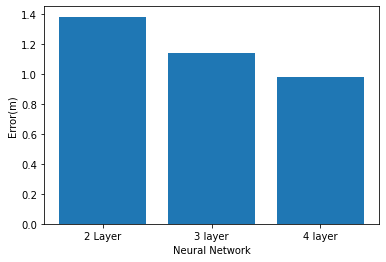

In [7]:
x1=['2 Layer','3 layer','4 layer']
y=[1.38,1.14,0.98]
plt.bar(x=x1, height=y)
ax = plt.gca()
ax.set(xlabel='Neural Network', ylabel='Error(m)')
plt.show()

# ANN Regression on Whole Dataset

General regression algorithm for all data set. This is not for the job but I will performed algorithms without using one pop out method also to compare the algorithms with other papers. Because most of the papers don't use this one position pop out method.

In [83]:
data=preprocessing1(0,0)

In [84]:
data

,position_x,position_y,frequency,r1_2,r1_3,r1_4
0,3.5,3.0,80000000.0,-44.451668,-7.529182,-1.806946
1,3.5,3.0,80000000.0,-43.220055,-1.716606,3.647118
2,3.5,3.0,80000000.0,-41.763329,2.685287,4.748489
3,3.5,3.0,80000000.0,-41.524742,2.842186,3.811111
4,3.5,3.0,80000000.0,-43.666885,-1.176971,1.495316
...,...,...,...,...,...,...
267925,16.0,27.0,990000000.0,36.315811,18.347076,12.370659
267926,16.0,27.0,990000000.0,36.422951,18.387970,12.497513
267927,16.0,27.0,990000000.0,36.555176,18.515205,12.634651
267928,16.0,27.0,990000000.0,36.688072,18.660194,12.740463


In [85]:
x=data.iloc[:,2:]
y=data.iloc[:,0:2]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)
PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X_train)
X_train=PredictorScalerFit.transform(X_train)
X_test=PredictorScalerFit.transform(X_test) 

In [36]:
from sklearn.model_selection import GridSearchCV

In [51]:
from keras.wrappers.scikit_learn import KerasRegressor

def create_deep(neurons):
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(neurons, input_dim=4, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(.001), metrics=['mse'])
    return model
model = KerasRegressor(build_fn = create_deep,
                       verbose = 0)
params = {
          'batch_size': [16, 32, 64], 
          'epochs': [10, 20, 30],
    'neurons' : [20, 30, 50]
          }


C:\Users\ayber\AppData\Local\Temp\ipykernel_13516\3516644343.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn = create_deep,


In [52]:
grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    cv=2,
                    n_jobs=1,
                    verbose=2)
grid.fit(X_train1, y_train1)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END ...............batch_size=16, epochs=10, neurons=20; total time=  12.6s
[CV] END ...............batch_size=16, epochs=10, neurons=20; total time=   8.9s
[CV] END ...............batch_size=16, epochs=10, neurons=30; total time=   9.3s
[CV] END ...............batch_size=16, epochs=10, neurons=30; total time=   9.9s
[CV] END ...............batch_size=16, epochs=10, neurons=50; total time=   9.3s
[CV] END ...............batch_size=16, epochs=10, neurons=50; total time=   9.5s
[CV] END ...............batch_size=16, epochs=20, neurons=20; total time=  18.3s
[CV] END ...............batch_size=16, epochs=20, neurons=20; total time=  17.5s
[CV] END ...............batch_size=16, epochs=20, neurons=30; total time=  17.1s
[CV] END ...............batch_size=16, epochs=20, neurons=30; total time=  16.5s
[CV] END ...............batch_size=16, epochs=20, neurons=50; total time=  16.2s
[CV] END ...............batch_size=16, epochs=20

In [ ]:
def create_deep():
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(50, input_dim=4, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(.001), metrics=['mse'])
    return model

model=create_deep()
model.fit(X_train,y_train,epochs=30, batch_size=16)
temp_pred=model.predict(X_test)
print(l2_dist((temp_pred[:,0],temp_pred[:,1]), (y_test.iloc[:,0],y_test.iloc[:,1])))

In [57]:
def create_deep(neurons):
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(neurons, input_dim=4, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(.001), metrics=['mse'])
    return model
model = KerasRegressor(build_fn = create_deep,
                       verbose = 0)
params = {
          'batch_size': [16, 32, 64], 
          'epochs': [10, 20, 30],
    'neurons' : [20, 30, 50]
          }


C:\Users\ayber\AppData\Local\Temp\ipykernel_13516\660967224.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn = create_deep,


In [58]:
grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    cv=2,
                    n_jobs=1,
                    verbose=2)
grid.fit(X_train1, y_train1)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END ...............batch_size=16, epochs=10, neurons=20; total time=  16.1s
[CV] END ...............batch_size=16, epochs=10, neurons=20; total time=  18.1s
[CV] END ...............batch_size=16, epochs=10, neurons=30; total time=  21.1s
[CV] END ...............batch_size=16, epochs=10, neurons=30; total time=  24.6s
[CV] END ...............batch_size=16, epochs=10, neurons=50; total time=  37.6s
[CV] END ...............batch_size=16, epochs=10, neurons=50; total time=  32.9s
[CV] END ...............batch_size=16, epochs=20, neurons=20; total time= 1.0min
[CV] END ...............batch_size=16, epochs=20, neurons=20; total time= 1.5min
[CV] END ...............batch_size=16, epochs=20, neurons=30; total time=  56.3s
[CV] END ...............batch_size=16, epochs=20, neurons=30; total time= 1.0min
[CV] END ...............batch_size=16, epochs=20, neurons=50; total time=  49.5s
[CV] END ...............batch_size=16, epochs=20

In [ ]:
def create_deep():
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(50, input_dim=4, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(.001), metrics=['mse'])
    return model

model=create_deep()
model.fit(X_train,y_train,epochs=30, batch_size=32)
temp_pred=model.predict(X_test)
print(l2_dist((temp_pred[:,0],temp_pred[:,1]), (y_test.iloc[:,0],y_test.iloc[:,1])))

In [59]:
def create_deep(neurons):
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(neurons, input_dim=4, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(.001), metrics=['mse'])
    return model
model = KerasRegressor(build_fn = create_deep,
                       verbose = 0)
params = {
          'batch_size': [16, 32, 64], 
          'epochs': [10, 20, 30],
    'neurons' : [20, 30, 50]
          }


C:\Users\ayber\AppData\Local\Temp\ipykernel_13516\4045772471.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn = create_deep,


In [60]:
grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    cv=2,
                    n_jobs=1,
                    verbose=2)
grid.fit(X_train1, y_train1)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END ...............batch_size=16, epochs=10, neurons=20; total time=  19.7s
[CV] END ...............batch_size=16, epochs=10, neurons=20; total time=  19.8s
[CV] END ...............batch_size=16, epochs=10, neurons=30; total time=  16.0s
[CV] END ...............batch_size=16, epochs=10, neurons=30; total time=  15.9s
[CV] END ...............batch_size=16, epochs=10, neurons=50; total time=  16.4s
[CV] END ...............batch_size=16, epochs=10, neurons=50; total time=  16.6s
[CV] END ...............batch_size=16, epochs=20, neurons=20; total time=  28.2s
[CV] END ...............batch_size=16, epochs=20, neurons=20; total time=  29.9s
[CV] END ...............batch_size=16, epochs=20, neurons=30; total time=  29.4s
[CV] END ...............batch_size=16, epochs=20, neurons=30; total time=  22.8s
[CV] END ...............batch_size=16, epochs=20, neurons=50; total time=  24.1s
[CV] END ...............batch_size=16, epochs=20

In [ ]:
def create_deep():
    seed = 7
    np.random.seed(seed)
    model = Sequential()
    model.add(Dense(50, input_dim=4, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))

    model.add(Dense(2, activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer=Adam(.001), metrics=['mse'])
    return model

model=create_deep()
model.fit(X_train,y_train,epochs=30, batch_size=32)
temp_pred=model.predict(X_test)
print(l2_dist((temp_pred[:,0],temp_pred[:,1]), (y_test.iloc[:,0],y_test.iloc[:,1])))